In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
from tqdm import trange
import random
import time
from collections import deque
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())

1.8.0
True


In [3]:
env = gym.make('BipedalWalker-v3')
env_button = {'BipedalWalker-v3': env}

# Set seeds
seed = 88
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
# Code based on: CS5180 Homework 6: Deep Q-Networks in Pytorch

def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(s):
            return env.action_space.sample()

    s = env.reset()
    env.render()

    while True:
        a = policy(s)
        s, _, done, _ = env.step(a)
        env.render()

        if done:
            break
            
    env.close()

In [5]:
# Code based on: CS5180 Homework 6: Deep Q-Networks in Pytorch

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = env_button[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in env_button.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


In [6]:
# Code based on: https://github.com/sfujim/TD3/blob/master/OurDDPG.py

class Actor(nn.Module):
    def __init__(self, s_size, a_size, a_max):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(s_size, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, a_size)

        self.a_max = a_max

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.a_max * torch.tanh(self.l3(x)) 
        
        return x
    
class Critic(nn.Module):
    def __init__(self, s_size, a_size):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(s_size + a_size, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 1)
        
        self.l4 = nn.Linear(s_size + a_size, 512)
        self.l5 = nn.Linear(512, 256)
        self.l6 = nn.Linear(256, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        
        x1 = self.l3(F.relu(self.l2(F.relu(self.l1(xu)))))
        x2 = self.l6(F.relu(self.l5(F.relu(self.l4(xu)))))
        
        return x1, x2

In [7]:
class Buffer(object):
    def __init__(self, s_size, a_size, max_size=int(1e6)):
        self.max_size = max_size

        self.s = torch.empty((max_size, s_size))
        self.a = torch.empty((max_size, a_size))
        self.n_s = torch.empty((max_size, s_size))
        self.r = torch.empty((max_size, 1))
        self.done = torch.empty((max_size, 1))
        
        self.idx = 0
        self.size = 0

    def add(self, s, a, n_s,  r, done):
        
        self.s[self.idx] = torch.as_tensor(s).to(device)
        self.a[self.idx] = torch.as_tensor(a).to(device)
        self.n_s[self.idx] = torch.as_tensor(n_s).to(device)
        self.r[self.idx] = torch.as_tensor(r).to(device)
        self.done[self.idx] = torch.as_tensor(1 - done).to(device)

        self.idx = (self.idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        sample_idx = np.random.randint(0, self.size, size=batch_size)
        
        s = torch.as_tensor(self.s[sample_idx]).to(device)
        a_cpu = torch.as_tensor(self.a[sample_idx])
        n_s = torch.as_tensor(self.n_s[sample_idx]).to(device)
        r = torch.as_tensor(self.r[sample_idx]).to(device)
        done = torch.as_tensor(self.done[sample_idx]).to(device)
        
        return (s, a_cpu, n_s, r, done)

In [8]:
# Code based on: https://github.com/Rafael1s/Deep-Reinforcement-Learning-Algorithms/blob/master/BipedalWalker-TwinDelayed-DDPG%20(TD3)/TwinDelayed.py

class DDPG(object): 
    def __init__(self, s_size, a_size, a_max):
        self.actor = Actor(s_size, a_size, a_max).to(device)
        self.actor_target = Actor(s_size, a_size, a_max).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())

        self.critic = Critic(s_size, a_size).to(device)
        self.critic_target = Critic(s_size, a_size).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

        self.a_max = a_max

    def Action(self, s):
        s= torch.FloatTensor(s.reshape(1, -1)).to(device)
        return self.actor(s).cpu().data.numpy().flatten()

    def train(self, buffer, iterations, batch_size=100, discount=0.99, \
              tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
        
        for it in range(iterations):

            # Sample replay buffer
            s, a_cpu, n_s, r, done = buffer.sample(batch_size)
            a = torch.as_tensor(a_cpu).to(device)
            
            # Select action according to policy and add clipped noise 
            noise = torch.FloatTensor(a_cpu).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            n_a = (self.actor_target(n_s) + noise).clamp(-self.a_max, self.a_max)

            # Compute the target Q valuen_a

            target_Q1, target_Q2 = self.critic_target(n_s, n_a)
            target_Q = torch.min(target_Q1, target_Q2)
            
            target_Q = r + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(s, a)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if it % policy_freq == 0:

                # Compute actor loss
                actor_loss = -self.critic.forward(s, self.actor(s))[0].mean()
                # Optimize the actor 
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    

In [9]:
# https://github.com/Rafael1s/Deep-Reinforcement-Learning-Algorithms/blob/master/BipedalWalker-TwinDelayed-DDPG%20(TD3)/BipedalWalker_1795ep_300-5sc_9h44m.ipynb

def Train(episodes, save_every=10):
    
    time_start = time.time() 
    
    T_start = 1e4
    T_total = 0
    steps = 0
    
    deq_scores = deque(maxlen=100)
    scores = []
    Avg_Scores = []    
    
    a_max = float(env.action_space.high[0])
    a_size = env.action_space.shape[0] 
    s_size = env.observation_space.shape[0]

    agent = DDPG(s_size, a_size, a_max)          
    buffer = Buffer(s_size, a_size)   
            
    for i in trange(1, episodes + 1):
        
        timestep = 0
        timestep_max = env._max_episode_steps
        
        R = 0
        s = env.reset()
        
        while True:
            if T_total < T_start:
                a = env.action_space.sample()
                
            else:
                a = agent.Action(np.array(s)) + np.random.normal(0, 0.1, size = a_size)
                a = (a).clip(env.action_space.low, env.action_space.high)

            n_s, r, done, _ = env.step(a)
            
            timestep += 1
            T_total += 1
            steps += 1
            
            R += r
            done_ = done
            
            if timestep == timestep_max:
                done_ = 0 
 
            buffer.add(s, a, n_s, r, done_)
            s = n_s

            if done:                                       
                break                                     

        deq_scores.append(R)
        scores.append(R)

        avg_score = np.mean(deq_scores)
        Avg_Scores.append(avg_score)
        
        s = (int)(time.time() - time_start)
        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i, T_total, timestep, \
                        R, avg_score, s//3600, s%3600//60, s%60))     

        agent.train(buffer, timestep)
        
        if len(deq_scores) == 100 and np.mean(deq_scores) >= 300.5:
            print('Environment solved with Average Score: ',  np.mean(deq_scores) )
            break 

    return scores, Avg_Scores

In [10]:
scores, Avg_Scores = Train(episodes = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Ep. 1, Timestep 1600,  Ep.Timesteps 1600, Score: -80.18, Avg.Score: -80.18, Time: 00:00:05 


  0%|          | 1/2000 [00:15<8:23:10, 15.10s/it]

Ep. 2, Timestep 1682,  Ep.Timesteps 82, Score: -102.00, Avg.Score: -91.09, Time: 00:00:17 


  0%|          | 2/2000 [00:15<3:44:00,  6.73s/it]

Ep. 3, Timestep 1783,  Ep.Timesteps 101, Score: -97.86, Avg.Score: -93.35, Time: 00:00:18 


  0%|          | 3/2000 [00:16<2:16:06,  4.09s/it]

Ep. 4, Timestep 1857,  Ep.Timesteps 74, Score: -105.28, Avg.Score: -96.33, Time: 00:00:19 


  0%|          | 4/2000 [00:17<1:31:29,  2.75s/it]

Ep. 5, Timestep 3457,  Ep.Timesteps 1600, Score: -86.73, Avg.Score: -94.41, Time: 00:00:23 


  0%|          | 5/2000 [00:32<3:57:39,  7.15s/it]

Ep. 6, Timestep 5057,  Ep.Timesteps 1600, Score: -80.49, Avg.Score: -92.09, Time: 00:00:38 


  0%|          | 6/2000 [00:47<5:25:31,  9.80s/it]

Ep. 7, Timestep 5125,  Ep.Timesteps 68, Score: -113.04, Avg.Score: -95.08, Time: 00:00:49 


  0%|          | 7/2000 [00:48<3:47:02,  6.84s/it]

Ep. 8, Timestep 5218,  Ep.Timesteps 93, Score: -107.68, Avg.Score: -96.66, Time: 00:00:50 


  0%|          | 8/2000 [00:49<2:44:49,  4.96s/it]

Ep. 9, Timestep 6818,  Ep.Timesteps 1600, Score: -92.34, Avg.Score: -96.18, Time: 00:00:55 


  0%|          | 9/2000 [01:04<4:34:13,  8.26s/it]

Ep. 10, Timestep 8418,  Ep.Timesteps 1600, Score: -81.50, Avg.Score: -94.71, Time: 00:01:11 


  0%|          | 10/2000 [01:20<5:47:35, 10.48s/it]

Ep. 11, Timestep 8477,  Ep.Timesteps 59, Score: -112.16, Avg.Score: -96.30, Time: 00:01:22 


  1%|          | 11/2000 [01:20<4:06:01,  7.42s/it]

Ep. 12, Timestep 8571,  Ep.Timesteps 94, Score: -100.03, Avg.Score: -96.61, Time: 00:01:22 


  1%|          | 12/2000 [01:21<2:59:13,  5.41s/it]

Ep. 13, Timestep 8638,  Ep.Timesteps 67, Score: -104.50, Avg.Score: -97.21, Time: 00:01:23 


  1%|          | 13/2000 [01:22<2:11:49,  3.98s/it]

Ep. 14, Timestep 9967,  Ep.Timesteps 1329, Score: -187.61, Avg.Score: -103.67, Time: 00:01:27 


  1%|          | 14/2000 [01:35<3:45:48,  6.82s/it]

Ep. 15, Timestep 10063,  Ep.Timesteps 96, Score: -115.00, Avg.Score: -104.43, Time: 00:01:37 


  1%|          | 15/2000 [01:36<2:46:50,  5.04s/it]

Ep. 16, Timestep 10128,  Ep.Timesteps 65, Score: -110.88, Avg.Score: -104.83, Time: 00:01:38 


  1%|          | 16/2000 [01:37<2:02:58,  3.72s/it]

Ep. 17, Timestep 10286,  Ep.Timesteps 158, Score: -123.51, Avg.Score: -105.93, Time: 00:01:39 


  1%|          | 17/2000 [01:38<1:40:17,  3.03s/it]

Ep. 18, Timestep 11886,  Ep.Timesteps 1600, Score: -153.30, Avg.Score: -108.56, Time: 00:01:45 


  1%|          | 18/2000 [01:55<3:56:52,  7.17s/it]

Ep. 19, Timestep 13486,  Ep.Timesteps 1600, Score: -169.56, Avg.Score: -111.77, Time: 00:02:01 


  1%|          | 19/2000 [02:11<5:23:42,  9.80s/it]

Ep. 20, Timestep 13536,  Ep.Timesteps 50, Score: -107.40, Avg.Score: -111.55, Time: 00:02:13 


  1%|          | 20/2000 [02:11<3:51:54,  7.03s/it]

Ep. 21, Timestep 13589,  Ep.Timesteps 53, Score: -107.17, Avg.Score: -111.34, Time: 00:02:14 


  1%|          | 21/2000 [02:12<2:47:23,  5.07s/it]

Ep. 22, Timestep 13703,  Ep.Timesteps 114, Score: -109.15, Avg.Score: -111.24, Time: 00:02:14 


  1%|          | 22/2000 [02:13<2:08:01,  3.88s/it]

Ep. 23, Timestep 13770,  Ep.Timesteps 67, Score: -103.98, Avg.Score: -110.93, Time: 00:02:15 


  1%|          | 23/2000 [02:14<1:36:08,  2.92s/it]

Ep. 24, Timestep 13896,  Ep.Timesteps 126, Score: -108.01, Avg.Score: -110.81, Time: 00:02:16 


  1%|          | 24/2000 [02:15<1:18:50,  2.39s/it]

Ep. 25, Timestep 13944,  Ep.Timesteps 48, Score: -102.50, Avg.Score: -110.47, Time: 00:02:17 


  1%|▏         | 25/2000 [02:15<59:22,  1.80s/it]  

Ep. 26, Timestep 13999,  Ep.Timesteps 55, Score: -105.38, Avg.Score: -110.28, Time: 00:02:17 


  1%|▏         | 26/2000 [02:16<46:20,  1.41s/it]

Ep. 27, Timestep 14051,  Ep.Timesteps 52, Score: -103.85, Avg.Score: -110.04, Time: 00:02:18 


  1%|▏         | 27/2000 [02:16<37:11,  1.13s/it]

Ep. 28, Timestep 14096,  Ep.Timesteps 45, Score: -102.67, Avg.Score: -109.78, Time: 00:02:18 


  1%|▏         | 28/2000 [02:17<30:32,  1.08it/s]

Ep. 29, Timestep 14149,  Ep.Timesteps 53, Score: -102.36, Avg.Score: -109.52, Time: 00:02:19 


  1%|▏         | 29/2000 [02:17<26:57,  1.22it/s]

Ep. 30, Timestep 14209,  Ep.Timesteps 60, Score: -104.19, Avg.Score: -109.34, Time: 00:02:20 


  2%|▏         | 30/2000 [02:18<25:31,  1.29it/s]

Ep. 31, Timestep 14301,  Ep.Timesteps 92, Score: -130.14, Avg.Score: -110.02, Time: 00:02:20 


  2%|▏         | 31/2000 [02:19<28:18,  1.16it/s]

Ep. 32, Timestep 14392,  Ep.Timesteps 91, Score: -112.96, Avg.Score: -110.11, Time: 00:02:21 


  2%|▏         | 32/2000 [02:20<30:12,  1.09it/s]

Ep. 33, Timestep 14429,  Ep.Timesteps 37, Score: -113.42, Avg.Score: -110.21, Time: 00:02:22 


  2%|▏         | 33/2000 [02:20<25:15,  1.30it/s]

Ep. 34, Timestep 14487,  Ep.Timesteps 58, Score: -121.66, Avg.Score: -110.54, Time: 00:02:23 


  2%|▏         | 34/2000 [02:21<24:00,  1.36it/s]

Ep. 35, Timestep 14602,  Ep.Timesteps 115, Score: -127.19, Avg.Score: -111.02, Time: 00:02:24 


  2%|▏         | 35/2000 [02:22<29:20,  1.12it/s]

Ep. 36, Timestep 14723,  Ep.Timesteps 121, Score: -128.23, Avg.Score: -111.50, Time: 00:02:25 


  2%|▏         | 36/2000 [02:24<33:39,  1.03s/it]

Ep. 37, Timestep 14798,  Ep.Timesteps 75, Score: -129.56, Avg.Score: -111.99, Time: 00:02:26 


  2%|▏         | 37/2000 [02:24<30:55,  1.06it/s]

Ep. 38, Timestep 14903,  Ep.Timesteps 105, Score: -114.98, Avg.Score: -112.06, Time: 00:02:27 


  2%|▏         | 38/2000 [02:25<31:57,  1.02it/s]

Ep. 39, Timestep 15047,  Ep.Timesteps 144, Score: -111.56, Avg.Score: -112.05, Time: 00:02:28 


  2%|▏         | 39/2000 [02:27<36:35,  1.12s/it]

Ep. 40, Timestep 15105,  Ep.Timesteps 58, Score: -123.54, Avg.Score: -112.34, Time: 00:02:29 


  2%|▏         | 40/2000 [02:28<31:57,  1.02it/s]

Ep. 41, Timestep 15263,  Ep.Timesteps 158, Score: -107.68, Avg.Score: -112.23, Time: 00:02:30 


  2%|▏         | 41/2000 [02:29<40:13,  1.23s/it]

Ep. 42, Timestep 15377,  Ep.Timesteps 114, Score: -139.27, Avg.Score: -112.87, Time: 00:02:32 


  2%|▏         | 42/2000 [02:31<39:39,  1.22s/it]

Ep. 43, Timestep 15426,  Ep.Timesteps 49, Score: -101.33, Avg.Score: -112.60, Time: 00:02:33 


  2%|▏         | 43/2000 [02:31<32:35,  1.00it/s]

Ep. 44, Timestep 15471,  Ep.Timesteps 45, Score: -102.75, Avg.Score: -112.38, Time: 00:02:33 


  2%|▏         | 44/2000 [02:32<27:12,  1.20it/s]

Ep. 45, Timestep 15539,  Ep.Timesteps 68, Score: -109.07, Avg.Score: -112.30, Time: 00:02:34 


  2%|▏         | 45/2000 [02:32<25:35,  1.27it/s]

Ep. 46, Timestep 15625,  Ep.Timesteps 86, Score: -100.94, Avg.Score: -112.06, Time: 00:02:35 


  2%|▏         | 46/2000 [02:33<26:04,  1.25it/s]

Ep. 47, Timestep 15698,  Ep.Timesteps 73, Score: -130.19, Avg.Score: -112.44, Time: 00:02:35 


  2%|▏         | 47/2000 [02:34<25:11,  1.29it/s]

Ep. 48, Timestep 15819,  Ep.Timesteps 121, Score: -103.55, Avg.Score: -112.26, Time: 00:02:36 


  2%|▏         | 48/2000 [02:35<28:16,  1.15it/s]

Ep. 49, Timestep 15876,  Ep.Timesteps 57, Score: -106.03, Avg.Score: -112.13, Time: 00:02:37 


  2%|▏         | 49/2000 [02:35<25:31,  1.27it/s]

Ep. 50, Timestep 15984,  Ep.Timesteps 108, Score: -137.41, Avg.Score: -112.64, Time: 00:02:38 


  2%|▎         | 50/2000 [02:37<29:00,  1.12it/s]

Ep. 51, Timestep 16083,  Ep.Timesteps 99, Score: -117.86, Avg.Score: -112.74, Time: 00:02:39 


  3%|▎         | 51/2000 [02:38<31:18,  1.04it/s]

Ep. 52, Timestep 16192,  Ep.Timesteps 109, Score: -138.75, Avg.Score: -113.24, Time: 00:02:40 


  3%|▎         | 52/2000 [02:39<33:47,  1.04s/it]

Ep. 53, Timestep 16297,  Ep.Timesteps 105, Score: -111.84, Avg.Score: -113.21, Time: 00:02:41 


  3%|▎         | 53/2000 [02:40<35:31,  1.09s/it]

Ep. 54, Timestep 16431,  Ep.Timesteps 134, Score: -143.59, Avg.Score: -113.77, Time: 00:02:43 


  3%|▎         | 54/2000 [02:42<39:59,  1.23s/it]

Ep. 55, Timestep 16498,  Ep.Timesteps 67, Score: -98.30, Avg.Score: -113.49, Time: 00:02:44 


  3%|▎         | 55/2000 [02:43<35:41,  1.10s/it]

Ep. 56, Timestep 16587,  Ep.Timesteps 89, Score: -105.67, Avg.Score: -113.35, Time: 00:02:45 


  3%|▎         | 56/2000 [02:43<34:13,  1.06s/it]

Ep. 57, Timestep 16673,  Ep.Timesteps 86, Score: -104.45, Avg.Score: -113.20, Time: 00:02:46 


  3%|▎         | 57/2000 [02:44<32:25,  1.00s/it]

Ep. 58, Timestep 16745,  Ep.Timesteps 72, Score: -105.47, Avg.Score: -113.06, Time: 00:02:47 


  3%|▎         | 58/2000 [02:45<29:47,  1.09it/s]

Ep. 59, Timestep 16838,  Ep.Timesteps 93, Score: -105.73, Avg.Score: -112.94, Time: 00:02:47 


  3%|▎         | 59/2000 [02:46<30:06,  1.07it/s]

Ep. 60, Timestep 16922,  Ep.Timesteps 84, Score: -131.55, Avg.Score: -113.25, Time: 00:02:48 


  3%|▎         | 60/2000 [02:47<30:02,  1.08it/s]

Ep. 61, Timestep 17055,  Ep.Timesteps 133, Score: -109.46, Avg.Score: -113.19, Time: 00:02:50 


  3%|▎         | 61/2000 [02:48<35:47,  1.11s/it]

Ep. 62, Timestep 17164,  Ep.Timesteps 109, Score: -107.49, Avg.Score: -113.10, Time: 00:02:51 


  3%|▎         | 62/2000 [02:50<35:36,  1.10s/it]

Ep. 63, Timestep 17288,  Ep.Timesteps 124, Score: -138.60, Avg.Score: -113.50, Time: 00:02:52 


  3%|▎         | 63/2000 [02:51<36:44,  1.14s/it]

Ep. 64, Timestep 17391,  Ep.Timesteps 103, Score: -109.94, Avg.Score: -113.44, Time: 00:02:53 


  3%|▎         | 64/2000 [02:52<35:34,  1.10s/it]

Ep. 65, Timestep 17500,  Ep.Timesteps 109, Score: -112.98, Avg.Score: -113.44, Time: 00:02:54 


  3%|▎         | 65/2000 [02:53<34:40,  1.08s/it]

Ep. 66, Timestep 17576,  Ep.Timesteps 76, Score: -99.26, Avg.Score: -113.22, Time: 00:02:55 


  3%|▎         | 66/2000 [02:54<31:00,  1.04it/s]

Ep. 67, Timestep 17658,  Ep.Timesteps 82, Score: -127.70, Avg.Score: -113.44, Time: 00:02:56 


  3%|▎         | 67/2000 [02:54<29:44,  1.08it/s]

Ep. 68, Timestep 17775,  Ep.Timesteps 117, Score: -141.13, Avg.Score: -113.85, Time: 00:02:57 


  3%|▎         | 68/2000 [02:56<32:59,  1.02s/it]

Ep. 69, Timestep 17872,  Ep.Timesteps 97, Score: -105.41, Avg.Score: -113.72, Time: 00:02:58 


  3%|▎         | 69/2000 [02:57<33:53,  1.05s/it]

Ep. 70, Timestep 17947,  Ep.Timesteps 75, Score: -129.38, Avg.Score: -113.95, Time: 00:02:59 


  4%|▎         | 70/2000 [02:58<32:00,  1.00it/s]

Ep. 71, Timestep 18017,  Ep.Timesteps 70, Score: -127.24, Avg.Score: -114.13, Time: 00:03:00 


  4%|▎         | 71/2000 [02:58<30:05,  1.07it/s]

Ep. 72, Timestep 18085,  Ep.Timesteps 68, Score: -127.24, Avg.Score: -114.32, Time: 00:03:01 


  4%|▎         | 72/2000 [02:59<28:30,  1.13it/s]

Ep. 73, Timestep 18143,  Ep.Timesteps 58, Score: -100.86, Avg.Score: -114.13, Time: 00:03:02 


  4%|▎         | 73/2000 [03:00<26:20,  1.22it/s]

Ep. 74, Timestep 18208,  Ep.Timesteps 65, Score: -124.25, Avg.Score: -114.27, Time: 00:03:02 


  4%|▎         | 74/2000 [03:01<25:38,  1.25it/s]

Ep. 75, Timestep 18355,  Ep.Timesteps 147, Score: -146.06, Avg.Score: -114.69, Time: 00:03:03 


  4%|▍         | 75/2000 [03:02<33:40,  1.05s/it]

Ep. 76, Timestep 18448,  Ep.Timesteps 93, Score: -131.65, Avg.Score: -114.92, Time: 00:03:05 


  4%|▍         | 76/2000 [03:03<32:45,  1.02s/it]

Ep. 77, Timestep 18510,  Ep.Timesteps 62, Score: -100.15, Avg.Score: -114.72, Time: 00:03:05 


  4%|▍         | 77/2000 [03:04<28:59,  1.11it/s]

Ep. 78, Timestep 18560,  Ep.Timesteps 50, Score: -106.41, Avg.Score: -114.62, Time: 00:03:06 


  4%|▍         | 78/2000 [03:04<25:11,  1.27it/s]

Ep. 79, Timestep 18752,  Ep.Timesteps 192, Score: -117.31, Avg.Score: -114.65, Time: 00:03:07 


  4%|▍         | 79/2000 [03:06<37:54,  1.18s/it]

Ep. 80, Timestep 18853,  Ep.Timesteps 101, Score: -107.07, Avg.Score: -114.56, Time: 00:03:09 


  4%|▍         | 80/2000 [03:08<37:15,  1.16s/it]

Ep. 81, Timestep 18957,  Ep.Timesteps 104, Score: -140.69, Avg.Score: -114.88, Time: 00:03:10 


  4%|▍         | 81/2000 [03:09<35:55,  1.12s/it]

Ep. 82, Timestep 19041,  Ep.Timesteps 84, Score: -115.82, Avg.Score: -114.89, Time: 00:03:11 


  4%|▍         | 82/2000 [03:09<32:54,  1.03s/it]

Ep. 83, Timestep 19091,  Ep.Timesteps 50, Score: -108.64, Avg.Score: -114.82, Time: 00:03:12 


  4%|▍         | 83/2000 [03:10<27:47,  1.15it/s]

Ep. 84, Timestep 19140,  Ep.Timesteps 49, Score: -107.09, Avg.Score: -114.72, Time: 00:03:12 


  4%|▍         | 84/2000 [03:10<24:10,  1.32it/s]

Ep. 85, Timestep 19205,  Ep.Timesteps 65, Score: -118.18, Avg.Score: -114.76, Time: 00:03:13 


  4%|▍         | 85/2000 [03:11<23:05,  1.38it/s]

Ep. 86, Timestep 19378,  Ep.Timesteps 173, Score: -133.95, Avg.Score: -114.99, Time: 00:03:14 


  4%|▍         | 86/2000 [03:13<31:07,  1.02it/s]

Ep. 87, Timestep 19430,  Ep.Timesteps 52, Score: -100.63, Avg.Score: -114.82, Time: 00:03:15 


  4%|▍         | 87/2000 [03:13<26:56,  1.18it/s]

Ep. 88, Timestep 19483,  Ep.Timesteps 53, Score: -101.83, Avg.Score: -114.68, Time: 00:03:15 


  4%|▍         | 88/2000 [03:14<24:03,  1.32it/s]

Ep. 89, Timestep 19544,  Ep.Timesteps 61, Score: -101.00, Avg.Score: -114.52, Time: 00:03:16 


  4%|▍         | 89/2000 [03:14<23:24,  1.36it/s]

Ep. 90, Timestep 19597,  Ep.Timesteps 53, Score: -106.55, Avg.Score: -114.43, Time: 00:03:17 


  4%|▍         | 90/2000 [03:15<22:08,  1.44it/s]

Ep. 91, Timestep 19654,  Ep.Timesteps 57, Score: -100.31, Avg.Score: -114.28, Time: 00:03:17 


  5%|▍         | 91/2000 [03:16<21:51,  1.46it/s]

Ep. 92, Timestep 19713,  Ep.Timesteps 59, Score: -104.19, Avg.Score: -114.17, Time: 00:03:18 


  5%|▍         | 92/2000 [03:16<21:55,  1.45it/s]

Ep. 93, Timestep 19768,  Ep.Timesteps 55, Score: -102.92, Avg.Score: -114.05, Time: 00:03:19 


  5%|▍         | 93/2000 [03:17<21:28,  1.48it/s]

Ep. 94, Timestep 19824,  Ep.Timesteps 56, Score: -103.31, Avg.Score: -113.93, Time: 00:03:19 


  5%|▍         | 94/2000 [03:18<21:05,  1.51it/s]

Ep. 95, Timestep 19893,  Ep.Timesteps 69, Score: -112.83, Avg.Score: -113.92, Time: 00:03:20 


  5%|▍         | 95/2000 [03:18<22:07,  1.44it/s]

Ep. 96, Timestep 19946,  Ep.Timesteps 53, Score: -103.71, Avg.Score: -113.81, Time: 00:03:21 


  5%|▍         | 96/2000 [03:19<21:27,  1.48it/s]

Ep. 97, Timestep 20025,  Ep.Timesteps 79, Score: -106.38, Avg.Score: -113.74, Time: 00:03:21 


  5%|▍         | 97/2000 [03:20<23:38,  1.34it/s]

Ep. 98, Timestep 20077,  Ep.Timesteps 52, Score: -104.07, Avg.Score: -113.64, Time: 00:03:22 


  5%|▍         | 98/2000 [03:20<22:01,  1.44it/s]

Ep. 99, Timestep 20149,  Ep.Timesteps 72, Score: -102.77, Avg.Score: -113.53, Time: 00:03:23 


  5%|▍         | 99/2000 [03:21<22:21,  1.42it/s]

Ep. 100, Timestep 20213,  Ep.Timesteps 64, Score: -103.90, Avg.Score: -113.43, Time: 00:03:24 


  5%|▌         | 100/2000 [03:22<21:43,  1.46it/s]

Ep. 101, Timestep 20273,  Ep.Timesteps 60, Score: -102.06, Avg.Score: -113.65, Time: 00:03:24 


  5%|▌         | 101/2000 [03:22<21:01,  1.51it/s]

Ep. 102, Timestep 20395,  Ep.Timesteps 122, Score: -117.26, Avg.Score: -113.80, Time: 00:03:25 


  5%|▌         | 102/2000 [03:24<26:55,  1.18it/s]

Ep. 103, Timestep 20457,  Ep.Timesteps 62, Score: -103.77, Avg.Score: -113.86, Time: 00:03:26 


  5%|▌         | 103/2000 [03:24<25:30,  1.24it/s]

Ep. 104, Timestep 20515,  Ep.Timesteps 58, Score: -103.02, Avg.Score: -113.84, Time: 00:03:27 


  5%|▌         | 104/2000 [03:25<24:14,  1.30it/s]

Ep. 105, Timestep 20588,  Ep.Timesteps 73, Score: -103.74, Avg.Score: -114.01, Time: 00:03:28 


  5%|▌         | 105/2000 [03:26<25:00,  1.26it/s]

Ep. 106, Timestep 20659,  Ep.Timesteps 71, Score: -104.41, Avg.Score: -114.25, Time: 00:03:28 


  5%|▌         | 106/2000 [03:27<24:07,  1.31it/s]

Ep. 107, Timestep 20719,  Ep.Timesteps 60, Score: -102.47, Avg.Score: -114.14, Time: 00:03:29 


  5%|▌         | 107/2000 [03:27<22:29,  1.40it/s]

Ep. 108, Timestep 20788,  Ep.Timesteps 69, Score: -105.62, Avg.Score: -114.12, Time: 00:03:30 


  5%|▌         | 108/2000 [03:28<22:11,  1.42it/s]

Ep. 109, Timestep 20867,  Ep.Timesteps 79, Score: -106.36, Avg.Score: -114.26, Time: 00:03:30 


  5%|▌         | 109/2000 [03:29<22:45,  1.38it/s]

Ep. 110, Timestep 20952,  Ep.Timesteps 85, Score: -106.93, Avg.Score: -114.52, Time: 00:03:31 


  6%|▌         | 110/2000 [03:30<23:52,  1.32it/s]

Ep. 111, Timestep 21032,  Ep.Timesteps 80, Score: -104.90, Avg.Score: -114.45, Time: 00:03:32 


  6%|▌         | 111/2000 [03:30<23:59,  1.31it/s]

Ep. 112, Timestep 21092,  Ep.Timesteps 60, Score: -106.73, Avg.Score: -114.51, Time: 00:03:33 


  6%|▌         | 112/2000 [03:31<21:53,  1.44it/s]

Ep. 113, Timestep 21159,  Ep.Timesteps 67, Score: -105.74, Avg.Score: -114.53, Time: 00:03:33 


  6%|▌         | 113/2000 [03:32<21:51,  1.44it/s]

Ep. 114, Timestep 21217,  Ep.Timesteps 58, Score: -101.23, Avg.Score: -113.66, Time: 00:03:34 


  6%|▌         | 114/2000 [03:32<20:53,  1.50it/s]

Ep. 115, Timestep 21306,  Ep.Timesteps 89, Score: -105.53, Avg.Score: -113.57, Time: 00:03:35 


  6%|▌         | 115/2000 [03:33<23:32,  1.33it/s]

Ep. 116, Timestep 21393,  Ep.Timesteps 87, Score: -105.85, Avg.Score: -113.52, Time: 00:03:36 


  6%|▌         | 116/2000 [03:34<25:45,  1.22it/s]

Ep. 117, Timestep 21530,  Ep.Timesteps 137, Score: -103.83, Avg.Score: -113.32, Time: 00:03:37 


  6%|▌         | 117/2000 [03:36<32:49,  1.05s/it]

Ep. 118, Timestep 21610,  Ep.Timesteps 80, Score: -105.27, Avg.Score: -112.84, Time: 00:03:38 


  6%|▌         | 118/2000 [03:37<31:31,  1.00s/it]

Ep. 119, Timestep 21669,  Ep.Timesteps 59, Score: -106.36, Avg.Score: -112.21, Time: 00:03:39 


  6%|▌         | 119/2000 [03:37<28:34,  1.10it/s]

Ep. 120, Timestep 21739,  Ep.Timesteps 70, Score: -105.92, Avg.Score: -112.19, Time: 00:03:40 


  6%|▌         | 120/2000 [03:38<27:48,  1.13it/s]

Ep. 121, Timestep 21810,  Ep.Timesteps 71, Score: -103.59, Avg.Score: -112.16, Time: 00:03:40 


  6%|▌         | 121/2000 [03:39<27:14,  1.15it/s]

Ep. 122, Timestep 21874,  Ep.Timesteps 64, Score: -100.17, Avg.Score: -112.07, Time: 00:03:41 


  6%|▌         | 122/2000 [03:40<25:42,  1.22it/s]

Ep. 123, Timestep 21984,  Ep.Timesteps 110, Score: -106.14, Avg.Score: -112.09, Time: 00:03:42 


  6%|▌         | 123/2000 [03:41<28:28,  1.10it/s]

Ep. 124, Timestep 22057,  Ep.Timesteps 73, Score: -101.29, Avg.Score: -112.02, Time: 00:03:43 


  6%|▌         | 124/2000 [03:41<26:54,  1.16it/s]

Ep. 125, Timestep 22119,  Ep.Timesteps 62, Score: -101.37, Avg.Score: -112.01, Time: 00:03:44 


  6%|▋         | 125/2000 [03:42<24:56,  1.25it/s]

Ep. 126, Timestep 22181,  Ep.Timesteps 62, Score: -102.49, Avg.Score: -111.98, Time: 00:03:45 


  6%|▋         | 126/2000 [03:43<24:06,  1.30it/s]

Ep. 127, Timestep 22251,  Ep.Timesteps 70, Score: -102.80, Avg.Score: -111.97, Time: 00:03:45 


  6%|▋         | 127/2000 [03:44<24:17,  1.29it/s]

Ep. 128, Timestep 22311,  Ep.Timesteps 60, Score: -101.37, Avg.Score: -111.96, Time: 00:03:46 


  6%|▋         | 128/2000 [03:44<23:34,  1.32it/s]

Ep. 129, Timestep 22377,  Ep.Timesteps 66, Score: -101.06, Avg.Score: -111.94, Time: 00:03:47 


  6%|▋         | 129/2000 [03:45<23:23,  1.33it/s]

Ep. 130, Timestep 22820,  Ep.Timesteps 443, Score: -131.31, Avg.Score: -112.22, Time: 00:03:48 


  6%|▋         | 130/2000 [03:49<55:41,  1.79s/it]

Ep. 131, Timestep 22882,  Ep.Timesteps 62, Score: -103.32, Avg.Score: -111.95, Time: 00:03:52 


  7%|▋         | 131/2000 [03:50<44:24,  1.43s/it]

Ep. 132, Timestep 22968,  Ep.Timesteps 86, Score: -99.30, Avg.Score: -111.81, Time: 00:03:52 


  7%|▋         | 132/2000 [03:51<39:07,  1.26s/it]

Ep. 133, Timestep 23053,  Ep.Timesteps 85, Score: -99.52, Avg.Score: -111.67, Time: 00:03:53 


  7%|▋         | 133/2000 [03:52<35:34,  1.14s/it]

Ep. 134, Timestep 23168,  Ep.Timesteps 115, Score: -105.14, Avg.Score: -111.51, Time: 00:03:54 


  7%|▋         | 134/2000 [03:53<36:44,  1.18s/it]

Ep. 135, Timestep 23257,  Ep.Timesteps 89, Score: -99.50, Avg.Score: -111.23, Time: 00:03:55 


  7%|▋         | 135/2000 [03:54<35:03,  1.13s/it]

Ep. 136, Timestep 23381,  Ep.Timesteps 124, Score: -109.04, Avg.Score: -111.04, Time: 00:03:56 


  7%|▋         | 136/2000 [03:55<37:28,  1.21s/it]

Ep. 137, Timestep 23541,  Ep.Timesteps 160, Score: -94.83, Avg.Score: -110.69, Time: 00:03:58 


  7%|▋         | 137/2000 [03:57<42:45,  1.38s/it]

Ep. 138, Timestep 23615,  Ep.Timesteps 74, Score: -100.06, Avg.Score: -110.54, Time: 00:03:59 


  7%|▋         | 138/2000 [03:58<37:49,  1.22s/it]

Ep. 139, Timestep 23745,  Ep.Timesteps 130, Score: -99.22, Avg.Score: -110.42, Time: 00:04:00 


  7%|▋         | 139/2000 [03:59<38:48,  1.25s/it]

Ep. 140, Timestep 23908,  Ep.Timesteps 163, Score: -99.71, Avg.Score: -110.18, Time: 00:04:02 


  7%|▋         | 140/2000 [04:01<42:11,  1.36s/it]

Ep. 141, Timestep 24142,  Ep.Timesteps 234, Score: -87.97, Avg.Score: -109.98, Time: 00:04:04 


  7%|▋         | 141/2000 [04:03<53:12,  1.72s/it]

Ep. 142, Timestep 24288,  Ep.Timesteps 146, Score: -95.27, Avg.Score: -109.54, Time: 00:04:06 


  7%|▋         | 142/2000 [04:05<50:05,  1.62s/it]

Ep. 143, Timestep 24396,  Ep.Timesteps 108, Score: -116.56, Avg.Score: -109.70, Time: 00:04:07 


  7%|▋         | 143/2000 [04:06<44:54,  1.45s/it]

Ep. 144, Timestep 24481,  Ep.Timesteps 85, Score: -107.14, Avg.Score: -109.74, Time: 00:04:08 


  7%|▋         | 144/2000 [04:07<39:05,  1.26s/it]

Ep. 145, Timestep 24586,  Ep.Timesteps 105, Score: -112.80, Avg.Score: -109.78, Time: 00:04:09 


  7%|▋         | 145/2000 [04:08<36:28,  1.18s/it]

Ep. 146, Timestep 24724,  Ep.Timesteps 138, Score: -100.93, Avg.Score: -109.78, Time: 00:04:10 


  7%|▋         | 146/2000 [04:09<37:08,  1.20s/it]

Ep. 147, Timestep 26324,  Ep.Timesteps 1600, Score: -98.71, Avg.Score: -109.46, Time: 00:04:17 


  7%|▋         | 147/2000 [04:26<3:01:44,  5.88s/it]

Ep. 148, Timestep 26494,  Ep.Timesteps 170, Score: -135.43, Avg.Score: -109.78, Time: 00:04:28 


  7%|▋         | 148/2000 [04:27<2:20:45,  4.56s/it]

Ep. 149, Timestep 26802,  Ep.Timesteps 308, Score: -136.31, Avg.Score: -110.08, Time: 00:04:30 


  7%|▋         | 149/2000 [04:31<2:09:17,  4.19s/it]

Ep. 150, Timestep 26916,  Ep.Timesteps 114, Score: -128.23, Avg.Score: -109.99, Time: 00:04:33 


  8%|▊         | 150/2000 [04:32<1:42:34,  3.33s/it]

Ep. 151, Timestep 27045,  Ep.Timesteps 129, Score: -121.03, Avg.Score: -110.02, Time: 00:04:34 


  8%|▊         | 151/2000 [04:33<1:24:57,  2.76s/it]

Ep. 152, Timestep 27238,  Ep.Timesteps 193, Score: -124.29, Avg.Score: -109.88, Time: 00:04:36 


  8%|▊         | 152/2000 [04:35<1:18:37,  2.55s/it]

Ep. 153, Timestep 27378,  Ep.Timesteps 140, Score: -118.72, Avg.Score: -109.95, Time: 00:04:38 


  8%|▊         | 153/2000 [04:37<1:07:50,  2.20s/it]

Ep. 154, Timestep 27506,  Ep.Timesteps 128, Score: -120.92, Avg.Score: -109.72, Time: 00:04:39 


  8%|▊         | 154/2000 [04:38<59:55,  1.95s/it]  

Ep. 155, Timestep 27639,  Ep.Timesteps 133, Score: -100.13, Avg.Score: -109.74, Time: 00:04:41 


  8%|▊         | 155/2000 [04:40<55:36,  1.81s/it]

Ep. 156, Timestep 27812,  Ep.Timesteps 173, Score: -99.12, Avg.Score: -109.67, Time: 00:04:42 


  8%|▊         | 156/2000 [04:41<56:38,  1.84s/it]

Ep. 157, Timestep 27950,  Ep.Timesteps 138, Score: -103.22, Avg.Score: -109.66, Time: 00:04:44 


  8%|▊         | 157/2000 [04:43<52:00,  1.69s/it]

Ep. 158, Timestep 28160,  Ep.Timesteps 210, Score: -127.90, Avg.Score: -109.89, Time: 00:04:46 


  8%|▊         | 158/2000 [04:45<54:41,  1.78s/it]

Ep. 159, Timestep 28347,  Ep.Timesteps 187, Score: -108.16, Avg.Score: -109.91, Time: 00:04:47 


  8%|▊         | 159/2000 [04:46<53:47,  1.75s/it]

Ep. 160, Timestep 28435,  Ep.Timesteps 88, Score: -100.29, Avg.Score: -109.60, Time: 00:04:49 


  8%|▊         | 160/2000 [04:47<46:16,  1.51s/it]

Ep. 161, Timestep 28550,  Ep.Timesteps 115, Score: -98.27, Avg.Score: -109.49, Time: 00:04:50 


  8%|▊         | 161/2000 [04:49<44:00,  1.44s/it]

Ep. 162, Timestep 29539,  Ep.Timesteps 989, Score: -186.63, Avg.Score: -110.28, Time: 00:04:54 


  8%|▊         | 162/2000 [04:59<2:08:56,  4.21s/it]

Ep. 163, Timestep 29615,  Ep.Timesteps 76, Score: -119.13, Avg.Score: -110.08, Time: 00:05:02 


  8%|▊         | 163/2000 [05:00<1:37:42,  3.19s/it]

Ep. 164, Timestep 31215,  Ep.Timesteps 1600, Score: -125.55, Avg.Score: -110.24, Time: 00:05:06 


  8%|▊         | 164/2000 [05:16<3:33:02,  6.96s/it]

Ep. 165, Timestep 32815,  Ep.Timesteps 1600, Score: -117.75, Avg.Score: -110.29, Time: 00:05:23 


  8%|▊         | 165/2000 [05:32<4:59:52,  9.80s/it]

Ep. 166, Timestep 34415,  Ep.Timesteps 1600, Score: -93.48, Avg.Score: -110.23, Time: 00:05:40 


  8%|▊         | 166/2000 [05:49<6:03:58, 11.91s/it]

Ep. 167, Timestep 36015,  Ep.Timesteps 1600, Score: -53.25, Avg.Score: -109.48, Time: 00:05:56 


  8%|▊         | 167/2000 [06:06<6:46:40, 13.31s/it]

Ep. 168, Timestep 37615,  Ep.Timesteps 1600, Score: -119.99, Avg.Score: -109.27, Time: 00:06:13 


  8%|▊         | 168/2000 [06:22<7:15:27, 14.26s/it]

Ep. 169, Timestep 39215,  Ep.Timesteps 1600, Score: -134.63, Avg.Score: -109.56, Time: 00:06:29 


  8%|▊         | 169/2000 [06:39<7:34:46, 14.90s/it]

Ep. 170, Timestep 40815,  Ep.Timesteps 1600, Score: -113.42, Avg.Score: -109.40, Time: 00:06:46 


  8%|▊         | 170/2000 [06:55<7:49:51, 15.41s/it]

Ep. 171, Timestep 42415,  Ep.Timesteps 1600, Score: -108.05, Avg.Score: -109.21, Time: 00:07:02 


  9%|▊         | 171/2000 [07:12<7:57:47, 15.67s/it]

Ep. 172, Timestep 44015,  Ep.Timesteps 1600, Score: -92.28, Avg.Score: -108.86, Time: 00:07:18 


  9%|▊         | 172/2000 [07:28<8:04:04, 15.89s/it]

Ep. 173, Timestep 45615,  Ep.Timesteps 1600, Score: -97.29, Avg.Score: -108.83, Time: 00:07:34 


  9%|▊         | 173/2000 [07:44<8:03:44, 15.89s/it]

Ep. 174, Timestep 47215,  Ep.Timesteps 1600, Score: -99.33, Avg.Score: -108.58, Time: 00:07:51 


  9%|▊         | 174/2000 [08:00<8:05:14, 15.94s/it]

Ep. 175, Timestep 48815,  Ep.Timesteps 1600, Score: -64.92, Avg.Score: -107.77, Time: 00:08:07 


  9%|▉         | 175/2000 [08:16<8:08:53, 16.07s/it]

Ep. 176, Timestep 50415,  Ep.Timesteps 1600, Score: -67.24, Avg.Score: -107.12, Time: 00:08:24 


  9%|▉         | 176/2000 [08:33<8:15:24, 16.30s/it]

Ep. 177, Timestep 52015,  Ep.Timesteps 1600, Score: -64.19, Avg.Score: -106.76, Time: 00:08:41 


  9%|▉         | 177/2000 [08:50<8:22:53, 16.55s/it]

Ep. 178, Timestep 52075,  Ep.Timesteps 60, Score: -103.69, Avg.Score: -106.74, Time: 00:08:53 


  9%|▉         | 178/2000 [08:51<5:58:10, 11.80s/it]

Ep. 179, Timestep 53675,  Ep.Timesteps 1600, Score: -75.44, Avg.Score: -106.32, Time: 00:08:59 


  9%|▉         | 179/2000 [09:08<6:44:27, 13.33s/it]

Ep. 180, Timestep 55275,  Ep.Timesteps 1600, Score: -62.91, Avg.Score: -105.88, Time: 00:09:16 


  9%|▉         | 180/2000 [09:25<7:17:35, 14.43s/it]

Ep. 181, Timestep 56875,  Ep.Timesteps 1600, Score: -66.87, Avg.Score: -105.14, Time: 00:09:32 


  9%|▉         | 181/2000 [09:42<7:38:55, 15.14s/it]

Ep. 182, Timestep 58475,  Ep.Timesteps 1600, Score: -79.15, Avg.Score: -104.77, Time: 00:09:49 


  9%|▉         | 182/2000 [09:58<7:51:17, 15.55s/it]

Ep. 183, Timestep 58578,  Ep.Timesteps 103, Score: -101.08, Avg.Score: -104.70, Time: 00:10:01 


  9%|▉         | 183/2000 [09:59<5:38:09, 11.17s/it]

Ep. 184, Timestep 60178,  Ep.Timesteps 1600, Score: -65.25, Avg.Score: -104.28, Time: 00:10:06 


  9%|▉         | 184/2000 [10:15<6:23:43, 12.68s/it]

Ep. 185, Timestep 61778,  Ep.Timesteps 1600, Score: -70.92, Avg.Score: -103.80, Time: 00:10:22 


  9%|▉         | 185/2000 [10:31<6:51:27, 13.60s/it]

Ep. 186, Timestep 63378,  Ep.Timesteps 1600, Score: -61.01, Avg.Score: -103.07, Time: 00:10:38 


  9%|▉         | 186/2000 [10:47<7:11:59, 14.29s/it]

Ep. 187, Timestep 64978,  Ep.Timesteps 1600, Score: -66.73, Avg.Score: -102.74, Time: 00:10:54 


  9%|▉         | 187/2000 [11:03<7:30:49, 14.92s/it]

Ep. 188, Timestep 66578,  Ep.Timesteps 1600, Score: -64.89, Avg.Score: -102.37, Time: 00:11:11 


  9%|▉         | 188/2000 [11:20<7:45:41, 15.42s/it]

Ep. 189, Timestep 68178,  Ep.Timesteps 1600, Score: -71.49, Avg.Score: -102.07, Time: 00:11:28 


  9%|▉         | 189/2000 [11:37<7:58:51, 15.86s/it]

Ep. 190, Timestep 69778,  Ep.Timesteps 1600, Score: -84.80, Avg.Score: -101.85, Time: 00:11:45 


 10%|▉         | 190/2000 [11:54<8:10:16, 16.25s/it]

Ep. 191, Timestep 71378,  Ep.Timesteps 1600, Score: -80.91, Avg.Score: -101.66, Time: 00:12:01 


 10%|▉         | 191/2000 [12:11<8:15:03, 16.42s/it]

Ep. 192, Timestep 72978,  Ep.Timesteps 1600, Score: -68.15, Avg.Score: -101.30, Time: 00:12:17 


 10%|▉         | 192/2000 [12:27<8:11:15, 16.30s/it]

Ep. 193, Timestep 74578,  Ep.Timesteps 1600, Score: -44.95, Avg.Score: -100.72, Time: 00:12:33 


 10%|▉         | 193/2000 [12:43<8:07:36, 16.19s/it]

Ep. 194, Timestep 76178,  Ep.Timesteps 1600, Score: -98.56, Avg.Score: -100.67, Time: 00:12:50 


 10%|▉         | 194/2000 [12:59<8:06:33, 16.16s/it]

Ep. 195, Timestep 77778,  Ep.Timesteps 1600, Score: -58.98, Avg.Score: -100.13, Time: 00:13:06 


 10%|▉         | 195/2000 [13:16<8:11:07, 16.33s/it]

Ep. 196, Timestep 79378,  Ep.Timesteps 1600, Score: -49.64, Avg.Score: -99.59, Time: 00:13:23 


 10%|▉         | 196/2000 [13:32<8:15:35, 16.48s/it]

Ep. 197, Timestep 80978,  Ep.Timesteps 1600, Score: -74.46, Avg.Score: -99.27, Time: 00:13:40 


 10%|▉         | 197/2000 [13:49<8:20:14, 16.65s/it]

Ep. 198, Timestep 82578,  Ep.Timesteps 1600, Score: -60.46, Avg.Score: -98.84, Time: 00:13:57 


 10%|▉         | 198/2000 [14:07<8:23:50, 16.78s/it]

Ep. 199, Timestep 84178,  Ep.Timesteps 1600, Score: -72.51, Avg.Score: -98.54, Time: 00:14:14 


 10%|▉         | 199/2000 [14:23<8:24:26, 16.81s/it]

Ep. 200, Timestep 85778,  Ep.Timesteps 1600, Score: -50.15, Avg.Score: -98.00, Time: 00:14:30 


 10%|█         | 200/2000 [14:39<8:17:05, 16.57s/it]

Ep. 201, Timestep 87378,  Ep.Timesteps 1600, Score: -76.41, Avg.Score: -97.74, Time: 00:14:46 


 10%|█         | 201/2000 [14:55<8:11:57, 16.41s/it]

Ep. 202, Timestep 88978,  Ep.Timesteps 1600, Score: -61.33, Avg.Score: -97.18, Time: 00:15:02 


 10%|█         | 202/2000 [15:12<8:09:45, 16.34s/it]

Ep. 203, Timestep 90578,  Ep.Timesteps 1600, Score: -52.01, Avg.Score: -96.66, Time: 00:15:19 


 10%|█         | 203/2000 [15:29<8:14:23, 16.51s/it]

Ep. 204, Timestep 92178,  Ep.Timesteps 1600, Score: -54.87, Avg.Score: -96.18, Time: 00:15:36 


 10%|█         | 204/2000 [15:45<8:18:09, 16.64s/it]

Ep. 205, Timestep 93778,  Ep.Timesteps 1600, Score: -62.66, Avg.Score: -95.77, Time: 00:15:53 


 10%|█         | 205/2000 [16:02<8:19:50, 16.71s/it]

Ep. 206, Timestep 95378,  Ep.Timesteps 1600, Score: -45.43, Avg.Score: -95.18, Time: 00:16:10 


 10%|█         | 206/2000 [16:19<8:18:23, 16.67s/it]

Ep. 207, Timestep 96978,  Ep.Timesteps 1600, Score: -55.47, Avg.Score: -94.71, Time: 00:16:26 


 10%|█         | 207/2000 [16:35<8:14:31, 16.55s/it]

Ep. 208, Timestep 98578,  Ep.Timesteps 1600, Score: -49.89, Avg.Score: -94.15, Time: 00:16:42 


 10%|█         | 208/2000 [16:52<8:15:36, 16.59s/it]

Ep. 209, Timestep 100178,  Ep.Timesteps 1600, Score: -47.01, Avg.Score: -93.56, Time: 00:16:59 


 10%|█         | 209/2000 [17:08<8:13:58, 16.55s/it]

Ep. 210, Timestep 101778,  Ep.Timesteps 1600, Score: -49.95, Avg.Score: -92.99, Time: 00:17:15 


 10%|█         | 210/2000 [17:24<8:09:46, 16.42s/it]

Ep. 211, Timestep 103378,  Ep.Timesteps 1600, Score: -45.19, Avg.Score: -92.39, Time: 00:17:31 


 11%|█         | 211/2000 [17:41<8:06:51, 16.33s/it]

Ep. 212, Timestep 104978,  Ep.Timesteps 1600, Score: -43.61, Avg.Score: -91.76, Time: 00:17:48 


 11%|█         | 212/2000 [17:57<8:07:42, 16.37s/it]

Ep. 213, Timestep 106578,  Ep.Timesteps 1600, Score: -62.68, Avg.Score: -91.33, Time: 00:18:04 


 11%|█         | 213/2000 [18:14<8:09:31, 16.44s/it]

Ep. 214, Timestep 108178,  Ep.Timesteps 1600, Score: -40.38, Avg.Score: -90.72, Time: 00:18:21 


 11%|█         | 214/2000 [18:30<8:09:48, 16.45s/it]

Ep. 215, Timestep 109778,  Ep.Timesteps 1600, Score: -42.88, Avg.Score: -90.10, Time: 00:18:37 


 11%|█         | 215/2000 [18:46<8:08:41, 16.43s/it]

Ep. 216, Timestep 111378,  Ep.Timesteps 1600, Score: -45.72, Avg.Score: -89.50, Time: 00:18:53 


 11%|█         | 216/2000 [19:03<8:08:30, 16.43s/it]

Ep. 217, Timestep 112978,  Ep.Timesteps 1600, Score: -48.85, Avg.Score: -88.95, Time: 00:19:09 


 11%|█         | 217/2000 [19:19<8:03:51, 16.28s/it]

Ep. 218, Timestep 114578,  Ep.Timesteps 1600, Score: -65.61, Avg.Score: -88.55, Time: 00:19:25 


 11%|█         | 218/2000 [19:35<7:58:57, 16.13s/it]

Ep. 219, Timestep 116178,  Ep.Timesteps 1600, Score: -46.79, Avg.Score: -87.95, Time: 00:19:41 


 11%|█         | 219/2000 [19:51<7:57:02, 16.07s/it]

Ep. 220, Timestep 117778,  Ep.Timesteps 1600, Score: -55.11, Avg.Score: -87.45, Time: 00:19:58 


 11%|█         | 220/2000 [20:07<7:58:50, 16.14s/it]

Ep. 221, Timestep 119378,  Ep.Timesteps 1600, Score: -42.78, Avg.Score: -86.84, Time: 00:20:14 


 11%|█         | 221/2000 [20:23<8:01:04, 16.22s/it]

Ep. 222, Timestep 120978,  Ep.Timesteps 1600, Score: -43.01, Avg.Score: -86.27, Time: 00:20:31 


 11%|█         | 222/2000 [20:40<8:04:29, 16.35s/it]

Ep. 223, Timestep 122578,  Ep.Timesteps 1600, Score: -23.26, Avg.Score: -85.44, Time: 00:20:47 


 11%|█         | 223/2000 [20:56<8:05:40, 16.40s/it]

Ep. 224, Timestep 124178,  Ep.Timesteps 1600, Score: -80.49, Avg.Score: -85.23, Time: 00:21:04 


 11%|█         | 224/2000 [21:13<8:06:22, 16.43s/it]

Ep. 225, Timestep 125778,  Ep.Timesteps 1600, Score: -74.95, Avg.Score: -84.97, Time: 00:21:20 


 11%|█▏        | 225/2000 [21:29<8:03:37, 16.35s/it]

Ep. 226, Timestep 127378,  Ep.Timesteps 1600, Score: -49.52, Avg.Score: -84.44, Time: 00:21:35 


 11%|█▏        | 226/2000 [21:45<7:59:30, 16.22s/it]

Ep. 227, Timestep 128978,  Ep.Timesteps 1600, Score: -52.03, Avg.Score: -83.93, Time: 00:21:52 


 11%|█▏        | 227/2000 [22:01<7:57:11, 16.15s/it]

Ep. 228, Timestep 130578,  Ep.Timesteps 1600, Score: -53.77, Avg.Score: -83.45, Time: 00:22:08 


 11%|█▏        | 228/2000 [22:17<7:57:48, 16.18s/it]

Ep. 229, Timestep 132178,  Ep.Timesteps 1600, Score: -56.78, Avg.Score: -83.01, Time: 00:22:24 


 11%|█▏        | 229/2000 [22:33<7:57:26, 16.18s/it]

Ep. 230, Timestep 133778,  Ep.Timesteps 1600, Score: -66.94, Avg.Score: -82.37, Time: 00:22:41 


 12%|█▏        | 230/2000 [22:50<7:58:43, 16.23s/it]

Ep. 231, Timestep 135378,  Ep.Timesteps 1600, Score: -85.89, Avg.Score: -82.19, Time: 00:22:57 


 12%|█▏        | 231/2000 [23:06<8:00:06, 16.28s/it]

Ep. 232, Timestep 136978,  Ep.Timesteps 1600, Score: -81.41, Avg.Score: -82.01, Time: 00:23:13 


 12%|█▏        | 232/2000 [23:22<7:59:28, 16.27s/it]

Ep. 233, Timestep 138578,  Ep.Timesteps 1600, Score: -50.22, Avg.Score: -81.52, Time: 00:23:29 


 12%|█▏        | 233/2000 [23:38<7:56:08, 16.17s/it]

Ep. 234, Timestep 140178,  Ep.Timesteps 1600, Score: -84.25, Avg.Score: -81.31, Time: 00:23:45 


 12%|█▏        | 234/2000 [23:54<7:55:19, 16.15s/it]

Ep. 235, Timestep 141778,  Ep.Timesteps 1600, Score: -106.38, Avg.Score: -81.38, Time: 00:24:02 


 12%|█▏        | 235/2000 [24:11<7:56:42, 16.21s/it]

Ep. 236, Timestep 143378,  Ep.Timesteps 1600, Score: -87.74, Avg.Score: -81.17, Time: 00:24:18 


 12%|█▏        | 236/2000 [24:27<7:56:52, 16.22s/it]

Ep. 237, Timestep 144978,  Ep.Timesteps 1600, Score: -95.34, Avg.Score: -81.17, Time: 00:24:34 


 12%|█▏        | 237/2000 [24:43<7:57:17, 16.24s/it]

Ep. 238, Timestep 146578,  Ep.Timesteps 1600, Score: -67.52, Avg.Score: -80.85, Time: 00:24:50 


 12%|█▏        | 238/2000 [25:00<7:58:13, 16.28s/it]

Ep. 239, Timestep 148178,  Ep.Timesteps 1600, Score: -60.31, Avg.Score: -80.46, Time: 00:25:06 


 12%|█▏        | 239/2000 [25:16<7:53:41, 16.14s/it]

Ep. 240, Timestep 149778,  Ep.Timesteps 1600, Score: -46.66, Avg.Score: -79.93, Time: 00:25:22 


 12%|█▏        | 240/2000 [25:31<7:47:41, 15.94s/it]

Ep. 241, Timestep 151378,  Ep.Timesteps 1600, Score: -37.44, Avg.Score: -79.42, Time: 00:25:38 


 12%|█▏        | 241/2000 [25:47<7:51:39, 16.09s/it]

Ep. 242, Timestep 152978,  Ep.Timesteps 1600, Score: -46.70, Avg.Score: -78.94, Time: 00:25:55 


 12%|█▏        | 242/2000 [26:04<7:55:41, 16.24s/it]

Ep. 243, Timestep 154578,  Ep.Timesteps 1600, Score: -51.02, Avg.Score: -78.28, Time: 00:26:12 


 12%|█▏        | 243/2000 [26:21<8:00:40, 16.41s/it]

Ep. 244, Timestep 156178,  Ep.Timesteps 1600, Score: -138.97, Avg.Score: -78.60, Time: 00:26:29 


 12%|█▏        | 244/2000 [26:38<8:04:54, 16.57s/it]

Ep. 245, Timestep 157778,  Ep.Timesteps 1600, Score: -89.33, Avg.Score: -78.36, Time: 00:26:45 


 12%|█▏        | 245/2000 [26:55<8:06:09, 16.62s/it]

Ep. 246, Timestep 157897,  Ep.Timesteps 119, Score: -132.41, Avg.Score: -78.68, Time: 00:26:57 


 12%|█▏        | 246/2000 [26:56<5:50:05, 11.98s/it]

Ep. 247, Timestep 157984,  Ep.Timesteps 87, Score: -98.40, Avg.Score: -78.68, Time: 00:26:58 


 12%|█▏        | 247/2000 [26:57<4:13:30,  8.68s/it]

Ep. 248, Timestep 158068,  Ep.Timesteps 84, Score: -101.97, Avg.Score: -78.34, Time: 00:26:59 


 12%|█▏        | 248/2000 [26:58<3:05:41,  6.36s/it]

Ep. 249, Timestep 159668,  Ep.Timesteps 1600, Score: -82.38, Avg.Score: -77.80, Time: 00:27:05 


 12%|█▏        | 249/2000 [27:14<4:33:05,  9.36s/it]

Ep. 250, Timestep 161268,  Ep.Timesteps 1600, Score: -80.90, Avg.Score: -77.33, Time: 00:27:21 


 12%|█▎        | 250/2000 [27:31<5:36:51, 11.55s/it]

Ep. 251, Timestep 162868,  Ep.Timesteps 1600, Score: -73.12, Avg.Score: -76.85, Time: 00:27:38 


 13%|█▎        | 251/2000 [27:47<6:18:54, 13.00s/it]

Ep. 252, Timestep 164468,  Ep.Timesteps 1600, Score: -72.01, Avg.Score: -76.33, Time: 00:27:54 


 13%|█▎        | 252/2000 [28:03<6:45:38, 13.92s/it]

Ep. 253, Timestep 166068,  Ep.Timesteps 1600, Score: -56.15, Avg.Score: -75.70, Time: 00:28:09 


 13%|█▎        | 253/2000 [28:19<7:02:01, 14.49s/it]

Ep. 254, Timestep 167668,  Ep.Timesteps 1600, Score: -110.54, Avg.Score: -75.60, Time: 00:28:26 


 13%|█▎        | 254/2000 [28:35<7:14:35, 14.93s/it]

Ep. 255, Timestep 169268,  Ep.Timesteps 1600, Score: -85.13, Avg.Score: -75.45, Time: 00:28:42 


 13%|█▎        | 255/2000 [28:51<7:25:23, 15.31s/it]

Ep. 256, Timestep 170868,  Ep.Timesteps 1600, Score: -55.95, Avg.Score: -75.02, Time: 00:28:59 


 13%|█▎        | 256/2000 [29:08<7:41:54, 15.89s/it]

Ep. 257, Timestep 172468,  Ep.Timesteps 1600, Score: -41.58, Avg.Score: -74.40, Time: 00:29:16 


 13%|█▎        | 257/2000 [29:26<7:57:00, 16.42s/it]

Ep. 258, Timestep 174068,  Ep.Timesteps 1600, Score: -24.33, Avg.Score: -73.36, Time: 00:29:33 


 13%|█▎        | 258/2000 [29:43<8:05:58, 16.74s/it]

Ep. 259, Timestep 175668,  Ep.Timesteps 1600, Score: -52.15, Avg.Score: -72.80, Time: 00:29:51 


 13%|█▎        | 259/2000 [30:01<8:11:05, 16.92s/it]

Ep. 260, Timestep 177268,  Ep.Timesteps 1600, Score: -61.27, Avg.Score: -72.41, Time: 00:30:08 


 13%|█▎        | 260/2000 [30:18<8:15:44, 17.09s/it]

Ep. 261, Timestep 178868,  Ep.Timesteps 1600, Score: -54.00, Avg.Score: -71.97, Time: 00:30:26 


 13%|█▎        | 261/2000 [30:36<8:17:27, 17.16s/it]

Ep. 262, Timestep 180468,  Ep.Timesteps 1600, Score: -63.74, Avg.Score: -70.74, Time: 00:30:41 


 13%|█▎        | 262/2000 [30:50<7:50:32, 16.24s/it]

Ep. 263, Timestep 182068,  Ep.Timesteps 1600, Score: -49.47, Avg.Score: -70.04, Time: 00:30:55 


 13%|█▎        | 263/2000 [31:04<7:29:18, 15.52s/it]

Ep. 264, Timestep 183668,  Ep.Timesteps 1600, Score: -33.69, Avg.Score: -69.13, Time: 00:31:08 


 13%|█▎        | 264/2000 [31:17<7:11:50, 14.93s/it]

Ep. 265, Timestep 185268,  Ep.Timesteps 1600, Score: -35.56, Avg.Score: -68.30, Time: 00:31:22 


 13%|█▎        | 265/2000 [31:30<6:57:19, 14.43s/it]

Ep. 266, Timestep 186868,  Ep.Timesteps 1600, Score: -49.28, Avg.Score: -67.86, Time: 00:31:35 


 13%|█▎        | 266/2000 [31:44<6:47:00, 14.08s/it]

Ep. 267, Timestep 188468,  Ep.Timesteps 1600, Score: -51.81, Avg.Score: -67.85, Time: 00:31:49 


 13%|█▎        | 267/2000 [31:57<6:42:10, 13.92s/it]

Ep. 268, Timestep 190068,  Ep.Timesteps 1600, Score: -37.33, Avg.Score: -67.02, Time: 00:32:03 


 13%|█▎        | 268/2000 [32:11<6:41:52, 13.92s/it]

Ep. 269, Timestep 191668,  Ep.Timesteps 1600, Score: -86.51, Avg.Score: -66.54, Time: 00:32:17 


 13%|█▎        | 269/2000 [32:25<6:41:45, 13.93s/it]

Ep. 270, Timestep 193268,  Ep.Timesteps 1600, Score: -56.49, Avg.Score: -65.97, Time: 00:32:31 


 14%|█▎        | 270/2000 [32:39<6:44:35, 14.03s/it]

Ep. 271, Timestep 194868,  Ep.Timesteps 1600, Score: -59.38, Avg.Score: -65.48, Time: 00:32:45 


 14%|█▎        | 271/2000 [32:53<6:45:41, 14.08s/it]

Ep. 272, Timestep 196468,  Ep.Timesteps 1600, Score: -47.51, Avg.Score: -65.04, Time: 00:32:59 


 14%|█▎        | 272/2000 [33:08<6:46:42, 14.12s/it]

Ep. 273, Timestep 198068,  Ep.Timesteps 1600, Score: -50.42, Avg.Score: -64.57, Time: 00:33:14 


 14%|█▎        | 273/2000 [33:22<6:47:26, 14.16s/it]

Ep. 274, Timestep 199668,  Ep.Timesteps 1600, Score: -56.57, Avg.Score: -64.14, Time: 00:33:28 


 14%|█▎        | 274/2000 [33:36<6:47:40, 14.17s/it]

Ep. 275, Timestep 201268,  Ep.Timesteps 1600, Score: -34.38, Avg.Score: -63.83, Time: 00:33:42 


 14%|█▍        | 275/2000 [33:50<6:48:07, 14.20s/it]

Ep. 276, Timestep 202868,  Ep.Timesteps 1600, Score: -36.61, Avg.Score: -63.53, Time: 00:33:56 


 14%|█▍        | 276/2000 [34:04<6:46:32, 14.15s/it]

Ep. 277, Timestep 204468,  Ep.Timesteps 1600, Score: -44.99, Avg.Score: -63.34, Time: 00:34:10 


 14%|█▍        | 277/2000 [34:18<6:44:45, 14.09s/it]

Ep. 278, Timestep 206068,  Ep.Timesteps 1600, Score: -50.46, Avg.Score: -62.80, Time: 00:34:24 


 14%|█▍        | 278/2000 [34:32<6:42:55, 14.04s/it]

Ep. 279, Timestep 207668,  Ep.Timesteps 1600, Score: -43.70, Avg.Score: -62.49, Time: 00:34:38 


 14%|█▍        | 279/2000 [34:46<6:42:39, 14.04s/it]

Ep. 280, Timestep 209268,  Ep.Timesteps 1600, Score: -56.71, Avg.Score: -62.42, Time: 00:34:52 


 14%|█▍        | 280/2000 [35:00<6:42:27, 14.04s/it]

Ep. 281, Timestep 210868,  Ep.Timesteps 1600, Score: -34.94, Avg.Score: -62.10, Time: 00:35:06 


 14%|█▍        | 281/2000 [35:14<6:40:33, 13.98s/it]

Ep. 282, Timestep 212468,  Ep.Timesteps 1600, Score: -34.66, Avg.Score: -61.66, Time: 00:35:19 


 14%|█▍        | 282/2000 [35:28<6:35:56, 13.83s/it]

Ep. 283, Timestep 214068,  Ep.Timesteps 1600, Score: -30.46, Avg.Score: -60.95, Time: 00:35:32 


 14%|█▍        | 283/2000 [35:41<6:28:16, 13.57s/it]

Ep. 284, Timestep 215668,  Ep.Timesteps 1600, Score: -56.33, Avg.Score: -60.86, Time: 00:35:45 


 14%|█▍        | 284/2000 [35:54<6:25:02, 13.46s/it]

Ep. 285, Timestep 217268,  Ep.Timesteps 1600, Score: -71.14, Avg.Score: -60.87, Time: 00:35:59 


 14%|█▍        | 285/2000 [36:08<6:26:12, 13.51s/it]

Ep. 286, Timestep 218868,  Ep.Timesteps 1600, Score: -39.13, Avg.Score: -60.65, Time: 00:36:13 


 14%|█▍        | 286/2000 [36:21<6:28:30, 13.60s/it]

Ep. 287, Timestep 218952,  Ep.Timesteps 84, Score: -115.56, Avg.Score: -61.14, Time: 00:36:24 


 14%|█▍        | 287/2000 [36:22<4:38:22,  9.75s/it]

Ep. 288, Timestep 220552,  Ep.Timesteps 1600, Score: -37.76, Avg.Score: -60.86, Time: 00:36:28 


 14%|█▍        | 288/2000 [36:36<5:14:42, 11.03s/it]

Ep. 289, Timestep 220640,  Ep.Timesteps 88, Score: -104.92, Avg.Score: -61.20, Time: 00:36:38 


 14%|█▍        | 289/2000 [36:37<3:47:13,  7.97s/it]

Ep. 290, Timestep 222240,  Ep.Timesteps 1600, Score: -45.36, Avg.Score: -60.80, Time: 00:36:43 


 14%|█▍        | 290/2000 [36:51<4:38:39,  9.78s/it]

Ep. 291, Timestep 223840,  Ep.Timesteps 1600, Score: -47.61, Avg.Score: -60.47, Time: 00:36:57 


 15%|█▍        | 291/2000 [37:05<5:13:11, 11.00s/it]

Ep. 292, Timestep 225440,  Ep.Timesteps 1600, Score: -81.85, Avg.Score: -60.61, Time: 00:37:10 


 15%|█▍        | 292/2000 [37:19<5:37:54, 11.87s/it]

Ep. 293, Timestep 227040,  Ep.Timesteps 1600, Score: -52.01, Avg.Score: -60.68, Time: 00:37:24 


 15%|█▍        | 293/2000 [37:33<5:54:45, 12.47s/it]

Ep. 294, Timestep 228640,  Ep.Timesteps 1600, Score: -77.89, Avg.Score: -60.47, Time: 00:37:38 


 15%|█▍        | 294/2000 [37:46<6:07:00, 12.91s/it]

Ep. 295, Timestep 230240,  Ep.Timesteps 1600, Score: -45.62, Avg.Score: -60.34, Time: 00:37:52 


 15%|█▍        | 295/2000 [38:00<6:15:10, 13.20s/it]

Ep. 296, Timestep 231840,  Ep.Timesteps 1600, Score: -69.88, Avg.Score: -60.54, Time: 00:38:06 


 15%|█▍        | 296/2000 [38:14<6:20:50, 13.41s/it]

Ep. 297, Timestep 233440,  Ep.Timesteps 1600, Score: -35.92, Avg.Score: -60.16, Time: 00:38:20 


 15%|█▍        | 297/2000 [38:28<6:25:07, 13.57s/it]

Ep. 298, Timestep 233515,  Ep.Timesteps 75, Score: -99.20, Avg.Score: -60.54, Time: 00:38:30 


 15%|█▍        | 298/2000 [38:29<4:34:15,  9.67s/it]

Ep. 299, Timestep 235115,  Ep.Timesteps 1600, Score: -46.36, Avg.Score: -60.28, Time: 00:38:34 


 15%|█▍        | 299/2000 [38:43<5:09:39, 10.92s/it]

Ep. 300, Timestep 236715,  Ep.Timesteps 1600, Score: -29.50, Avg.Score: -60.08, Time: 00:38:48 


 15%|█▌        | 300/2000 [38:56<5:30:49, 11.68s/it]

Ep. 301, Timestep 238315,  Ep.Timesteps 1600, Score: -35.34, Avg.Score: -59.66, Time: 00:39:01 


 15%|█▌        | 301/2000 [39:09<5:42:04, 12.08s/it]

Ep. 302, Timestep 239915,  Ep.Timesteps 1600, Score: -33.55, Avg.Score: -59.39, Time: 00:39:14 


 15%|█▌        | 302/2000 [39:22<5:49:49, 12.36s/it]

Ep. 303, Timestep 241515,  Ep.Timesteps 1600, Score: -42.71, Avg.Score: -59.29, Time: 00:39:27 


 15%|█▌        | 303/2000 [39:35<5:58:19, 12.67s/it]

Ep. 304, Timestep 243115,  Ep.Timesteps 1600, Score: -43.31, Avg.Score: -59.18, Time: 00:39:41 


 15%|█▌        | 304/2000 [39:49<6:07:14, 12.99s/it]

Ep. 305, Timestep 244715,  Ep.Timesteps 1600, Score: -33.76, Avg.Score: -58.89, Time: 00:39:55 


 15%|█▌        | 305/2000 [40:03<6:13:15, 13.21s/it]

Ep. 306, Timestep 246315,  Ep.Timesteps 1600, Score: -44.69, Avg.Score: -58.88, Time: 00:40:09 


 15%|█▌        | 306/2000 [40:17<6:17:16, 13.36s/it]

Ep. 307, Timestep 247915,  Ep.Timesteps 1600, Score: -50.51, Avg.Score: -58.83, Time: 00:40:22 


 15%|█▌        | 307/2000 [40:30<6:19:59, 13.47s/it]

Ep. 308, Timestep 249515,  Ep.Timesteps 1600, Score: -59.14, Avg.Score: -58.92, Time: 00:40:36 


 15%|█▌        | 308/2000 [40:44<6:22:00, 13.55s/it]

Ep. 309, Timestep 251115,  Ep.Timesteps 1600, Score: -53.73, Avg.Score: -58.99, Time: 00:40:50 


 15%|█▌        | 309/2000 [40:58<6:24:43, 13.65s/it]

Ep. 310, Timestep 252715,  Ep.Timesteps 1600, Score: -67.37, Avg.Score: -59.17, Time: 00:41:04 


 16%|█▌        | 310/2000 [41:12<6:26:22, 13.72s/it]

Ep. 311, Timestep 253690,  Ep.Timesteps 975, Score: -197.03, Avg.Score: -60.68, Time: 00:41:16 


 16%|█▌        | 311/2000 [41:20<5:41:27, 12.13s/it]

Ep. 312, Timestep 255290,  Ep.Timesteps 1600, Score: -62.14, Avg.Score: -60.87, Time: 00:41:26 


 16%|█▌        | 312/2000 [41:34<5:54:45, 12.61s/it]

Ep. 313, Timestep 256890,  Ep.Timesteps 1600, Score: -109.11, Avg.Score: -61.33, Time: 00:41:40 


 16%|█▌        | 313/2000 [41:48<6:03:59, 12.95s/it]

Ep. 314, Timestep 258490,  Ep.Timesteps 1600, Score: -107.74, Avg.Score: -62.01, Time: 00:41:53 


 16%|█▌        | 314/2000 [42:02<6:11:05, 13.21s/it]

Ep. 315, Timestep 260090,  Ep.Timesteps 1600, Score: -96.37, Avg.Score: -62.54, Time: 00:42:07 


 16%|█▌        | 315/2000 [42:15<6:15:45, 13.38s/it]

Ep. 316, Timestep 261690,  Ep.Timesteps 1600, Score: -59.30, Avg.Score: -62.68, Time: 00:42:21 


 16%|█▌        | 316/2000 [42:29<6:19:17, 13.51s/it]

Ep. 317, Timestep 263290,  Ep.Timesteps 1600, Score: -72.63, Avg.Score: -62.92, Time: 00:42:35 


 16%|█▌        | 317/2000 [42:43<6:21:49, 13.61s/it]

Ep. 318, Timestep 264890,  Ep.Timesteps 1600, Score: -92.36, Avg.Score: -63.18, Time: 00:42:49 


 16%|█▌        | 318/2000 [42:57<6:24:05, 13.70s/it]

Ep. 319, Timestep 266490,  Ep.Timesteps 1600, Score: -60.79, Avg.Score: -63.32, Time: 00:43:02 


 16%|█▌        | 319/2000 [43:11<6:24:22, 13.72s/it]

Ep. 320, Timestep 268090,  Ep.Timesteps 1600, Score: -39.57, Avg.Score: -63.17, Time: 00:43:16 


 16%|█▌        | 320/2000 [43:24<6:21:12, 13.61s/it]

Ep. 321, Timestep 269690,  Ep.Timesteps 1600, Score: -29.16, Avg.Score: -63.03, Time: 00:43:29 


 16%|█▌        | 321/2000 [43:37<6:15:26, 13.42s/it]

Ep. 322, Timestep 271290,  Ep.Timesteps 1600, Score: -37.58, Avg.Score: -62.98, Time: 00:43:42 


 16%|█▌        | 322/2000 [43:50<6:11:59, 13.30s/it]

Ep. 323, Timestep 272890,  Ep.Timesteps 1600, Score: -70.60, Avg.Score: -63.45, Time: 00:43:55 


 16%|█▌        | 323/2000 [44:03<6:12:48, 13.34s/it]

Ep. 324, Timestep 274490,  Ep.Timesteps 1600, Score: -35.00, Avg.Score: -63.00, Time: 00:44:09 


 16%|█▌        | 324/2000 [44:17<6:15:21, 13.44s/it]

Ep. 325, Timestep 276090,  Ep.Timesteps 1600, Score: -39.96, Avg.Score: -62.65, Time: 00:44:23 


 16%|█▋        | 325/2000 [44:31<6:18:07, 13.54s/it]

Ep. 326, Timestep 277690,  Ep.Timesteps 1600, Score: -41.57, Avg.Score: -62.57, Time: 00:44:37 


 16%|█▋        | 326/2000 [44:45<6:23:05, 13.73s/it]

Ep. 327, Timestep 279290,  Ep.Timesteps 1600, Score: -38.26, Avg.Score: -62.43, Time: 00:44:51 


 16%|█▋        | 327/2000 [44:59<6:25:49, 13.84s/it]

Ep. 328, Timestep 280890,  Ep.Timesteps 1600, Score: -66.01, Avg.Score: -62.55, Time: 00:45:05 


 16%|█▋        | 328/2000 [45:13<6:28:11, 13.93s/it]

Ep. 329, Timestep 282490,  Ep.Timesteps 1600, Score: -67.46, Avg.Score: -62.66, Time: 00:45:19 


 16%|█▋        | 329/2000 [45:27<6:29:26, 13.98s/it]

Ep. 330, Timestep 284090,  Ep.Timesteps 1600, Score: -84.12, Avg.Score: -62.83, Time: 00:45:33 


 16%|█▋        | 330/2000 [45:41<6:29:41, 14.00s/it]

Ep. 331, Timestep 285690,  Ep.Timesteps 1600, Score: -70.46, Avg.Score: -62.68, Time: 00:45:47 


 17%|█▋        | 331/2000 [45:56<6:30:14, 14.03s/it]

Ep. 332, Timestep 287290,  Ep.Timesteps 1600, Score: -69.16, Avg.Score: -62.55, Time: 00:46:01 


 17%|█▋        | 332/2000 [46:10<6:30:28, 14.05s/it]

Ep. 333, Timestep 288890,  Ep.Timesteps 1600, Score: -68.37, Avg.Score: -62.73, Time: 00:46:15 


 17%|█▋        | 333/2000 [46:24<6:31:27, 14.09s/it]

Ep. 334, Timestep 290490,  Ep.Timesteps 1600, Score: -33.98, Avg.Score: -62.23, Time: 00:46:29 


 17%|█▋        | 334/2000 [46:38<6:30:00, 14.05s/it]

Ep. 335, Timestep 292090,  Ep.Timesteps 1600, Score: -26.53, Avg.Score: -61.43, Time: 00:46:43 


 17%|█▋        | 335/2000 [46:51<6:24:32, 13.86s/it]

Ep. 336, Timestep 293690,  Ep.Timesteps 1600, Score: -41.13, Avg.Score: -60.97, Time: 00:46:56 


 17%|█▋        | 336/2000 [47:04<6:16:54, 13.59s/it]

Ep. 337, Timestep 295290,  Ep.Timesteps 1600, Score: -10.33, Avg.Score: -60.12, Time: 00:47:09 


 17%|█▋        | 337/2000 [47:17<6:11:48, 13.41s/it]

Ep. 338, Timestep 296890,  Ep.Timesteps 1600, Score: -64.62, Avg.Score: -60.09, Time: 00:47:22 


 17%|█▋        | 338/2000 [47:31<6:12:28, 13.45s/it]

Ep. 339, Timestep 298490,  Ep.Timesteps 1600, Score: -40.70, Avg.Score: -59.89, Time: 00:47:36 


 17%|█▋        | 339/2000 [47:45<6:15:16, 13.56s/it]

Ep. 340, Timestep 300090,  Ep.Timesteps 1600, Score: -15.33, Avg.Score: -59.58, Time: 00:47:50 


 17%|█▋        | 340/2000 [47:58<6:17:29, 13.64s/it]

Ep. 341, Timestep 301690,  Ep.Timesteps 1600, Score: -10.54, Avg.Score: -59.31, Time: 00:48:04 


 17%|█▋        | 341/2000 [48:12<6:18:19, 13.68s/it]

Ep. 342, Timestep 303290,  Ep.Timesteps 1600, Score: -33.14, Avg.Score: -59.17, Time: 00:48:18 


 17%|█▋        | 342/2000 [48:26<6:19:27, 13.73s/it]

Ep. 343, Timestep 304890,  Ep.Timesteps 1600, Score: -67.14, Avg.Score: -59.34, Time: 00:48:32 


 17%|█▋        | 343/2000 [48:40<6:19:53, 13.76s/it]

Ep. 344, Timestep 306490,  Ep.Timesteps 1600, Score: -62.75, Avg.Score: -58.57, Time: 00:48:46 


 17%|█▋        | 344/2000 [48:54<6:20:54, 13.80s/it]

Ep. 345, Timestep 308090,  Ep.Timesteps 1600, Score: 16.83, Avg.Score: -57.51, Time: 00:48:59 


 17%|█▋        | 345/2000 [49:08<6:20:37, 13.80s/it]

Ep. 346, Timestep 309690,  Ep.Timesteps 1600, Score: -59.38, Avg.Score: -56.78, Time: 00:49:13 


 17%|█▋        | 346/2000 [49:22<6:22:25, 13.87s/it]

Ep. 347, Timestep 311290,  Ep.Timesteps 1600, Score: -49.32, Avg.Score: -56.29, Time: 00:49:27 


 17%|█▋        | 347/2000 [49:35<6:21:53, 13.86s/it]

Ep. 348, Timestep 312890,  Ep.Timesteps 1600, Score: -40.23, Avg.Score: -55.67, Time: 00:49:40 


 17%|█▋        | 348/2000 [49:49<6:18:33, 13.75s/it]

Ep. 349, Timestep 314490,  Ep.Timesteps 1600, Score: -42.97, Avg.Score: -55.28, Time: 00:49:53 


 17%|█▋        | 349/2000 [50:02<6:12:32, 13.54s/it]

Ep. 350, Timestep 316090,  Ep.Timesteps 1600, Score: -33.13, Avg.Score: -54.80, Time: 00:50:07 


 18%|█▊        | 350/2000 [50:15<6:09:29, 13.44s/it]

Ep. 351, Timestep 317690,  Ep.Timesteps 1600, Score: -2.59, Avg.Score: -54.10, Time: 00:50:20 


 18%|█▊        | 351/2000 [50:29<6:10:05, 13.47s/it]

Ep. 352, Timestep 319290,  Ep.Timesteps 1600, Score: -28.77, Avg.Score: -53.66, Time: 00:50:34 


 18%|█▊        | 352/2000 [50:43<6:13:00, 13.58s/it]

Ep. 353, Timestep 320890,  Ep.Timesteps 1600, Score: -25.45, Avg.Score: -53.36, Time: 00:50:48 


 18%|█▊        | 353/2000 [50:56<6:15:22, 13.68s/it]

Ep. 354, Timestep 322490,  Ep.Timesteps 1600, Score: -14.29, Avg.Score: -52.39, Time: 00:51:02 


 18%|█▊        | 354/2000 [51:10<6:16:39, 13.73s/it]

Ep. 355, Timestep 324090,  Ep.Timesteps 1600, Score: 6.34, Avg.Score: -51.48, Time: 00:51:16 


 18%|█▊        | 355/2000 [51:24<6:17:54, 13.78s/it]

Ep. 356, Timestep 325690,  Ep.Timesteps 1600, Score: -8.53, Avg.Score: -51.01, Time: 00:51:30 


 18%|█▊        | 356/2000 [51:38<6:19:36, 13.85s/it]

Ep. 357, Timestep 327290,  Ep.Timesteps 1600, Score: -41.41, Avg.Score: -51.00, Time: 00:51:44 


 18%|█▊        | 357/2000 [51:52<6:19:51, 13.87s/it]

Ep. 358, Timestep 328890,  Ep.Timesteps 1600, Score: -0.14, Avg.Score: -50.76, Time: 00:51:58 


 18%|█▊        | 358/2000 [52:06<6:20:04, 13.89s/it]

Ep. 359, Timestep 330490,  Ep.Timesteps 1600, Score: -10.70, Avg.Score: -50.35, Time: 00:52:12 


 18%|█▊        | 359/2000 [52:20<6:19:47, 13.89s/it]

Ep. 360, Timestep 332090,  Ep.Timesteps 1600, Score: -3.41, Avg.Score: -49.77, Time: 00:52:26 


 18%|█▊        | 360/2000 [52:34<6:19:37, 13.89s/it]

Ep. 361, Timestep 333690,  Ep.Timesteps 1600, Score: -20.31, Avg.Score: -49.43, Time: 00:52:39 


 18%|█▊        | 361/2000 [52:47<6:16:31, 13.78s/it]

Ep. 362, Timestep 335290,  Ep.Timesteps 1600, Score: -39.63, Avg.Score: -49.19, Time: 00:52:52 


 18%|█▊        | 362/2000 [53:00<6:11:09, 13.60s/it]

Ep. 363, Timestep 336890,  Ep.Timesteps 1600, Score: -37.94, Avg.Score: -49.08, Time: 00:53:05 


 18%|█▊        | 363/2000 [53:13<6:05:45, 13.41s/it]

Ep. 364, Timestep 338490,  Ep.Timesteps 1600, Score: -1.61, Avg.Score: -48.75, Time: 00:53:18 


 18%|█▊        | 364/2000 [53:27<6:04:32, 13.37s/it]

Ep. 365, Timestep 340090,  Ep.Timesteps 1600, Score: -5.24, Avg.Score: -48.45, Time: 00:53:32 


 18%|█▊        | 365/2000 [53:40<6:06:27, 13.45s/it]

Ep. 366, Timestep 341690,  Ep.Timesteps 1600, Score: 7.33, Avg.Score: -47.89, Time: 00:53:46 


 18%|█▊        | 366/2000 [53:54<6:09:26, 13.57s/it]

Ep. 367, Timestep 343290,  Ep.Timesteps 1600, Score: -46.91, Avg.Score: -47.84, Time: 00:54:00 


 18%|█▊        | 367/2000 [54:08<6:12:05, 13.67s/it]

Ep. 368, Timestep 344890,  Ep.Timesteps 1600, Score: -33.43, Avg.Score: -47.80, Time: 00:54:14 


 18%|█▊        | 368/2000 [54:22<6:13:24, 13.73s/it]

Ep. 369, Timestep 346490,  Ep.Timesteps 1600, Score: 20.46, Avg.Score: -46.73, Time: 00:54:28 


 18%|█▊        | 369/2000 [54:36<6:13:53, 13.75s/it]

Ep. 370, Timestep 348090,  Ep.Timesteps 1600, Score: -6.99, Avg.Score: -46.23, Time: 00:54:42 


 18%|█▊        | 370/2000 [54:50<6:14:57, 13.80s/it]

Ep. 371, Timestep 349690,  Ep.Timesteps 1600, Score: 22.30, Avg.Score: -45.42, Time: 00:54:55 


 19%|█▊        | 371/2000 [55:04<6:15:17, 13.82s/it]

Ep. 372, Timestep 351290,  Ep.Timesteps 1600, Score: 76.26, Avg.Score: -44.18, Time: 00:55:09 


 19%|█▊        | 372/2000 [55:18<6:16:09, 13.86s/it]

Ep. 373, Timestep 352890,  Ep.Timesteps 1600, Score: -41.94, Avg.Score: -44.09, Time: 00:55:23 


 19%|█▊        | 373/2000 [55:32<6:16:57, 13.90s/it]

Ep. 374, Timestep 354490,  Ep.Timesteps 1600, Score: -19.44, Avg.Score: -43.72, Time: 00:55:37 


 19%|█▊        | 374/2000 [55:45<6:15:23, 13.85s/it]

Ep. 375, Timestep 356090,  Ep.Timesteps 1600, Score: -35.93, Avg.Score: -43.74, Time: 00:55:50 


 19%|█▉        | 375/2000 [55:59<6:11:19, 13.71s/it]

Ep. 376, Timestep 357690,  Ep.Timesteps 1600, Score: -59.67, Avg.Score: -43.97, Time: 00:56:03 


 19%|█▉        | 376/2000 [56:12<6:05:19, 13.50s/it]

Ep. 377, Timestep 359290,  Ep.Timesteps 1600, Score: -50.06, Avg.Score: -44.02, Time: 00:56:16 


 19%|█▉        | 377/2000 [56:25<6:01:38, 13.37s/it]

Ep. 378, Timestep 360890,  Ep.Timesteps 1600, Score: 45.23, Avg.Score: -43.06, Time: 00:56:30 


 19%|█▉        | 378/2000 [56:38<6:01:36, 13.38s/it]

Ep. 379, Timestep 362490,  Ep.Timesteps 1600, Score: 4.99, Avg.Score: -42.58, Time: 00:56:44 


 19%|█▉        | 379/2000 [56:52<6:03:58, 13.47s/it]

Ep. 380, Timestep 364090,  Ep.Timesteps 1600, Score: 14.16, Avg.Score: -41.87, Time: 00:56:58 


 19%|█▉        | 380/2000 [57:06<6:08:45, 13.66s/it]

Ep. 381, Timestep 365690,  Ep.Timesteps 1600, Score: -74.76, Avg.Score: -42.27, Time: 00:57:12 


 19%|█▉        | 381/2000 [57:20<6:10:43, 13.74s/it]

Ep. 382, Timestep 367290,  Ep.Timesteps 1600, Score: 48.02, Avg.Score: -41.44, Time: 00:57:26 


 19%|█▉        | 382/2000 [57:34<6:13:51, 13.86s/it]

Ep. 383, Timestep 368890,  Ep.Timesteps 1600, Score: 96.97, Avg.Score: -40.16, Time: 00:57:40 


 19%|█▉        | 383/2000 [57:48<6:14:40, 13.90s/it]

Ep. 384, Timestep 370490,  Ep.Timesteps 1600, Score: 46.29, Avg.Score: -39.14, Time: 00:57:54 


 19%|█▉        | 384/2000 [58:02<6:15:20, 13.94s/it]

Ep. 385, Timestep 372090,  Ep.Timesteps 1600, Score: -26.67, Avg.Score: -38.69, Time: 00:58:08 


 19%|█▉        | 385/2000 [58:16<6:15:02, 13.93s/it]

Ep. 386, Timestep 373690,  Ep.Timesteps 1600, Score: 41.37, Avg.Score: -37.89, Time: 00:58:22 


 19%|█▉        | 386/2000 [58:30<6:16:13, 13.99s/it]

Ep. 387, Timestep 375290,  Ep.Timesteps 1600, Score: 146.86, Avg.Score: -35.26, Time: 00:58:36 


 19%|█▉        | 387/2000 [58:44<6:17:21, 14.04s/it]

Ep. 388, Timestep 376890,  Ep.Timesteps 1600, Score: 13.20, Avg.Score: -34.75, Time: 00:58:50 


 19%|█▉        | 388/2000 [58:58<6:18:55, 14.10s/it]

Ep. 389, Timestep 378490,  Ep.Timesteps 1600, Score: -44.48, Avg.Score: -34.15, Time: 00:59:04 


 19%|█▉        | 389/2000 [59:13<6:18:46, 14.11s/it]

Ep. 390, Timestep 380090,  Ep.Timesteps 1600, Score: 52.09, Avg.Score: -33.18, Time: 00:59:18 


 20%|█▉        | 390/2000 [59:26<6:15:39, 14.00s/it]

Ep. 391, Timestep 381690,  Ep.Timesteps 1600, Score: 101.19, Avg.Score: -31.69, Time: 00:59:31 


 20%|█▉        | 391/2000 [59:40<6:10:34, 13.82s/it]

Ep. 392, Timestep 383290,  Ep.Timesteps 1600, Score: 93.63, Avg.Score: -29.93, Time: 00:59:44 


 20%|█▉        | 392/2000 [59:53<6:02:31, 13.53s/it]

Ep. 393, Timestep 384890,  Ep.Timesteps 1600, Score: 117.58, Avg.Score: -28.24, Time: 00:59:57 


 20%|█▉        | 393/2000 [1:00:06<6:00:03, 13.44s/it]

Ep. 394, Timestep 386490,  Ep.Timesteps 1600, Score: 115.24, Avg.Score: -26.31, Time: 01:00:11 


 20%|█▉        | 394/2000 [1:00:20<6:02:02, 13.53s/it]

Ep. 395, Timestep 388090,  Ep.Timesteps 1600, Score: 72.40, Avg.Score: -25.13, Time: 01:00:25 


 20%|█▉        | 395/2000 [1:00:34<6:05:46, 13.67s/it]

Ep. 396, Timestep 389690,  Ep.Timesteps 1600, Score: 51.39, Avg.Score: -23.91, Time: 01:00:39 


 20%|█▉        | 396/2000 [1:00:48<6:08:42, 13.79s/it]

Ep. 397, Timestep 391290,  Ep.Timesteps 1600, Score: 111.62, Avg.Score: -22.44, Time: 01:00:53 


 20%|█▉        | 397/2000 [1:01:02<6:11:30, 13.91s/it]

Ep. 398, Timestep 392890,  Ep.Timesteps 1600, Score: 99.73, Avg.Score: -20.45, Time: 01:01:08 


 20%|█▉        | 398/2000 [1:01:17<6:20:21, 14.25s/it]

Ep. 399, Timestep 393001,  Ep.Timesteps 111, Score: -130.55, Avg.Score: -21.29, Time: 01:01:19 


 20%|█▉        | 399/2000 [1:01:18<4:34:45, 10.30s/it]

Ep. 400, Timestep 393128,  Ep.Timesteps 127, Score: -125.38, Avg.Score: -22.25, Time: 01:01:20 


 20%|██        | 400/2000 [1:01:19<3:22:09,  7.58s/it]

Ep. 401, Timestep 394728,  Ep.Timesteps 1600, Score: 101.29, Avg.Score: -20.88, Time: 01:01:25 


 20%|██        | 401/2000 [1:01:34<4:20:56,  9.79s/it]

Ep. 402, Timestep 394873,  Ep.Timesteps 145, Score: -137.97, Avg.Score: -21.93, Time: 01:01:37 


 20%|██        | 402/2000 [1:01:35<3:13:41,  7.27s/it]

Ep. 403, Timestep 394975,  Ep.Timesteps 102, Score: -128.53, Avg.Score: -22.78, Time: 01:01:38 


 20%|██        | 403/2000 [1:01:37<2:23:36,  5.40s/it]

Ep. 404, Timestep 396575,  Ep.Timesteps 1600, Score: 45.81, Avg.Score: -21.89, Time: 01:01:42 


 20%|██        | 404/2000 [1:01:51<3:35:43,  8.11s/it]

Ep. 405, Timestep 396709,  Ep.Timesteps 134, Score: -138.31, Avg.Score: -22.94, Time: 01:01:53 


 20%|██        | 405/2000 [1:01:52<2:41:22,  6.07s/it]

Ep. 406, Timestep 396961,  Ep.Timesteps 252, Score: -130.84, Avg.Score: -23.80, Time: 01:01:55 


 20%|██        | 406/2000 [1:01:55<2:11:48,  4.96s/it]

Ep. 407, Timestep 397132,  Ep.Timesteps 171, Score: -117.26, Avg.Score: -24.47, Time: 01:01:57 


 20%|██        | 407/2000 [1:01:56<1:43:43,  3.91s/it]

Ep. 408, Timestep 397428,  Ep.Timesteps 296, Score: -135.08, Avg.Score: -25.23, Time: 01:01:59 


 20%|██        | 408/2000 [1:01:59<1:32:56,  3.50s/it]

Ep. 409, Timestep 397533,  Ep.Timesteps 105, Score: -137.99, Avg.Score: -26.07, Time: 01:02:01 


 20%|██        | 409/2000 [1:02:00<1:13:02,  2.75s/it]

Ep. 410, Timestep 397576,  Ep.Timesteps 43, Score: -119.25, Avg.Score: -26.59, Time: 01:02:02 


 20%|██        | 410/2000 [1:02:00<54:46,  2.07s/it]  

Ep. 411, Timestep 397638,  Ep.Timesteps 62, Score: -123.10, Avg.Score: -25.85, Time: 01:02:02 


 21%|██        | 411/2000 [1:02:01<43:10,  1.63s/it]

Ep. 412, Timestep 397687,  Ep.Timesteps 49, Score: -117.53, Avg.Score: -26.40, Time: 01:02:03 


 21%|██        | 412/2000 [1:02:01<33:57,  1.28s/it]

Ep. 413, Timestep 397727,  Ep.Timesteps 40, Score: -119.13, Avg.Score: -26.50, Time: 01:02:03 


 21%|██        | 413/2000 [1:02:02<26:54,  1.02s/it]

Ep. 414, Timestep 397782,  Ep.Timesteps 55, Score: -118.81, Avg.Score: -26.61, Time: 01:02:04 


 21%|██        | 414/2000 [1:02:02<23:03,  1.15it/s]

Ep. 415, Timestep 397866,  Ep.Timesteps 84, Score: -128.27, Avg.Score: -26.93, Time: 01:02:04 


 21%|██        | 415/2000 [1:02:03<22:33,  1.17it/s]

Ep. 416, Timestep 397970,  Ep.Timesteps 104, Score: -138.14, Avg.Score: -27.72, Time: 01:02:05 


 21%|██        | 416/2000 [1:02:04<23:43,  1.11it/s]

Ep. 417, Timestep 398030,  Ep.Timesteps 60, Score: -120.24, Avg.Score: -28.20, Time: 01:02:06 


 21%|██        | 417/2000 [1:02:05<21:10,  1.25it/s]

Ep. 418, Timestep 398124,  Ep.Timesteps 94, Score: -136.64, Avg.Score: -28.64, Time: 01:02:07 


 21%|██        | 418/2000 [1:02:05<22:32,  1.17it/s]

Ep. 419, Timestep 398184,  Ep.Timesteps 60, Score: -124.20, Avg.Score: -29.27, Time: 01:02:08 


 21%|██        | 419/2000 [1:02:06<20:24,  1.29it/s]

Ep. 420, Timestep 398267,  Ep.Timesteps 83, Score: -125.93, Avg.Score: -30.14, Time: 01:02:08 


 21%|██        | 420/2000 [1:02:07<20:34,  1.28it/s]

Ep. 421, Timestep 398338,  Ep.Timesteps 71, Score: -130.14, Avg.Score: -31.15, Time: 01:02:09 


 21%|██        | 421/2000 [1:02:08<19:51,  1.33it/s]

Ep. 422, Timestep 398404,  Ep.Timesteps 66, Score: -121.79, Avg.Score: -31.99, Time: 01:02:10 


 21%|██        | 422/2000 [1:02:08<18:58,  1.39it/s]

Ep. 423, Timestep 398479,  Ep.Timesteps 75, Score: -124.24, Avg.Score: -32.53, Time: 01:02:11 


 21%|██        | 423/2000 [1:02:09<18:56,  1.39it/s]

Ep. 424, Timestep 398562,  Ep.Timesteps 83, Score: -127.51, Avg.Score: -33.45, Time: 01:02:11 


 21%|██        | 424/2000 [1:02:10<18:37,  1.41it/s]

Ep. 425, Timestep 398612,  Ep.Timesteps 50, Score: -122.12, Avg.Score: -34.27, Time: 01:02:12 


 21%|██▏       | 425/2000 [1:02:10<16:15,  1.62it/s]

Ep. 426, Timestep 400212,  Ep.Timesteps 1600, Score: -103.52, Avg.Score: -34.89, Time: 01:02:15 


 21%|██▏       | 426/2000 [1:02:24<1:58:54,  4.53s/it]

Ep. 427, Timestep 400432,  Ep.Timesteps 220, Score: -144.45, Avg.Score: -35.95, Time: 01:02:26 


 21%|██▏       | 427/2000 [1:02:25<1:36:25,  3.68s/it]

Ep. 428, Timestep 400662,  Ep.Timesteps 230, Score: -140.75, Avg.Score: -36.70, Time: 01:02:28 


 21%|██▏       | 428/2000 [1:02:27<1:21:30,  3.11s/it]

Ep. 429, Timestep 400901,  Ep.Timesteps 239, Score: -146.00, Avg.Score: -37.49, Time: 01:02:30 


 21%|██▏       | 429/2000 [1:02:29<1:14:01,  2.83s/it]

Ep. 430, Timestep 401363,  Ep.Timesteps 462, Score: -168.35, Avg.Score: -38.33, Time: 01:02:33 


 22%|██▏       | 430/2000 [1:02:33<1:24:24,  3.23s/it]

Ep. 431, Timestep 402963,  Ep.Timesteps 1600, Score: -154.03, Avg.Score: -39.17, Time: 01:02:39 


 22%|██▏       | 431/2000 [1:02:48<2:49:58,  6.50s/it]

Ep. 432, Timestep 404563,  Ep.Timesteps 1600, Score: -173.20, Avg.Score: -40.21, Time: 01:02:53 


 22%|██▏       | 432/2000 [1:03:02<3:49:59,  8.80s/it]

Ep. 433, Timestep 406163,  Ep.Timesteps 1600, Score: -141.25, Avg.Score: -40.93, Time: 01:03:08 


 22%|██▏       | 433/2000 [1:03:16<4:31:09, 10.38s/it]

Ep. 434, Timestep 406250,  Ep.Timesteps 87, Score: -124.15, Avg.Score: -41.84, Time: 01:03:18 


 22%|██▏       | 434/2000 [1:03:17<3:15:57,  7.51s/it]

Ep. 435, Timestep 407850,  Ep.Timesteps 1600, Score: -150.51, Avg.Score: -43.08, Time: 01:03:22 


 22%|██▏       | 435/2000 [1:03:31<4:07:20,  9.48s/it]

Ep. 436, Timestep 409450,  Ep.Timesteps 1600, Score: -148.52, Avg.Score: -44.15, Time: 01:03:37 


 22%|██▏       | 436/2000 [1:03:45<4:42:24, 10.83s/it]

Ep. 437, Timestep 411050,  Ep.Timesteps 1600, Score: 77.65, Avg.Score: -43.27, Time: 01:03:50 


 22%|██▏       | 437/2000 [1:03:59<5:06:21, 11.76s/it]

Ep. 438, Timestep 411118,  Ep.Timesteps 68, Score: -119.02, Avg.Score: -43.81, Time: 01:04:01 


 22%|██▏       | 438/2000 [1:03:59<3:39:15,  8.42s/it]

Ep. 439, Timestep 412718,  Ep.Timesteps 1600, Score: 63.51, Avg.Score: -42.77, Time: 01:04:05 


 22%|██▏       | 439/2000 [1:04:14<4:24:25, 10.16s/it]

Ep. 440, Timestep 412783,  Ep.Timesteps 65, Score: -119.88, Avg.Score: -43.82, Time: 01:04:16 


 22%|██▏       | 440/2000 [1:04:14<3:09:39,  7.29s/it]

Ep. 441, Timestep 414383,  Ep.Timesteps 1600, Score: 39.32, Avg.Score: -43.32, Time: 01:04:20 


 22%|██▏       | 441/2000 [1:04:28<4:02:28,  9.33s/it]

Ep. 442, Timestep 415983,  Ep.Timesteps 1600, Score: 99.36, Avg.Score: -41.99, Time: 01:04:34 


 22%|██▏       | 442/2000 [1:04:42<4:39:09, 10.75s/it]

Ep. 443, Timestep 417583,  Ep.Timesteps 1600, Score: 125.41, Avg.Score: -40.07, Time: 01:04:48 


 22%|██▏       | 443/2000 [1:04:56<5:04:55, 11.75s/it]

Ep. 444, Timestep 419183,  Ep.Timesteps 1600, Score: 120.34, Avg.Score: -38.24, Time: 01:05:02 


 22%|██▏       | 444/2000 [1:05:11<5:23:52, 12.49s/it]

Ep. 445, Timestep 420783,  Ep.Timesteps 1600, Score: 79.54, Avg.Score: -37.61, Time: 01:05:16 


 22%|██▏       | 445/2000 [1:05:24<5:34:07, 12.89s/it]

Ep. 446, Timestep 422383,  Ep.Timesteps 1600, Score: 140.83, Avg.Score: -35.61, Time: 01:05:29 


 22%|██▏       | 446/2000 [1:05:38<5:38:58, 13.09s/it]

Ep. 447, Timestep 423983,  Ep.Timesteps 1600, Score: 234.37, Avg.Score: -32.77, Time: 01:05:43 


 22%|██▏       | 447/2000 [1:05:51<5:39:25, 13.11s/it]

Ep. 448, Timestep 425583,  Ep.Timesteps 1600, Score: 191.40, Avg.Score: -30.46, Time: 01:05:56 


 22%|██▏       | 448/2000 [1:06:04<5:39:26, 13.12s/it]

Ep. 449, Timestep 427183,  Ep.Timesteps 1600, Score: 222.88, Avg.Score: -27.80, Time: 01:06:09 


 22%|██▏       | 449/2000 [1:06:18<5:43:06, 13.27s/it]

Ep. 450, Timestep 428783,  Ep.Timesteps 1600, Score: 216.58, Avg.Score: -25.30, Time: 01:06:23 


 22%|██▎       | 450/2000 [1:06:32<5:47:35, 13.46s/it]

Ep. 451, Timestep 430383,  Ep.Timesteps 1600, Score: 191.01, Avg.Score: -23.36, Time: 01:06:38 


 23%|██▎       | 451/2000 [1:06:46<5:52:44, 13.66s/it]

Ep. 452, Timestep 431983,  Ep.Timesteps 1600, Score: 214.01, Avg.Score: -20.94, Time: 01:06:52 


 23%|██▎       | 452/2000 [1:07:00<5:56:34, 13.82s/it]

Ep. 453, Timestep 433583,  Ep.Timesteps 1600, Score: 175.95, Avg.Score: -18.92, Time: 01:07:06 


 23%|██▎       | 453/2000 [1:07:14<5:59:16, 13.93s/it]

Ep. 454, Timestep 435183,  Ep.Timesteps 1600, Score: 151.51, Avg.Score: -17.26, Time: 01:07:20 


 23%|██▎       | 454/2000 [1:07:29<6:01:15, 14.02s/it]

Ep. 455, Timestep 436783,  Ep.Timesteps 1600, Score: 241.85, Avg.Score: -14.91, Time: 01:07:34 


 23%|██▎       | 455/2000 [1:07:43<6:02:26, 14.08s/it]

Ep. 456, Timestep 438383,  Ep.Timesteps 1600, Score: 31.01, Avg.Score: -14.51, Time: 01:07:48 


 23%|██▎       | 456/2000 [1:07:57<6:02:41, 14.09s/it]

Ep. 457, Timestep 439983,  Ep.Timesteps 1600, Score: 171.22, Avg.Score: -12.39, Time: 01:08:03 


 23%|██▎       | 457/2000 [1:08:11<6:02:56, 14.11s/it]

Ep. 458, Timestep 441583,  Ep.Timesteps 1600, Score: 147.75, Avg.Score: -10.91, Time: 01:08:17 


 23%|██▎       | 458/2000 [1:08:25<6:03:06, 14.13s/it]

Ep. 459, Timestep 443183,  Ep.Timesteps 1600, Score: 126.38, Avg.Score: -9.54, Time: 01:08:31 


 23%|██▎       | 459/2000 [1:08:39<6:02:47, 14.13s/it]

Ep. 460, Timestep 444783,  Ep.Timesteps 1600, Score: 68.49, Avg.Score: -8.82, Time: 01:08:45 


 23%|██▎       | 460/2000 [1:08:53<6:02:33, 14.13s/it]

Ep. 461, Timestep 446383,  Ep.Timesteps 1600, Score: 223.44, Avg.Score: -6.38, Time: 01:08:59 


 23%|██▎       | 461/2000 [1:09:07<6:01:21, 14.09s/it]

Ep. 462, Timestep 447983,  Ep.Timesteps 1600, Score: 197.81, Avg.Score: -4.01, Time: 01:09:13 


 23%|██▎       | 462/2000 [1:09:21<5:57:49, 13.96s/it]

Ep. 463, Timestep 449583,  Ep.Timesteps 1600, Score: -100.95, Avg.Score: -4.64, Time: 01:09:26 


 23%|██▎       | 463/2000 [1:09:34<5:52:49, 13.77s/it]

Ep. 464, Timestep 450952,  Ep.Timesteps 1369, Score: 251.06, Avg.Score: -2.11, Time: 01:09:39 


 23%|██▎       | 464/2000 [1:09:46<5:33:10, 13.01s/it]

Ep. 465, Timestep 451499,  Ep.Timesteps 547, Score: -28.74, Avg.Score: -2.34, Time: 01:09:49 


 23%|██▎       | 465/2000 [1:09:51<4:30:10, 10.56s/it]

Ep. 466, Timestep 453039,  Ep.Timesteps 1540, Score: 251.06, Avg.Score: 0.09, Time: 01:09:55 


 23%|██▎       | 466/2000 [1:10:04<4:49:00, 11.30s/it]

Ep. 467, Timestep 454375,  Ep.Timesteps 1336, Score: 259.11, Avg.Score: 3.15, Time: 01:10:08 


 23%|██▎       | 467/2000 [1:10:14<4:45:05, 11.16s/it]

Ep. 468, Timestep 454530,  Ep.Timesteps 155, Score: -77.02, Avg.Score: 2.72, Time: 01:10:17 


 23%|██▎       | 468/2000 [1:10:16<3:30:19,  8.24s/it]

Ep. 469, Timestep 455151,  Ep.Timesteps 621, Score: 0.36, Avg.Score: 2.52, Time: 01:10:19 


 23%|██▎       | 469/2000 [1:10:21<3:07:47,  7.36s/it]

Ep. 470, Timestep 456446,  Ep.Timesteps 1295, Score: 260.24, Avg.Score: 5.19, Time: 01:10:26 


 24%|██▎       | 470/2000 [1:10:33<3:39:28,  8.61s/it]

Ep. 471, Timestep 457738,  Ep.Timesteps 1292, Score: 251.76, Avg.Score: 7.48, Time: 01:10:37 


 24%|██▎       | 471/2000 [1:10:43<3:54:19,  9.20s/it]

Ep. 472, Timestep 459051,  Ep.Timesteps 1313, Score: 245.40, Avg.Score: 9.17, Time: 01:10:48 


 24%|██▎       | 472/2000 [1:10:55<4:11:40,  9.88s/it]

Ep. 473, Timestep 460297,  Ep.Timesteps 1246, Score: 259.36, Avg.Score: 12.19, Time: 01:11:00 


 24%|██▎       | 473/2000 [1:11:06<4:19:25, 10.19s/it]

Ep. 474, Timestep 461897,  Ep.Timesteps 1600, Score: 215.75, Avg.Score: 14.54, Time: 01:11:11 


 24%|██▎       | 474/2000 [1:11:20<4:49:17, 11.37s/it]

Ep. 475, Timestep 463128,  Ep.Timesteps 1231, Score: 259.13, Avg.Score: 17.49, Time: 01:11:24 


 24%|██▍       | 475/2000 [1:11:30<4:43:18, 11.15s/it]

Ep. 476, Timestep 464322,  Ep.Timesteps 1194, Score: 259.96, Avg.Score: 20.69, Time: 01:11:35 


 24%|██▍       | 476/2000 [1:11:40<4:35:22, 10.84s/it]

Ep. 477, Timestep 465505,  Ep.Timesteps 1183, Score: 262.64, Avg.Score: 23.81, Time: 01:11:45 


 24%|██▍       | 477/2000 [1:11:51<4:31:00, 10.68s/it]

Ep. 478, Timestep 466701,  Ep.Timesteps 1196, Score: 259.04, Avg.Score: 25.95, Time: 01:11:56 


 24%|██▍       | 478/2000 [1:12:02<4:31:31, 10.70s/it]

Ep. 479, Timestep 467830,  Ep.Timesteps 1129, Score: 264.49, Avg.Score: 28.55, Time: 01:12:05 


 24%|██▍       | 479/2000 [1:12:11<4:20:38, 10.28s/it]

Ep. 480, Timestep 468993,  Ep.Timesteps 1163, Score: 260.16, Avg.Score: 31.01, Time: 01:12:16 


 24%|██▍       | 480/2000 [1:12:21<4:19:05, 10.23s/it]

Ep. 481, Timestep 469204,  Ep.Timesteps 211, Score: -75.54, Avg.Score: 31.00, Time: 01:12:24 


 24%|██▍       | 481/2000 [1:12:23<3:15:42,  7.73s/it]

Ep. 482, Timestep 470408,  Ep.Timesteps 1204, Score: 253.90, Avg.Score: 33.06, Time: 01:12:28 


 24%|██▍       | 482/2000 [1:12:33<3:37:39,  8.60s/it]

Ep. 483, Timestep 471564,  Ep.Timesteps 1156, Score: 265.03, Avg.Score: 34.74, Time: 01:12:38 


 24%|██▍       | 483/2000 [1:12:43<3:46:17,  8.95s/it]

Ep. 484, Timestep 472658,  Ep.Timesteps 1094, Score: 269.80, Avg.Score: 36.97, Time: 01:12:48 


 24%|██▍       | 484/2000 [1:12:53<3:50:37,  9.13s/it]

Ep. 485, Timestep 473014,  Ep.Timesteps 356, Score: -23.68, Avg.Score: 37.00, Time: 01:12:56 


 24%|██▍       | 485/2000 [1:12:56<3:05:27,  7.34s/it]

Ep. 486, Timestep 473921,  Ep.Timesteps 907, Score: 98.38, Avg.Score: 37.57, Time: 01:13:00 


 24%|██▍       | 486/2000 [1:13:04<3:10:03,  7.53s/it]

Ep. 487, Timestep 475099,  Ep.Timesteps 1178, Score: 256.75, Avg.Score: 38.67, Time: 01:13:08 


 24%|██▍       | 487/2000 [1:13:14<3:30:52,  8.36s/it]

Ep. 488, Timestep 475766,  Ep.Timesteps 667, Score: 39.39, Avg.Score: 38.93, Time: 01:13:18 


 24%|██▍       | 488/2000 [1:13:20<3:10:27,  7.56s/it]

Ep. 489, Timestep 476202,  Ep.Timesteps 436, Score: -15.95, Avg.Score: 39.22, Time: 01:13:23 


 24%|██▍       | 489/2000 [1:13:24<2:42:58,  6.47s/it]

Ep. 490, Timestep 476499,  Ep.Timesteps 297, Score: -41.42, Avg.Score: 38.28, Time: 01:13:27 


 24%|██▍       | 490/2000 [1:13:27<2:14:16,  5.34s/it]

Ep. 491, Timestep 477579,  Ep.Timesteps 1080, Score: 266.21, Avg.Score: 39.93, Time: 01:13:31 


 25%|██▍       | 491/2000 [1:13:36<2:45:06,  6.56s/it]

Ep. 492, Timestep 478763,  Ep.Timesteps 1184, Score: 254.83, Avg.Score: 41.55, Time: 01:13:41 


 25%|██▍       | 492/2000 [1:13:47<3:15:31,  7.78s/it]

Ep. 493, Timestep 479899,  Ep.Timesteps 1136, Score: 265.03, Avg.Score: 43.02, Time: 01:13:50 


 25%|██▍       | 493/2000 [1:13:56<3:26:03,  8.20s/it]

Ep. 494, Timestep 480611,  Ep.Timesteps 712, Score: 18.45, Avg.Score: 42.05, Time: 01:14:00 


 25%|██▍       | 494/2000 [1:14:02<3:11:02,  7.61s/it]

Ep. 495, Timestep 481940,  Ep.Timesteps 1329, Score: 240.44, Avg.Score: 43.73, Time: 01:14:06 


 25%|██▍       | 495/2000 [1:14:13<3:38:34,  8.71s/it]

Ep. 496, Timestep 483178,  Ep.Timesteps 1238, Score: 260.40, Avg.Score: 45.82, Time: 01:14:18 


 25%|██▍       | 496/2000 [1:14:24<3:51:18,  9.23s/it]

Ep. 497, Timestep 484162,  Ep.Timesteps 984, Score: 81.59, Avg.Score: 45.52, Time: 01:14:28 


 25%|██▍       | 497/2000 [1:14:32<3:46:42,  9.05s/it]

Ep. 498, Timestep 484498,  Ep.Timesteps 336, Score: -46.55, Avg.Score: 44.06, Time: 01:14:35 


 25%|██▍       | 498/2000 [1:14:35<2:59:54,  7.19s/it]

Ep. 499, Timestep 485673,  Ep.Timesteps 1175, Score: 264.20, Avg.Score: 48.01, Time: 01:14:40 


 25%|██▍       | 499/2000 [1:14:46<3:24:35,  8.18s/it]

Ep. 500, Timestep 486800,  Ep.Timesteps 1127, Score: 260.77, Avg.Score: 51.87, Time: 01:14:50 


 25%|██▌       | 500/2000 [1:14:55<3:32:54,  8.52s/it]

Ep. 501, Timestep 488017,  Ep.Timesteps 1217, Score: 260.02, Avg.Score: 53.46, Time: 01:15:00 


 25%|██▌       | 501/2000 [1:15:06<3:48:55,  9.16s/it]

Ep. 502, Timestep 489177,  Ep.Timesteps 1160, Score: 267.06, Avg.Score: 57.51, Time: 01:15:10 


 25%|██▌       | 502/2000 [1:15:16<3:56:37,  9.48s/it]

Ep. 503, Timestep 490413,  Ep.Timesteps 1236, Score: 256.94, Avg.Score: 61.36, Time: 01:15:20 


 25%|██▌       | 503/2000 [1:15:26<4:05:06,  9.82s/it]

Ep. 504, Timestep 491527,  Ep.Timesteps 1114, Score: 264.86, Avg.Score: 63.55, Time: 01:15:31 


 25%|██▌       | 504/2000 [1:15:36<4:02:17,  9.72s/it]

Ep. 505, Timestep 492812,  Ep.Timesteps 1285, Score: 251.14, Avg.Score: 67.45, Time: 01:15:41 


 25%|██▌       | 505/2000 [1:15:47<4:13:46, 10.18s/it]

Ep. 506, Timestep 493958,  Ep.Timesteps 1146, Score: 267.86, Avg.Score: 71.43, Time: 01:15:52 


 25%|██▌       | 506/2000 [1:15:57<4:14:09, 10.21s/it]

Ep. 507, Timestep 495207,  Ep.Timesteps 1249, Score: 257.81, Avg.Score: 75.18, Time: 01:16:02 


 25%|██▌       | 507/2000 [1:16:08<4:13:25, 10.18s/it]

Ep. 508, Timestep 496355,  Ep.Timesteps 1148, Score: 265.61, Avg.Score: 79.19, Time: 01:16:12 


 25%|██▌       | 508/2000 [1:16:18<4:12:04, 10.14s/it]

Ep. 509, Timestep 497648,  Ep.Timesteps 1293, Score: 260.89, Avg.Score: 83.18, Time: 01:16:23 


 25%|██▌       | 509/2000 [1:16:29<4:22:03, 10.55s/it]

Ep. 510, Timestep 498762,  Ep.Timesteps 1114, Score: 266.02, Avg.Score: 87.03, Time: 01:16:33 


 26%|██▌       | 510/2000 [1:16:39<4:13:14, 10.20s/it]

Ep. 511, Timestep 499860,  Ep.Timesteps 1098, Score: 268.46, Avg.Score: 90.95, Time: 01:16:43 


 26%|██▌       | 511/2000 [1:16:48<4:08:09, 10.00s/it]

Ep. 512, Timestep 500991,  Ep.Timesteps 1131, Score: 271.89, Avg.Score: 94.84, Time: 01:16:53 


 26%|██▌       | 512/2000 [1:16:58<4:08:17, 10.01s/it]

Ep. 513, Timestep 502096,  Ep.Timesteps 1105, Score: 271.70, Avg.Score: 98.75, Time: 01:17:02 


 26%|██▌       | 513/2000 [1:17:07<4:00:33,  9.71s/it]

Ep. 514, Timestep 503170,  Ep.Timesteps 1074, Score: 277.43, Avg.Score: 102.71, Time: 01:17:12 


 26%|██▌       | 514/2000 [1:17:16<3:57:34,  9.59s/it]

Ep. 515, Timestep 504374,  Ep.Timesteps 1204, Score: 273.22, Avg.Score: 106.73, Time: 01:17:21 


 26%|██▌       | 515/2000 [1:17:27<4:05:56,  9.94s/it]

Ep. 516, Timestep 505630,  Ep.Timesteps 1256, Score: 271.77, Avg.Score: 110.83, Time: 01:17:31 


 26%|██▌       | 516/2000 [1:17:37<4:07:47, 10.02s/it]

Ep. 517, Timestep 506418,  Ep.Timesteps 788, Score: 77.00, Avg.Score: 112.80, Time: 01:17:41 


 26%|██▌       | 517/2000 [1:17:44<3:44:04,  9.07s/it]

Ep. 518, Timestep 507793,  Ep.Timesteps 1375, Score: 267.14, Avg.Score: 116.84, Time: 01:17:49 


 26%|██▌       | 518/2000 [1:17:56<4:07:25, 10.02s/it]

Ep. 519, Timestep 508611,  Ep.Timesteps 818, Score: 93.55, Avg.Score: 119.01, Time: 01:18:00 


 26%|██▌       | 519/2000 [1:18:03<3:41:29,  8.97s/it]

Ep. 520, Timestep 509688,  Ep.Timesteps 1077, Score: 278.95, Avg.Score: 123.06, Time: 01:18:08 


 26%|██▌       | 520/2000 [1:18:13<3:45:31,  9.14s/it]

Ep. 521, Timestep 510836,  Ep.Timesteps 1148, Score: 280.28, Avg.Score: 127.17, Time: 01:18:17 


 26%|██▌       | 521/2000 [1:18:22<3:49:24,  9.31s/it]

Ep. 522, Timestep 511802,  Ep.Timesteps 966, Score: 122.67, Avg.Score: 129.61, Time: 01:18:27 


 26%|██▌       | 522/2000 [1:18:31<3:42:17,  9.02s/it]

Ep. 523, Timestep 512975,  Ep.Timesteps 1173, Score: 280.75, Avg.Score: 133.66, Time: 01:18:35 


 26%|██▌       | 523/2000 [1:18:41<3:53:08,  9.47s/it]

Ep. 524, Timestep 514086,  Ep.Timesteps 1111, Score: 275.61, Avg.Score: 137.69, Time: 01:18:45 


 26%|██▌       | 524/2000 [1:18:50<3:49:44,  9.34s/it]

Ep. 525, Timestep 515207,  Ep.Timesteps 1121, Score: 286.98, Avg.Score: 141.78, Time: 01:18:55 


 26%|██▋       | 525/2000 [1:19:00<3:53:08,  9.48s/it]

Ep. 526, Timestep 516205,  Ep.Timesteps 998, Score: 284.76, Avg.Score: 145.67, Time: 01:19:04 


 26%|██▋       | 526/2000 [1:19:09<3:49:25,  9.34s/it]

Ep. 527, Timestep 517292,  Ep.Timesteps 1087, Score: 277.89, Avg.Score: 149.89, Time: 01:19:13 


 26%|██▋       | 527/2000 [1:19:18<3:47:32,  9.27s/it]

Ep. 528, Timestep 517367,  Ep.Timesteps 75, Score: -104.16, Avg.Score: 150.26, Time: 01:19:20 


 26%|██▋       | 528/2000 [1:19:19<2:44:14,  6.69s/it]

Ep. 529, Timestep 518387,  Ep.Timesteps 1020, Score: 280.39, Avg.Score: 154.52, Time: 01:19:23 


 26%|██▋       | 529/2000 [1:19:28<3:00:45,  7.37s/it]

Ep. 530, Timestep 519434,  Ep.Timesteps 1047, Score: 279.60, Avg.Score: 159.00, Time: 01:19:32 


 26%|██▋       | 530/2000 [1:19:37<3:14:43,  7.95s/it]

Ep. 531, Timestep 520566,  Ep.Timesteps 1132, Score: 276.79, Avg.Score: 163.31, Time: 01:19:42 


 27%|██▋       | 531/2000 [1:19:47<3:28:49,  8.53s/it]

Ep. 532, Timestep 521347,  Ep.Timesteps 781, Score: 79.67, Avg.Score: 165.84, Time: 01:19:51 


 27%|██▋       | 532/2000 [1:19:54<3:17:43,  8.08s/it]

Ep. 533, Timestep 522500,  Ep.Timesteps 1153, Score: 273.92, Avg.Score: 169.99, Time: 01:19:58 


 27%|██▋       | 533/2000 [1:20:03<3:28:26,  8.53s/it]

Ep. 534, Timestep 523625,  Ep.Timesteps 1125, Score: 275.16, Avg.Score: 173.98, Time: 01:20:08 


 27%|██▋       | 534/2000 [1:20:13<3:37:52,  8.92s/it]

Ep. 535, Timestep 524689,  Ep.Timesteps 1064, Score: 281.83, Avg.Score: 178.31, Time: 01:20:18 


 27%|██▋       | 535/2000 [1:20:23<3:42:22,  9.11s/it]

Ep. 536, Timestep 525088,  Ep.Timesteps 399, Score: -18.81, Avg.Score: 179.60, Time: 01:20:26 


 27%|██▋       | 536/2000 [1:20:26<3:00:57,  7.42s/it]

Ep. 537, Timestep 526122,  Ep.Timesteps 1034, Score: 279.53, Avg.Score: 181.62, Time: 01:20:30 


 27%|██▋       | 537/2000 [1:20:35<3:09:41,  7.78s/it]

Ep. 538, Timestep 527175,  Ep.Timesteps 1053, Score: 273.83, Avg.Score: 185.55, Time: 01:20:40 


 27%|██▋       | 538/2000 [1:20:44<3:19:36,  8.19s/it]

Ep. 539, Timestep 528234,  Ep.Timesteps 1059, Score: 278.70, Avg.Score: 187.70, Time: 01:20:49 


 27%|██▋       | 539/2000 [1:20:54<3:29:20,  8.60s/it]

Ep. 540, Timestep 529383,  Ep.Timesteps 1149, Score: 268.26, Avg.Score: 191.58, Time: 01:20:58 


 27%|██▋       | 540/2000 [1:21:03<3:35:32,  8.86s/it]

Ep. 541, Timestep 530194,  Ep.Timesteps 811, Score: 80.32, Avg.Score: 191.99, Time: 01:21:07 


 27%|██▋       | 541/2000 [1:21:10<3:23:42,  8.38s/it]

Ep. 542, Timestep 531249,  Ep.Timesteps 1055, Score: 280.12, Avg.Score: 193.80, Time: 01:21:14 


 27%|██▋       | 542/2000 [1:21:19<3:25:51,  8.47s/it]

Ep. 543, Timestep 531664,  Ep.Timesteps 415, Score: -25.85, Avg.Score: 192.29, Time: 01:21:22 


 27%|██▋       | 543/2000 [1:21:23<2:51:11,  7.05s/it]

Ep. 544, Timestep 532668,  Ep.Timesteps 1004, Score: 285.39, Avg.Score: 193.94, Time: 01:21:27 


 27%|██▋       | 544/2000 [1:21:31<2:59:31,  7.40s/it]

Ep. 545, Timestep 533708,  Ep.Timesteps 1040, Score: 278.45, Avg.Score: 195.93, Time: 01:21:36 


 27%|██▋       | 545/2000 [1:21:40<3:12:34,  7.94s/it]

Ep. 546, Timestep 533985,  Ep.Timesteps 277, Score: -44.31, Avg.Score: 194.08, Time: 01:21:43 


 27%|██▋       | 546/2000 [1:21:42<2:30:44,  6.22s/it]

Ep. 547, Timestep 535419,  Ep.Timesteps 1434, Score: 246.67, Avg.Score: 194.20, Time: 01:21:48 


 27%|██▋       | 547/2000 [1:21:55<3:17:45,  8.17s/it]

Ep. 548, Timestep 536426,  Ep.Timesteps 1007, Score: 279.46, Avg.Score: 195.08, Time: 01:21:59 


 27%|██▋       | 548/2000 [1:22:04<3:20:27,  8.28s/it]

Ep. 549, Timestep 537496,  Ep.Timesteps 1070, Score: 270.09, Avg.Score: 195.55, Time: 01:22:08 


 27%|██▋       | 549/2000 [1:22:13<3:27:49,  8.59s/it]

Ep. 550, Timestep 538532,  Ep.Timesteps 1036, Score: 276.28, Avg.Score: 196.15, Time: 01:22:17 


 28%|██▊       | 550/2000 [1:22:22<3:32:39,  8.80s/it]

Ep. 551, Timestep 539578,  Ep.Timesteps 1046, Score: 275.74, Avg.Score: 197.00, Time: 01:22:26 


 28%|██▊       | 551/2000 [1:22:31<3:30:09,  8.70s/it]

Ep. 552, Timestep 540622,  Ep.Timesteps 1044, Score: 276.57, Avg.Score: 197.62, Time: 01:22:35 


 28%|██▊       | 552/2000 [1:22:40<3:32:58,  8.83s/it]

Ep. 553, Timestep 541623,  Ep.Timesteps 1001, Score: 282.42, Avg.Score: 198.69, Time: 01:22:44 


 28%|██▊       | 553/2000 [1:22:49<3:31:28,  8.77s/it]

Ep. 554, Timestep 542756,  Ep.Timesteps 1133, Score: 270.65, Avg.Score: 199.88, Time: 01:22:53 


 28%|██▊       | 554/2000 [1:22:59<3:40:57,  9.17s/it]

Ep. 555, Timestep 543928,  Ep.Timesteps 1172, Score: 269.25, Avg.Score: 200.15, Time: 01:23:03 


 28%|██▊       | 555/2000 [1:23:10<3:55:57,  9.80s/it]

Ep. 556, Timestep 545045,  Ep.Timesteps 1117, Score: 270.08, Avg.Score: 202.54, Time: 01:23:18 


 28%|██▊       | 556/2000 [1:23:31<5:19:29, 13.28s/it]

Ep. 557, Timestep 546403,  Ep.Timesteps 1358, Score: 245.49, Avg.Score: 203.29, Time: 01:23:41 


 28%|██▊       | 557/2000 [1:23:57<6:50:25, 17.07s/it]

Ep. 558, Timestep 547407,  Ep.Timesteps 1004, Score: 277.33, Avg.Score: 204.58, Time: 01:24:06 


 28%|██▊       | 558/2000 [1:24:17<7:09:31, 17.87s/it]

Ep. 559, Timestep 548376,  Ep.Timesteps 969, Score: 287.10, Avg.Score: 206.19, Time: 01:24:25 


 28%|██▊       | 559/2000 [1:24:36<7:15:58, 18.15s/it]

Ep. 560, Timestep 549416,  Ep.Timesteps 1040, Score: 278.00, Avg.Score: 208.28, Time: 01:24:45 


 28%|██▊       | 560/2000 [1:24:51<6:57:53, 17.41s/it]

Ep. 561, Timestep 550408,  Ep.Timesteps 992, Score: 276.39, Avg.Score: 208.81, Time: 01:24:56 


 28%|██▊       | 561/2000 [1:25:00<5:56:34, 14.87s/it]

Ep. 562, Timestep 551422,  Ep.Timesteps 1014, Score: 274.38, Avg.Score: 209.58, Time: 01:25:04 


 28%|██▊       | 562/2000 [1:25:09<5:08:18, 12.86s/it]

Ep. 563, Timestep 552478,  Ep.Timesteps 1056, Score: 269.16, Avg.Score: 213.28, Time: 01:25:13 


 28%|██▊       | 563/2000 [1:25:18<4:42:37, 11.80s/it]

Ep. 564, Timestep 553510,  Ep.Timesteps 1032, Score: 274.85, Avg.Score: 213.52, Time: 01:25:22 


 28%|██▊       | 564/2000 [1:25:27<4:24:13, 11.04s/it]

Ep. 565, Timestep 554543,  Ep.Timesteps 1033, Score: 277.46, Avg.Score: 216.58, Time: 01:25:32 


 28%|██▊       | 565/2000 [1:25:36<4:09:38, 10.44s/it]

Ep. 566, Timestep 555617,  Ep.Timesteps 1074, Score: 272.58, Avg.Score: 216.80, Time: 01:25:41 


 28%|██▊       | 566/2000 [1:25:46<4:02:56, 10.17s/it]

Ep. 567, Timestep 556601,  Ep.Timesteps 984, Score: 277.82, Avg.Score: 216.98, Time: 01:25:49 


 28%|██▊       | 567/2000 [1:25:54<3:47:16,  9.52s/it]

Ep. 568, Timestep 557589,  Ep.Timesteps 988, Score: 278.80, Avg.Score: 220.54, Time: 01:25:58 


 28%|██▊       | 568/2000 [1:26:02<3:40:18,  9.23s/it]

Ep. 569, Timestep 558673,  Ep.Timesteps 1084, Score: 278.69, Avg.Score: 223.32, Time: 01:26:07 


 28%|██▊       | 569/2000 [1:26:12<3:43:34,  9.37s/it]

Ep. 570, Timestep 559757,  Ep.Timesteps 1084, Score: 278.51, Avg.Score: 223.51, Time: 01:26:16 


 28%|██▊       | 570/2000 [1:26:21<3:41:53,  9.31s/it]

Ep. 571, Timestep 560847,  Ep.Timesteps 1090, Score: 271.31, Avg.Score: 223.70, Time: 01:26:26 


 29%|██▊       | 571/2000 [1:26:31<3:43:38,  9.39s/it]

Ep. 572, Timestep 561923,  Ep.Timesteps 1076, Score: 276.88, Avg.Score: 224.02, Time: 01:26:35 


 29%|██▊       | 572/2000 [1:26:40<3:41:56,  9.33s/it]

Ep. 573, Timestep 562928,  Ep.Timesteps 1005, Score: 280.53, Avg.Score: 224.23, Time: 01:26:44 


 29%|██▊       | 573/2000 [1:26:49<3:37:29,  9.14s/it]

Ep. 574, Timestep 563936,  Ep.Timesteps 1008, Score: 279.62, Avg.Score: 224.87, Time: 01:26:53 


 29%|██▊       | 574/2000 [1:26:58<3:36:33,  9.11s/it]

Ep. 575, Timestep 564918,  Ep.Timesteps 982, Score: 290.11, Avg.Score: 225.18, Time: 01:27:01 


 29%|██▉       | 575/2000 [1:27:06<3:28:43,  8.79s/it]

Ep. 576, Timestep 565859,  Ep.Timesteps 941, Score: 289.91, Avg.Score: 225.48, Time: 01:27:10 


 29%|██▉       | 576/2000 [1:27:14<3:25:39,  8.67s/it]

Ep. 577, Timestep 566157,  Ep.Timesteps 298, Score: -31.85, Avg.Score: 222.53, Time: 01:27:17 


 29%|██▉       | 577/2000 [1:27:16<2:39:59,  6.75s/it]

Ep. 578, Timestep 567094,  Ep.Timesteps 937, Score: 284.28, Avg.Score: 222.78, Time: 01:27:21 


 29%|██▉       | 578/2000 [1:27:25<2:51:37,  7.24s/it]

Ep. 579, Timestep 568071,  Ep.Timesteps 977, Score: 284.19, Avg.Score: 222.98, Time: 01:27:29 


 29%|██▉       | 579/2000 [1:27:33<3:00:09,  7.61s/it]

Ep. 580, Timestep 569083,  Ep.Timesteps 1012, Score: 279.40, Avg.Score: 223.17, Time: 01:27:38 


 29%|██▉       | 580/2000 [1:27:42<3:10:47,  8.06s/it]

Ep. 581, Timestep 569890,  Ep.Timesteps 807, Score: 96.55, Avg.Score: 224.89, Time: 01:27:46 


 29%|██▉       | 581/2000 [1:27:49<2:59:49,  7.60s/it]

Ep. 582, Timestep 570246,  Ep.Timesteps 356, Score: -30.88, Avg.Score: 222.05, Time: 01:27:52 


 29%|██▉       | 582/2000 [1:27:52<2:28:29,  6.28s/it]

Ep. 583, Timestep 571170,  Ep.Timesteps 924, Score: 285.07, Avg.Score: 222.25, Time: 01:27:56 


 29%|██▉       | 583/2000 [1:28:00<2:40:49,  6.81s/it]

Ep. 584, Timestep 571455,  Ep.Timesteps 285, Score: -59.64, Avg.Score: 218.95, Time: 01:28:03 


 29%|██▉       | 584/2000 [1:28:02<2:09:02,  5.47s/it]

Ep. 585, Timestep 571657,  Ep.Timesteps 202, Score: -66.82, Avg.Score: 218.52, Time: 01:28:05 


 29%|██▉       | 585/2000 [1:28:04<1:43:08,  4.37s/it]

Ep. 586, Timestep 572615,  Ep.Timesteps 958, Score: 281.01, Avg.Score: 220.35, Time: 01:28:09 


 29%|██▉       | 586/2000 [1:28:13<2:12:30,  5.62s/it]

Ep. 587, Timestep 573629,  Ep.Timesteps 1014, Score: 275.77, Avg.Score: 220.54, Time: 01:28:16 


 29%|██▉       | 587/2000 [1:28:21<2:30:20,  6.38s/it]

Ep. 588, Timestep 574297,  Ep.Timesteps 668, Score: 75.21, Avg.Score: 220.90, Time: 01:28:25 


 29%|██▉       | 588/2000 [1:28:27<2:27:10,  6.25s/it]

Ep. 589, Timestep 575376,  Ep.Timesteps 1079, Score: 271.18, Avg.Score: 223.77, Time: 01:28:31 


 29%|██▉       | 589/2000 [1:28:36<2:44:07,  6.98s/it]

Ep. 590, Timestep 576384,  Ep.Timesteps 1008, Score: 278.77, Avg.Score: 226.97, Time: 01:28:40 


 30%|██▉       | 590/2000 [1:28:44<2:56:53,  7.53s/it]

Ep. 591, Timestep 577437,  Ep.Timesteps 1053, Score: 272.22, Avg.Score: 227.03, Time: 01:28:49 


 30%|██▉       | 591/2000 [1:28:54<3:10:37,  8.12s/it]

Ep. 592, Timestep 578439,  Ep.Timesteps 1002, Score: 275.66, Avg.Score: 227.24, Time: 01:28:58 


 30%|██▉       | 592/2000 [1:29:02<3:13:23,  8.24s/it]

Ep. 593, Timestep 579415,  Ep.Timesteps 976, Score: 275.63, Avg.Score: 227.34, Time: 01:29:07 


 30%|██▉       | 593/2000 [1:29:11<3:16:39,  8.39s/it]

Ep. 594, Timestep 580385,  Ep.Timesteps 970, Score: 275.93, Avg.Score: 229.92, Time: 01:29:15 


 30%|██▉       | 594/2000 [1:29:19<3:12:24,  8.21s/it]

Ep. 595, Timestep 581482,  Ep.Timesteps 1097, Score: 271.16, Avg.Score: 230.23, Time: 01:29:24 


 30%|██▉       | 595/2000 [1:29:28<3:21:43,  8.61s/it]

Ep. 596, Timestep 581991,  Ep.Timesteps 509, Score: 37.89, Avg.Score: 228.00, Time: 01:29:32 


 30%|██▉       | 596/2000 [1:29:33<2:52:48,  7.39s/it]

Ep. 597, Timestep 582393,  Ep.Timesteps 402, Score: 1.53, Avg.Score: 227.20, Time: 01:29:36 


 30%|██▉       | 597/2000 [1:29:37<2:26:30,  6.27s/it]

Ep. 598, Timestep 583471,  Ep.Timesteps 1078, Score: 271.16, Avg.Score: 230.38, Time: 01:29:41 


 30%|██▉       | 598/2000 [1:29:46<2:48:16,  7.20s/it]

Ep. 599, Timestep 584446,  Ep.Timesteps 975, Score: 278.42, Avg.Score: 230.52, Time: 01:29:50 


 30%|██▉       | 599/2000 [1:29:55<2:59:11,  7.67s/it]

Ep. 600, Timestep 585439,  Ep.Timesteps 993, Score: 166.18, Avg.Score: 229.57, Time: 01:29:58 


 30%|███       | 600/2000 [1:30:03<3:01:56,  7.80s/it]

Ep. 601, Timestep 586425,  Ep.Timesteps 986, Score: 277.43, Avg.Score: 229.75, Time: 01:30:07 


 30%|███       | 601/2000 [1:30:12<3:07:39,  8.05s/it]

Ep. 602, Timestep 587396,  Ep.Timesteps 971, Score: 280.83, Avg.Score: 229.88, Time: 01:30:15 


 30%|███       | 602/2000 [1:30:20<3:07:45,  8.06s/it]

Ep. 603, Timestep 588433,  Ep.Timesteps 1037, Score: 277.16, Avg.Score: 230.09, Time: 01:30:24 


 30%|███       | 603/2000 [1:30:29<3:14:54,  8.37s/it]

Ep. 604, Timestep 589435,  Ep.Timesteps 1002, Score: 281.84, Avg.Score: 230.26, Time: 01:30:33 


 30%|███       | 604/2000 [1:30:38<3:19:16,  8.56s/it]

Ep. 605, Timestep 590484,  Ep.Timesteps 1049, Score: 278.18, Avg.Score: 230.53, Time: 01:30:42 


 30%|███       | 605/2000 [1:30:47<3:21:04,  8.65s/it]

Ep. 606, Timestep 590682,  Ep.Timesteps 198, Score: -68.36, Avg.Score: 227.16, Time: 01:30:49 


 30%|███       | 606/2000 [1:30:48<2:33:19,  6.60s/it]

Ep. 607, Timestep 591687,  Ep.Timesteps 1005, Score: 283.07, Avg.Score: 227.42, Time: 01:30:53 


 30%|███       | 607/2000 [1:30:57<2:47:54,  7.23s/it]

Ep. 608, Timestep 592642,  Ep.Timesteps 955, Score: 286.98, Avg.Score: 227.63, Time: 01:31:01 


 30%|███       | 608/2000 [1:31:06<2:56:33,  7.61s/it]

Ep. 609, Timestep 592943,  Ep.Timesteps 301, Score: -26.74, Avg.Score: 224.75, Time: 01:31:08 


 30%|███       | 609/2000 [1:31:08<2:22:44,  6.16s/it]

Ep. 610, Timestep 593817,  Ep.Timesteps 874, Score: 280.73, Avg.Score: 224.90, Time: 01:31:12 


 30%|███       | 610/2000 [1:31:15<2:29:25,  6.45s/it]

Ep. 611, Timestep 594781,  Ep.Timesteps 964, Score: 277.91, Avg.Score: 225.00, Time: 01:31:20 


 31%|███       | 611/2000 [1:31:24<2:44:13,  7.09s/it]

Ep. 612, Timestep 595764,  Ep.Timesteps 983, Score: 281.48, Avg.Score: 225.09, Time: 01:31:28 


 31%|███       | 612/2000 [1:31:32<2:50:07,  7.35s/it]

Ep. 613, Timestep 596768,  Ep.Timesteps 1004, Score: 280.66, Avg.Score: 225.18, Time: 01:31:36 


 31%|███       | 613/2000 [1:31:41<2:59:50,  7.78s/it]

Ep. 614, Timestep 597663,  Ep.Timesteps 895, Score: 291.88, Avg.Score: 225.33, Time: 01:31:45 


 31%|███       | 614/2000 [1:31:49<3:00:36,  7.82s/it]

Ep. 615, Timestep 598630,  Ep.Timesteps 967, Score: 286.01, Avg.Score: 225.45, Time: 01:31:53 


 31%|███       | 615/2000 [1:31:57<3:04:57,  8.01s/it]

Ep. 616, Timestep 599218,  Ep.Timesteps 588, Score: 59.50, Avg.Score: 223.33, Time: 01:32:01 


 31%|███       | 616/2000 [1:32:03<2:46:25,  7.21s/it]

Ep. 617, Timestep 600162,  Ep.Timesteps 944, Score: 282.62, Avg.Score: 225.39, Time: 01:32:07 


 31%|███       | 617/2000 [1:32:11<2:54:02,  7.55s/it]

Ep. 618, Timestep 601133,  Ep.Timesteps 971, Score: 283.50, Avg.Score: 225.55, Time: 01:32:15 


 31%|███       | 618/2000 [1:32:20<3:02:03,  7.90s/it]

Ep. 619, Timestep 602164,  Ep.Timesteps 1031, Score: 273.72, Avg.Score: 227.35, Time: 01:32:24 


 31%|███       | 619/2000 [1:32:29<3:09:01,  8.21s/it]

Ep. 620, Timestep 603192,  Ep.Timesteps 1028, Score: 274.13, Avg.Score: 227.30, Time: 01:32:33 


 31%|███       | 620/2000 [1:32:38<3:15:15,  8.49s/it]

Ep. 621, Timestep 604138,  Ep.Timesteps 946, Score: 281.05, Avg.Score: 227.31, Time: 01:32:41 


 31%|███       | 621/2000 [1:32:45<3:08:47,  8.21s/it]

Ep. 622, Timestep 605148,  Ep.Timesteps 1010, Score: 271.92, Avg.Score: 228.80, Time: 01:32:50 


 31%|███       | 622/2000 [1:32:54<3:12:44,  8.39s/it]

Ep. 623, Timestep 606097,  Ep.Timesteps 949, Score: 285.39, Avg.Score: 228.85, Time: 01:32:58 


 31%|███       | 623/2000 [1:33:02<3:10:58,  8.32s/it]

Ep. 624, Timestep 607037,  Ep.Timesteps 940, Score: 284.67, Avg.Score: 228.94, Time: 01:33:06 


 31%|███       | 624/2000 [1:33:10<3:09:39,  8.27s/it]

Ep. 625, Timestep 607673,  Ep.Timesteps 636, Score: 74.54, Avg.Score: 226.82, Time: 01:33:14 


 31%|███▏      | 625/2000 [1:33:16<2:52:09,  7.51s/it]

Ep. 626, Timestep 608636,  Ep.Timesteps 963, Score: 285.47, Avg.Score: 226.82, Time: 01:33:20 


 31%|███▏      | 626/2000 [1:33:25<2:58:23,  7.79s/it]

Ep. 627, Timestep 609545,  Ep.Timesteps 909, Score: 290.89, Avg.Score: 226.95, Time: 01:33:29 


 31%|███▏      | 627/2000 [1:33:33<3:00:52,  7.90s/it]

Ep. 628, Timestep 610530,  Ep.Timesteps 985, Score: 282.09, Avg.Score: 230.82, Time: 01:33:37 


 31%|███▏      | 628/2000 [1:33:41<3:05:16,  8.10s/it]

Ep. 629, Timestep 611460,  Ep.Timesteps 930, Score: 291.21, Avg.Score: 230.93, Time: 01:33:46 


 31%|███▏      | 629/2000 [1:33:50<3:06:59,  8.18s/it]

Ep. 630, Timestep 612490,  Ep.Timesteps 1030, Score: 283.18, Avg.Score: 230.96, Time: 01:33:54 


 32%|███▏      | 630/2000 [1:33:58<3:09:11,  8.29s/it]

Ep. 631, Timestep 613469,  Ep.Timesteps 979, Score: 282.57, Avg.Score: 231.02, Time: 01:34:03 


 32%|███▏      | 631/2000 [1:34:07<3:11:37,  8.40s/it]

Ep. 632, Timestep 614442,  Ep.Timesteps 973, Score: 286.54, Avg.Score: 233.09, Time: 01:34:10 


 32%|███▏      | 632/2000 [1:34:15<3:08:23,  8.26s/it]

Ep. 633, Timestep 615374,  Ep.Timesteps 932, Score: 290.95, Avg.Score: 233.26, Time: 01:34:19 


 32%|███▏      | 633/2000 [1:34:23<3:07:16,  8.22s/it]

Ep. 634, Timestep 616311,  Ep.Timesteps 937, Score: 286.64, Avg.Score: 233.37, Time: 01:34:27 


 32%|███▏      | 634/2000 [1:34:31<3:07:58,  8.26s/it]

Ep. 635, Timestep 617304,  Ep.Timesteps 993, Score: 286.38, Avg.Score: 233.42, Time: 01:34:36 


 32%|███▏      | 635/2000 [1:34:40<3:10:38,  8.38s/it]

Ep. 636, Timestep 618324,  Ep.Timesteps 1020, Score: 284.93, Avg.Score: 236.46, Time: 01:34:44 


 32%|███▏      | 636/2000 [1:34:49<3:15:54,  8.62s/it]

Ep. 637, Timestep 619355,  Ep.Timesteps 1031, Score: 278.36, Avg.Score: 236.44, Time: 01:34:53 


 32%|███▏      | 637/2000 [1:34:57<3:14:02,  8.54s/it]

Ep. 638, Timestep 620017,  Ep.Timesteps 662, Score: 96.97, Avg.Score: 234.68, Time: 01:35:01 


 32%|███▏      | 638/2000 [1:35:03<2:56:14,  7.76s/it]

Ep. 639, Timestep 620939,  Ep.Timesteps 922, Score: 289.09, Avg.Score: 234.78, Time: 01:35:07 


 32%|███▏      | 639/2000 [1:35:11<2:53:50,  7.66s/it]

Ep. 640, Timestep 621845,  Ep.Timesteps 906, Score: 287.44, Avg.Score: 234.97, Time: 01:35:15 


 32%|███▏      | 640/2000 [1:35:19<2:56:35,  7.79s/it]

Ep. 641, Timestep 622801,  Ep.Timesteps 956, Score: 284.21, Avg.Score: 237.01, Time: 01:35:22 


 32%|███▏      | 641/2000 [1:35:27<2:56:00,  7.77s/it]

Ep. 642, Timestep 623720,  Ep.Timesteps 919, Score: 287.59, Avg.Score: 237.08, Time: 01:35:31 


 32%|███▏      | 642/2000 [1:35:35<2:58:00,  7.87s/it]

Ep. 643, Timestep 624630,  Ep.Timesteps 910, Score: 290.87, Avg.Score: 240.25, Time: 01:35:38 


 32%|███▏      | 643/2000 [1:35:42<2:55:54,  7.78s/it]

Ep. 644, Timestep 625590,  Ep.Timesteps 960, Score: 281.17, Avg.Score: 240.21, Time: 01:35:47 


 32%|███▏      | 644/2000 [1:35:51<2:59:32,  7.94s/it]

Ep. 645, Timestep 626520,  Ep.Timesteps 930, Score: 285.21, Avg.Score: 240.28, Time: 01:35:55 


 32%|███▏      | 645/2000 [1:35:59<3:01:29,  8.04s/it]

Ep. 646, Timestep 627403,  Ep.Timesteps 883, Score: 290.94, Avg.Score: 243.63, Time: 01:36:03 


 32%|███▏      | 646/2000 [1:36:06<2:58:14,  7.90s/it]

Ep. 647, Timestep 628280,  Ep.Timesteps 877, Score: 288.19, Avg.Score: 244.05, Time: 01:36:11 


 32%|███▏      | 647/2000 [1:36:14<2:57:58,  7.89s/it]

Ep. 648, Timestep 629062,  Ep.Timesteps 782, Score: 131.05, Avg.Score: 242.56, Time: 01:36:18 


 32%|███▏      | 648/2000 [1:36:21<2:50:01,  7.55s/it]

Ep. 649, Timestep 629950,  Ep.Timesteps 888, Score: 288.41, Avg.Score: 242.74, Time: 01:36:25 


 32%|███▏      | 649/2000 [1:36:29<2:52:45,  7.67s/it]

Ep. 650, Timestep 630625,  Ep.Timesteps 675, Score: 101.86, Avg.Score: 241.00, Time: 01:36:33 


 32%|███▎      | 650/2000 [1:36:35<2:39:18,  7.08s/it]

Ep. 651, Timestep 631527,  Ep.Timesteps 902, Score: 291.39, Avg.Score: 241.16, Time: 01:36:38 


 33%|███▎      | 651/2000 [1:36:42<2:41:14,  7.17s/it]

Ep. 652, Timestep 632584,  Ep.Timesteps 1057, Score: 269.93, Avg.Score: 241.09, Time: 01:36:47 


 33%|███▎      | 652/2000 [1:36:51<2:51:34,  7.64s/it]

Ep. 653, Timestep 633569,  Ep.Timesteps 985, Score: 279.38, Avg.Score: 241.06, Time: 01:36:55 


 33%|███▎      | 653/2000 [1:36:59<2:57:21,  7.90s/it]

Ep. 654, Timestep 634491,  Ep.Timesteps 922, Score: 286.32, Avg.Score: 241.22, Time: 01:37:04 


 33%|███▎      | 654/2000 [1:37:07<2:54:34,  7.78s/it]

Ep. 655, Timestep 635099,  Ep.Timesteps 608, Score: 5.79, Avg.Score: 238.58, Time: 01:37:10 


 33%|███▎      | 655/2000 [1:37:12<2:38:14,  7.06s/it]

Ep. 656, Timestep 635967,  Ep.Timesteps 868, Score: 287.18, Avg.Score: 238.75, Time: 01:37:16 


 33%|███▎      | 656/2000 [1:37:20<2:43:57,  7.32s/it]

Ep. 657, Timestep 636891,  Ep.Timesteps 924, Score: 285.27, Avg.Score: 239.15, Time: 01:37:24 


 33%|███▎      | 657/2000 [1:37:28<2:50:39,  7.62s/it]

Ep. 658, Timestep 637793,  Ep.Timesteps 902, Score: 285.28, Avg.Score: 239.23, Time: 01:37:33 


 33%|███▎      | 658/2000 [1:37:37<2:54:25,  7.80s/it]

Ep. 659, Timestep 638750,  Ep.Timesteps 957, Score: 280.18, Avg.Score: 239.16, Time: 01:37:41 


 33%|███▎      | 659/2000 [1:37:46<3:01:46,  8.13s/it]

Ep. 660, Timestep 639790,  Ep.Timesteps 1040, Score: 278.48, Avg.Score: 239.17, Time: 01:37:50 


 33%|███▎      | 660/2000 [1:37:55<3:08:52,  8.46s/it]

Ep. 661, Timestep 640723,  Ep.Timesteps 933, Score: 284.97, Avg.Score: 239.25, Time: 01:37:59 


 33%|███▎      | 661/2000 [1:38:03<3:08:28,  8.45s/it]

Ep. 662, Timestep 641629,  Ep.Timesteps 906, Score: 290.49, Avg.Score: 239.41, Time: 01:38:07 


 33%|███▎      | 662/2000 [1:38:11<3:01:10,  8.12s/it]

Ep. 663, Timestep 642653,  Ep.Timesteps 1024, Score: 278.46, Avg.Score: 239.51, Time: 01:38:15 


 33%|███▎      | 663/2000 [1:38:20<3:07:42,  8.42s/it]

Ep. 664, Timestep 643551,  Ep.Timesteps 898, Score: 291.83, Avg.Score: 239.68, Time: 01:38:24 


 33%|███▎      | 664/2000 [1:38:27<3:02:58,  8.22s/it]

Ep. 665, Timestep 644502,  Ep.Timesteps 951, Score: 288.92, Avg.Score: 239.79, Time: 01:38:32 


 33%|███▎      | 665/2000 [1:38:36<3:03:43,  8.26s/it]

Ep. 666, Timestep 645451,  Ep.Timesteps 949, Score: 289.54, Avg.Score: 239.96, Time: 01:38:40 


 33%|███▎      | 666/2000 [1:38:44<3:05:59,  8.37s/it]

Ep. 667, Timestep 646432,  Ep.Timesteps 981, Score: 285.59, Avg.Score: 240.04, Time: 01:38:49 


 33%|███▎      | 667/2000 [1:38:53<3:07:46,  8.45s/it]

Ep. 668, Timestep 647394,  Ep.Timesteps 962, Score: 290.35, Avg.Score: 240.15, Time: 01:38:57 


 33%|███▎      | 668/2000 [1:39:02<3:09:18,  8.53s/it]

Ep. 669, Timestep 648307,  Ep.Timesteps 913, Score: 293.05, Avg.Score: 240.30, Time: 01:39:05 


 33%|███▎      | 669/2000 [1:39:09<3:02:34,  8.23s/it]

Ep. 670, Timestep 649274,  Ep.Timesteps 967, Score: 284.57, Avg.Score: 240.36, Time: 01:39:14 


 34%|███▎      | 670/2000 [1:39:18<3:08:20,  8.50s/it]

Ep. 671, Timestep 650199,  Ep.Timesteps 925, Score: 287.43, Avg.Score: 240.52, Time: 01:39:22 


 34%|███▎      | 671/2000 [1:39:26<3:04:51,  8.35s/it]

Ep. 672, Timestep 651158,  Ep.Timesteps 959, Score: 290.76, Avg.Score: 240.66, Time: 01:39:31 


 34%|███▎      | 672/2000 [1:39:35<3:07:36,  8.48s/it]

Ep. 673, Timestep 652089,  Ep.Timesteps 931, Score: 290.29, Avg.Score: 240.75, Time: 01:39:40 


 34%|███▎      | 673/2000 [1:39:44<3:09:51,  8.58s/it]

Ep. 674, Timestep 653046,  Ep.Timesteps 957, Score: 290.18, Avg.Score: 240.86, Time: 01:39:48 


 34%|███▎      | 674/2000 [1:39:53<3:09:25,  8.57s/it]

Ep. 675, Timestep 654050,  Ep.Timesteps 1004, Score: 283.96, Avg.Score: 240.80, Time: 01:39:57 


 34%|███▍      | 675/2000 [1:40:02<3:13:22,  8.76s/it]

Ep. 676, Timestep 654500,  Ep.Timesteps 450, Score: -10.01, Avg.Score: 237.80, Time: 01:40:05 


 34%|███▍      | 676/2000 [1:40:05<2:39:01,  7.21s/it]

Ep. 677, Timestep 655389,  Ep.Timesteps 889, Score: 294.80, Avg.Score: 241.07, Time: 01:40:10 


 34%|███▍      | 677/2000 [1:40:14<2:45:04,  7.49s/it]

Ep. 678, Timestep 656325,  Ep.Timesteps 936, Score: 294.17, Avg.Score: 241.16, Time: 01:40:18 


 34%|███▍      | 678/2000 [1:40:22<2:50:42,  7.75s/it]

Ep. 679, Timestep 657252,  Ep.Timesteps 927, Score: 287.47, Avg.Score: 241.20, Time: 01:40:26 


 34%|███▍      | 679/2000 [1:40:30<2:55:15,  7.96s/it]

Ep. 680, Timestep 658192,  Ep.Timesteps 940, Score: 287.63, Avg.Score: 241.28, Time: 01:40:34 


 34%|███▍      | 680/2000 [1:40:38<2:55:55,  8.00s/it]

Ep. 681, Timestep 658495,  Ep.Timesteps 303, Score: -23.78, Avg.Score: 240.08, Time: 01:40:41 


 34%|███▍      | 681/2000 [1:40:41<2:21:45,  6.45s/it]

Ep. 682, Timestep 658993,  Ep.Timesteps 498, Score: 19.52, Avg.Score: 240.58, Time: 01:40:45 


 34%|███▍      | 682/2000 [1:40:46<2:09:10,  5.88s/it]

Ep. 683, Timestep 659228,  Ep.Timesteps 235, Score: -53.40, Avg.Score: 237.20, Time: 01:40:49 


 34%|███▍      | 683/2000 [1:40:48<1:43:58,  4.74s/it]

Ep. 684, Timestep 660125,  Ep.Timesteps 897, Score: 282.07, Avg.Score: 240.61, Time: 01:40:51 


 34%|███▍      | 684/2000 [1:40:55<2:01:44,  5.55s/it]

Ep. 685, Timestep 660644,  Ep.Timesteps 519, Score: 48.43, Avg.Score: 241.77, Time: 01:40:59 


 34%|███▍      | 685/2000 [1:41:00<1:56:35,  5.32s/it]

Ep. 686, Timestep 660982,  Ep.Timesteps 338, Score: -20.03, Avg.Score: 238.75, Time: 01:41:03 


 34%|███▍      | 686/2000 [1:41:03<1:41:01,  4.61s/it]

Ep. 687, Timestep 661542,  Ep.Timesteps 560, Score: 56.57, Avg.Score: 236.56, Time: 01:41:06 


 34%|███▍      | 687/2000 [1:41:08<1:40:54,  4.61s/it]

Ep. 688, Timestep 661926,  Ep.Timesteps 384, Score: -17.17, Avg.Score: 235.64, Time: 01:41:11 


 34%|███▍      | 688/2000 [1:41:11<1:33:40,  4.28s/it]

Ep. 689, Timestep 662840,  Ep.Timesteps 914, Score: 293.06, Avg.Score: 235.86, Time: 01:41:15 


 34%|███▍      | 689/2000 [1:41:19<1:58:37,  5.43s/it]

Ep. 690, Timestep 663752,  Ep.Timesteps 912, Score: 294.68, Avg.Score: 236.02, Time: 01:41:24 


 34%|███▍      | 690/2000 [1:41:28<2:17:22,  6.29s/it]

Ep. 691, Timestep 664672,  Ep.Timesteps 920, Score: 293.21, Avg.Score: 236.23, Time: 01:41:32 


 35%|███▍      | 691/2000 [1:41:36<2:29:29,  6.85s/it]

Ep. 692, Timestep 665142,  Ep.Timesteps 470, Score: 22.81, Avg.Score: 233.70, Time: 01:41:39 


 35%|███▍      | 692/2000 [1:41:40<2:12:44,  6.09s/it]

Ep. 693, Timestep 666089,  Ep.Timesteps 947, Score: 290.78, Avg.Score: 233.85, Time: 01:41:44 


 35%|███▍      | 693/2000 [1:41:49<2:28:14,  6.81s/it]

Ep. 694, Timestep 667037,  Ep.Timesteps 948, Score: 288.99, Avg.Score: 233.98, Time: 01:41:53 


 35%|███▍      | 694/2000 [1:41:57<2:37:41,  7.24s/it]

Ep. 695, Timestep 667922,  Ep.Timesteps 885, Score: 297.87, Avg.Score: 234.25, Time: 01:42:01 


 35%|███▍      | 695/2000 [1:42:05<2:41:19,  7.42s/it]

Ep. 696, Timestep 668894,  Ep.Timesteps 972, Score: 285.83, Avg.Score: 236.73, Time: 01:42:09 


 35%|███▍      | 696/2000 [1:42:14<2:51:03,  7.87s/it]

Ep. 697, Timestep 669830,  Ep.Timesteps 936, Score: 290.03, Avg.Score: 239.61, Time: 01:42:18 


 35%|███▍      | 697/2000 [1:42:22<2:53:55,  8.01s/it]

Ep. 698, Timestep 669959,  Ep.Timesteps 129, Score: -113.78, Avg.Score: 235.76, Time: 01:42:24 


 35%|███▍      | 698/2000 [1:42:23<2:09:30,  5.97s/it]

Ep. 699, Timestep 670875,  Ep.Timesteps 916, Score: 290.87, Avg.Score: 235.89, Time: 01:42:27 


 35%|███▍      | 699/2000 [1:42:31<2:24:50,  6.68s/it]

Ep. 700, Timestep 671832,  Ep.Timesteps 957, Score: 292.87, Avg.Score: 237.15, Time: 01:42:35 


 35%|███▌      | 700/2000 [1:42:39<2:32:22,  7.03s/it]

Ep. 701, Timestep 672714,  Ep.Timesteps 882, Score: 290.71, Avg.Score: 237.29, Time: 01:42:43 


 35%|███▌      | 701/2000 [1:42:47<2:38:18,  7.31s/it]

Ep. 702, Timestep 673603,  Ep.Timesteps 889, Score: 174.65, Avg.Score: 236.23, Time: 01:42:51 


 35%|███▌      | 702/2000 [1:42:55<2:38:30,  7.33s/it]

Ep. 703, Timestep 674551,  Ep.Timesteps 948, Score: 283.87, Avg.Score: 236.29, Time: 01:42:59 


 35%|███▌      | 703/2000 [1:43:03<2:45:31,  7.66s/it]

Ep. 704, Timestep 675487,  Ep.Timesteps 936, Score: 291.00, Avg.Score: 236.38, Time: 01:43:07 


 35%|███▌      | 704/2000 [1:43:11<2:49:33,  7.85s/it]

Ep. 705, Timestep 676392,  Ep.Timesteps 905, Score: 294.65, Avg.Score: 236.55, Time: 01:43:16 


 35%|███▌      | 705/2000 [1:43:19<2:50:32,  7.90s/it]

Ep. 706, Timestep 677463,  Ep.Timesteps 1071, Score: 274.47, Avg.Score: 239.98, Time: 01:43:24 


 35%|███▌      | 706/2000 [1:43:29<3:02:33,  8.47s/it]

Ep. 707, Timestep 678373,  Ep.Timesteps 910, Score: 295.07, Avg.Score: 240.10, Time: 01:43:33 


 35%|███▌      | 707/2000 [1:43:37<2:57:17,  8.23s/it]

Ep. 708, Timestep 679251,  Ep.Timesteps 878, Score: 294.72, Avg.Score: 240.17, Time: 01:43:41 


 35%|███▌      | 708/2000 [1:43:45<2:55:38,  8.16s/it]

Ep. 709, Timestep 680102,  Ep.Timesteps 851, Score: 293.37, Avg.Score: 243.38, Time: 01:43:48 


 35%|███▌      | 709/2000 [1:43:52<2:47:50,  7.80s/it]

Ep. 710, Timestep 680985,  Ep.Timesteps 883, Score: 290.93, Avg.Score: 243.48, Time: 01:43:56 


 36%|███▌      | 710/2000 [1:44:00<2:49:10,  7.87s/it]

Ep. 711, Timestep 681467,  Ep.Timesteps 482, Score: 40.48, Avg.Score: 241.10, Time: 01:44:03 


 36%|███▌      | 711/2000 [1:44:04<2:22:51,  6.65s/it]

Ep. 712, Timestep 681718,  Ep.Timesteps 251, Score: -48.82, Avg.Score: 237.80, Time: 01:44:06 


 36%|███▌      | 712/2000 [1:44:06<1:54:40,  5.34s/it]

Ep. 713, Timestep 682590,  Ep.Timesteps 872, Score: 294.48, Avg.Score: 237.94, Time: 01:44:10 


 36%|███▌      | 713/2000 [1:44:14<2:11:12,  6.12s/it]

Ep. 714, Timestep 682876,  Ep.Timesteps 286, Score: -29.76, Avg.Score: 234.72, Time: 01:44:17 


 36%|███▌      | 714/2000 [1:44:16<1:47:44,  5.03s/it]

Ep. 715, Timestep 683775,  Ep.Timesteps 899, Score: 292.45, Avg.Score: 234.79, Time: 01:44:20 


 36%|███▌      | 715/2000 [1:44:24<2:03:34,  5.77s/it]

Ep. 716, Timestep 684719,  Ep.Timesteps 944, Score: 285.98, Avg.Score: 237.05, Time: 01:44:28 


 36%|███▌      | 716/2000 [1:44:32<2:20:06,  6.55s/it]

Ep. 717, Timestep 685644,  Ep.Timesteps 925, Score: 291.04, Avg.Score: 237.14, Time: 01:44:36 


 36%|███▌      | 717/2000 [1:44:40<2:31:05,  7.07s/it]

Ep. 718, Timestep 686560,  Ep.Timesteps 916, Score: 290.50, Avg.Score: 237.21, Time: 01:44:45 


 36%|███▌      | 718/2000 [1:44:49<2:37:43,  7.38s/it]

Ep. 719, Timestep 687450,  Ep.Timesteps 890, Score: 289.71, Avg.Score: 237.37, Time: 01:44:53 


 36%|███▌      | 719/2000 [1:44:57<2:42:02,  7.59s/it]

Ep. 720, Timestep 688361,  Ep.Timesteps 911, Score: 289.30, Avg.Score: 237.52, Time: 01:45:01 


 36%|███▌      | 720/2000 [1:45:05<2:44:55,  7.73s/it]

Ep. 721, Timestep 689276,  Ep.Timesteps 915, Score: 287.68, Avg.Score: 237.58, Time: 01:45:09 


 36%|███▌      | 721/2000 [1:45:13<2:48:28,  7.90s/it]

Ep. 722, Timestep 690182,  Ep.Timesteps 906, Score: 289.04, Avg.Score: 237.75, Time: 01:45:17 


 36%|███▌      | 722/2000 [1:45:21<2:47:02,  7.84s/it]

Ep. 723, Timestep 691056,  Ep.Timesteps 874, Score: 290.32, Avg.Score: 237.80, Time: 01:45:25 


 36%|███▌      | 723/2000 [1:45:29<2:47:42,  7.88s/it]

Ep. 724, Timestep 691990,  Ep.Timesteps 934, Score: 284.19, Avg.Score: 237.80, Time: 01:45:32 


 36%|███▌      | 724/2000 [1:45:36<2:46:20,  7.82s/it]

Ep. 725, Timestep 692866,  Ep.Timesteps 876, Score: 292.92, Avg.Score: 239.98, Time: 01:45:41 


 36%|███▋      | 725/2000 [1:45:44<2:46:58,  7.86s/it]

Ep. 726, Timestep 693762,  Ep.Timesteps 896, Score: 294.72, Avg.Score: 240.07, Time: 01:45:48 


 36%|███▋      | 726/2000 [1:45:52<2:43:16,  7.69s/it]

Ep. 727, Timestep 694663,  Ep.Timesteps 901, Score: 289.28, Avg.Score: 240.06, Time: 01:45:56 


 36%|███▋      | 727/2000 [1:46:00<2:46:02,  7.83s/it]

Ep. 728, Timestep 694955,  Ep.Timesteps 292, Score: -25.95, Avg.Score: 236.98, Time: 01:46:02 


 36%|███▋      | 728/2000 [1:46:02<2:10:58,  6.18s/it]

Ep. 729, Timestep 695857,  Ep.Timesteps 902, Score: 289.24, Avg.Score: 236.96, Time: 01:46:06 


 36%|███▋      | 729/2000 [1:46:10<2:23:44,  6.79s/it]

Ep. 730, Timestep 696336,  Ep.Timesteps 479, Score: 35.98, Avg.Score: 234.49, Time: 01:46:14 


 36%|███▋      | 730/2000 [1:46:15<2:07:39,  6.03s/it]

Ep. 731, Timestep 696624,  Ep.Timesteps 288, Score: -17.16, Avg.Score: 231.49, Time: 01:46:17 


 37%|███▋      | 731/2000 [1:46:17<1:43:43,  4.90s/it]

Ep. 732, Timestep 697534,  Ep.Timesteps 910, Score: 287.44, Avg.Score: 231.50, Time: 01:46:21 


 37%|███▋      | 732/2000 [1:46:25<2:04:51,  5.91s/it]

Ep. 733, Timestep 698509,  Ep.Timesteps 975, Score: 277.95, Avg.Score: 231.37, Time: 01:46:29 


 37%|███▋      | 733/2000 [1:46:34<2:21:50,  6.72s/it]

Ep. 734, Timestep 699431,  Ep.Timesteps 922, Score: 284.40, Avg.Score: 231.35, Time: 01:46:38 


 37%|███▋      | 734/2000 [1:46:42<2:32:14,  7.22s/it]

Ep. 735, Timestep 700468,  Ep.Timesteps 1037, Score: 272.27, Avg.Score: 231.20, Time: 01:46:46 


 37%|███▋      | 735/2000 [1:46:51<2:41:37,  7.67s/it]

Ep. 736, Timestep 700861,  Ep.Timesteps 393, Score: 18.27, Avg.Score: 228.54, Time: 01:46:54 


 37%|███▋      | 736/2000 [1:46:54<2:15:56,  6.45s/it]

Ep. 737, Timestep 701541,  Ep.Timesteps 680, Score: 119.67, Avg.Score: 226.95, Time: 01:46:58 


 37%|███▋      | 737/2000 [1:47:00<2:12:56,  6.32s/it]

Ep. 738, Timestep 702467,  Ep.Timesteps 926, Score: 287.60, Avg.Score: 228.86, Time: 01:47:04 


 37%|███▋      | 738/2000 [1:47:09<2:25:07,  6.90s/it]

Ep. 739, Timestep 703454,  Ep.Timesteps 987, Score: 280.36, Avg.Score: 228.77, Time: 01:47:13 


 37%|███▋      | 739/2000 [1:47:18<2:38:49,  7.56s/it]

Ep. 740, Timestep 704325,  Ep.Timesteps 871, Score: 288.12, Avg.Score: 228.78, Time: 01:47:22 


 37%|███▋      | 740/2000 [1:47:26<2:43:03,  7.76s/it]

Ep. 741, Timestep 705232,  Ep.Timesteps 907, Score: 289.64, Avg.Score: 228.83, Time: 01:47:30 


 37%|███▋      | 741/2000 [1:47:34<2:44:20,  7.83s/it]

Ep. 742, Timestep 706146,  Ep.Timesteps 914, Score: 291.98, Avg.Score: 228.88, Time: 01:47:38 


 37%|███▋      | 742/2000 [1:47:43<2:50:06,  8.11s/it]

Ep. 743, Timestep 707062,  Ep.Timesteps 916, Score: 298.51, Avg.Score: 228.95, Time: 01:47:46 


 37%|███▋      | 743/2000 [1:47:50<2:47:07,  7.98s/it]

Ep. 744, Timestep 707963,  Ep.Timesteps 901, Score: 291.62, Avg.Score: 229.06, Time: 01:47:55 


 37%|███▋      | 744/2000 [1:47:59<2:49:55,  8.12s/it]

Ep. 745, Timestep 708912,  Ep.Timesteps 949, Score: 287.07, Avg.Score: 229.07, Time: 01:48:02 


 37%|███▋      | 745/2000 [1:48:07<2:49:49,  8.12s/it]

Ep. 746, Timestep 709800,  Ep.Timesteps 888, Score: 293.95, Avg.Score: 229.10, Time: 01:48:11 


 37%|███▋      | 746/2000 [1:48:15<2:48:01,  8.04s/it]

Ep. 747, Timestep 710694,  Ep.Timesteps 894, Score: 294.73, Avg.Score: 229.17, Time: 01:48:19 


 37%|███▋      | 747/2000 [1:48:23<2:46:36,  7.98s/it]

Ep. 748, Timestep 711559,  Ep.Timesteps 865, Score: 297.99, Avg.Score: 230.84, Time: 01:48:27 


 37%|███▋      | 748/2000 [1:48:30<2:44:43,  7.89s/it]

Ep. 749, Timestep 712448,  Ep.Timesteps 889, Score: 293.46, Avg.Score: 230.89, Time: 01:48:35 


 37%|███▋      | 749/2000 [1:48:39<2:45:54,  7.96s/it]

Ep. 750, Timestep 713343,  Ep.Timesteps 895, Score: 293.12, Avg.Score: 232.80, Time: 01:48:43 


 38%|███▊      | 750/2000 [1:48:46<2:45:28,  7.94s/it]

Ep. 751, Timestep 714271,  Ep.Timesteps 928, Score: 293.94, Avg.Score: 232.83, Time: 01:48:51 


 38%|███▊      | 751/2000 [1:48:55<2:48:26,  8.09s/it]

Ep. 752, Timestep 714565,  Ep.Timesteps 294, Score: -24.14, Avg.Score: 229.89, Time: 01:48:58 


 38%|███▊      | 752/2000 [1:48:58<2:14:30,  6.47s/it]

Ep. 753, Timestep 714893,  Ep.Timesteps 328, Score: -11.26, Avg.Score: 226.98, Time: 01:49:00 


 38%|███▊      | 753/2000 [1:49:00<1:50:00,  5.29s/it]

Ep. 754, Timestep 715801,  Ep.Timesteps 908, Score: 292.90, Avg.Score: 227.05, Time: 01:49:04 


 38%|███▊      | 754/2000 [1:49:08<2:07:14,  6.13s/it]

Ep. 755, Timestep 716557,  Ep.Timesteps 756, Score: 145.74, Avg.Score: 228.45, Time: 01:49:12 


 38%|███▊      | 755/2000 [1:49:15<2:10:28,  6.29s/it]

Ep. 756, Timestep 717459,  Ep.Timesteps 902, Score: 293.30, Avg.Score: 228.51, Time: 01:49:19 


 38%|███▊      | 756/2000 [1:49:23<2:20:35,  6.78s/it]

Ep. 757, Timestep 718360,  Ep.Timesteps 901, Score: 288.89, Avg.Score: 228.54, Time: 01:49:27 


 38%|███▊      | 757/2000 [1:49:31<2:26:56,  7.09s/it]

Ep. 758, Timestep 719298,  Ep.Timesteps 938, Score: 285.93, Avg.Score: 228.55, Time: 01:49:35 


 38%|███▊      | 758/2000 [1:49:39<2:36:29,  7.56s/it]

Ep. 759, Timestep 720222,  Ep.Timesteps 924, Score: 287.69, Avg.Score: 228.63, Time: 01:49:43 


 38%|███▊      | 759/2000 [1:49:47<2:40:21,  7.75s/it]

Ep. 760, Timestep 721148,  Ep.Timesteps 926, Score: 295.00, Avg.Score: 228.79, Time: 01:49:52 


 38%|███▊      | 760/2000 [1:49:56<2:44:20,  7.95s/it]

Ep. 761, Timestep 722036,  Ep.Timesteps 888, Score: 296.58, Avg.Score: 228.91, Time: 01:50:00 


 38%|███▊      | 761/2000 [1:50:03<2:41:07,  7.80s/it]

Ep. 762, Timestep 722937,  Ep.Timesteps 901, Score: 289.82, Avg.Score: 228.90, Time: 01:50:07 


 38%|███▊      | 762/2000 [1:50:11<2:43:24,  7.92s/it]

Ep. 763, Timestep 723834,  Ep.Timesteps 897, Score: 296.05, Avg.Score: 229.08, Time: 01:50:15 


 38%|███▊      | 763/2000 [1:50:19<2:39:27,  7.73s/it]

Ep. 764, Timestep 724698,  Ep.Timesteps 864, Score: 293.29, Avg.Score: 229.09, Time: 01:50:23 


 38%|███▊      | 764/2000 [1:50:27<2:39:40,  7.75s/it]

Ep. 765, Timestep 725614,  Ep.Timesteps 916, Score: 291.36, Avg.Score: 229.11, Time: 01:50:30 


 38%|███▊      | 765/2000 [1:50:34<2:37:53,  7.67s/it]

Ep. 766, Timestep 726540,  Ep.Timesteps 926, Score: 291.28, Avg.Score: 229.13, Time: 01:50:38 


 38%|███▊      | 766/2000 [1:50:42<2:41:32,  7.85s/it]

Ep. 767, Timestep 727422,  Ep.Timesteps 882, Score: 301.28, Avg.Score: 229.29, Time: 01:50:46 


 38%|███▊      | 767/2000 [1:50:50<2:39:28,  7.76s/it]

Ep. 768, Timestep 728301,  Ep.Timesteps 879, Score: 291.20, Avg.Score: 229.30, Time: 01:50:54 


 38%|███▊      | 768/2000 [1:50:58<2:39:22,  7.76s/it]

Ep. 769, Timestep 729219,  Ep.Timesteps 918, Score: 292.88, Avg.Score: 229.30, Time: 01:51:02 


 38%|███▊      | 769/2000 [1:51:06<2:41:50,  7.89s/it]

Ep. 770, Timestep 730117,  Ep.Timesteps 898, Score: 297.98, Avg.Score: 229.43, Time: 01:51:10 


 38%|███▊      | 770/2000 [1:51:14<2:41:52,  7.90s/it]

Ep. 771, Timestep 731007,  Ep.Timesteps 890, Score: 293.96, Avg.Score: 229.50, Time: 01:51:18 


 39%|███▊      | 771/2000 [1:51:22<2:42:54,  7.95s/it]

Ep. 772, Timestep 731913,  Ep.Timesteps 906, Score: 296.70, Avg.Score: 229.55, Time: 01:51:26 


 39%|███▊      | 772/2000 [1:51:30<2:42:23,  7.93s/it]

Ep. 773, Timestep 732327,  Ep.Timesteps 414, Score: 20.68, Avg.Score: 226.86, Time: 01:51:33 


 39%|███▊      | 773/2000 [1:51:33<2:15:30,  6.63s/it]

Ep. 774, Timestep 733218,  Ep.Timesteps 891, Score: 296.88, Avg.Score: 226.93, Time: 01:51:37 


 39%|███▊      | 774/2000 [1:51:41<2:21:16,  6.91s/it]

Ep. 775, Timestep 734149,  Ep.Timesteps 931, Score: 292.60, Avg.Score: 227.01, Time: 01:51:44 


 39%|███▉      | 775/2000 [1:51:48<2:23:12,  7.01s/it]

Ep. 776, Timestep 735058,  Ep.Timesteps 909, Score: 292.76, Avg.Score: 230.04, Time: 01:51:52 


 39%|███▉      | 776/2000 [1:51:56<2:26:26,  7.18s/it]

Ep. 777, Timestep 735964,  Ep.Timesteps 906, Score: 295.98, Avg.Score: 230.05, Time: 01:51:59 


 39%|███▉      | 777/2000 [1:52:03<2:26:13,  7.17s/it]

Ep. 778, Timestep 736912,  Ep.Timesteps 948, Score: 289.82, Avg.Score: 230.01, Time: 01:52:07 


 39%|███▉      | 778/2000 [1:52:11<2:29:56,  7.36s/it]

Ep. 779, Timestep 737820,  Ep.Timesteps 908, Score: 293.91, Avg.Score: 230.07, Time: 01:52:14 


 39%|███▉      | 779/2000 [1:52:18<2:30:59,  7.42s/it]

Ep. 780, Timestep 738798,  Ep.Timesteps 978, Score: 283.84, Avg.Score: 230.03, Time: 01:52:23 


 39%|███▉      | 780/2000 [1:52:27<2:39:36,  7.85s/it]

Ep. 781, Timestep 739664,  Ep.Timesteps 866, Score: 292.35, Avg.Score: 233.20, Time: 01:52:31 


 39%|███▉      | 781/2000 [1:52:35<2:40:26,  7.90s/it]

Ep. 782, Timestep 740537,  Ep.Timesteps 873, Score: 297.20, Avg.Score: 235.97, Time: 01:52:39 


 39%|███▉      | 782/2000 [1:52:43<2:40:42,  7.92s/it]

Ep. 783, Timestep 741398,  Ep.Timesteps 861, Score: 296.86, Avg.Score: 239.48, Time: 01:52:47 


 39%|███▉      | 783/2000 [1:52:51<2:41:10,  7.95s/it]

Ep. 784, Timestep 742306,  Ep.Timesteps 908, Score: 293.47, Avg.Score: 239.59, Time: 01:52:55 


 39%|███▉      | 784/2000 [1:52:59<2:43:04,  8.05s/it]

Ep. 785, Timestep 743260,  Ep.Timesteps 954, Score: 285.15, Avg.Score: 241.96, Time: 01:53:04 


 39%|███▉      | 785/2000 [1:53:08<2:47:05,  8.25s/it]

Ep. 786, Timestep 743510,  Ep.Timesteps 250, Score: -44.66, Avg.Score: 241.71, Time: 01:53:11 


 39%|███▉      | 786/2000 [1:53:10<2:10:11,  6.43s/it]

Ep. 787, Timestep 744413,  Ep.Timesteps 903, Score: 297.48, Avg.Score: 244.12, Time: 01:53:14 


 39%|███▉      | 787/2000 [1:53:18<2:16:01,  6.73s/it]

Ep. 788, Timestep 745266,  Ep.Timesteps 853, Score: 300.37, Avg.Score: 247.29, Time: 01:53:22 


 39%|███▉      | 788/2000 [1:53:25<2:21:12,  6.99s/it]

Ep. 789, Timestep 746170,  Ep.Timesteps 904, Score: 295.03, Avg.Score: 247.31, Time: 01:53:29 


 39%|███▉      | 789/2000 [1:53:33<2:24:19,  7.15s/it]

Ep. 790, Timestep 747043,  Ep.Timesteps 873, Score: 293.03, Avg.Score: 247.30, Time: 01:53:37 


 40%|███▉      | 790/2000 [1:53:41<2:28:04,  7.34s/it]

Ep. 791, Timestep 747890,  Ep.Timesteps 847, Score: 298.75, Avg.Score: 247.35, Time: 01:53:44 


 40%|███▉      | 791/2000 [1:53:48<2:27:49,  7.34s/it]

Ep. 792, Timestep 748688,  Ep.Timesteps 798, Score: 305.60, Avg.Score: 250.18, Time: 01:53:52 


 40%|███▉      | 792/2000 [1:53:55<2:26:15,  7.26s/it]

Ep. 793, Timestep 749521,  Ep.Timesteps 833, Score: 295.67, Avg.Score: 250.23, Time: 01:53:59 


 40%|███▉      | 793/2000 [1:54:02<2:24:37,  7.19s/it]

Ep. 794, Timestep 750350,  Ep.Timesteps 829, Score: 300.73, Avg.Score: 250.35, Time: 01:54:06 


 40%|███▉      | 794/2000 [1:54:09<2:25:48,  7.25s/it]

Ep. 795, Timestep 751185,  Ep.Timesteps 835, Score: 299.43, Avg.Score: 250.36, Time: 01:54:13 


 40%|███▉      | 795/2000 [1:54:17<2:24:47,  7.21s/it]

Ep. 796, Timestep 752029,  Ep.Timesteps 844, Score: 296.94, Avg.Score: 250.47, Time: 01:54:21 


 40%|███▉      | 796/2000 [1:54:24<2:28:24,  7.40s/it]

Ep. 797, Timestep 752878,  Ep.Timesteps 849, Score: 299.27, Avg.Score: 250.57, Time: 01:54:28 


 40%|███▉      | 797/2000 [1:54:32<2:28:57,  7.43s/it]

Ep. 798, Timestep 753437,  Ep.Timesteps 559, Score: 93.47, Avg.Score: 252.64, Time: 01:54:35 


 40%|███▉      | 798/2000 [1:54:37<2:16:22,  6.81s/it]

Ep. 799, Timestep 754263,  Ep.Timesteps 826, Score: 301.09, Avg.Score: 252.74, Time: 01:54:41 


 40%|███▉      | 799/2000 [1:54:44<2:17:22,  6.86s/it]

Ep. 800, Timestep 755096,  Ep.Timesteps 833, Score: 298.05, Avg.Score: 252.79, Time: 01:54:48 


 40%|████      | 800/2000 [1:54:52<2:22:59,  7.15s/it]

Ep. 801, Timestep 755965,  Ep.Timesteps 869, Score: 296.35, Avg.Score: 252.85, Time: 01:54:55 


 40%|████      | 801/2000 [1:54:59<2:24:17,  7.22s/it]

Ep. 802, Timestep 756832,  Ep.Timesteps 867, Score: 297.95, Avg.Score: 254.08, Time: 01:55:04 


 40%|████      | 802/2000 [1:55:07<2:29:06,  7.47s/it]

Ep. 803, Timestep 757729,  Ep.Timesteps 897, Score: 296.74, Avg.Score: 254.21, Time: 01:55:11 


 40%|████      | 803/2000 [1:55:15<2:28:40,  7.45s/it]

Ep. 804, Timestep 758584,  Ep.Timesteps 855, Score: 295.60, Avg.Score: 254.26, Time: 01:55:19 


 40%|████      | 804/2000 [1:55:23<2:30:04,  7.53s/it]

Ep. 805, Timestep 759455,  Ep.Timesteps 871, Score: 295.24, Avg.Score: 254.26, Time: 01:55:26 


 40%|████      | 805/2000 [1:55:30<2:27:58,  7.43s/it]

Ep. 806, Timestep 760349,  Ep.Timesteps 894, Score: 297.15, Avg.Score: 254.49, Time: 01:55:34 


 40%|████      | 806/2000 [1:55:38<2:31:26,  7.61s/it]

Ep. 807, Timestep 761231,  Ep.Timesteps 882, Score: 291.80, Avg.Score: 254.46, Time: 01:55:42 


 40%|████      | 807/2000 [1:55:45<2:31:12,  7.60s/it]

Ep. 808, Timestep 762134,  Ep.Timesteps 903, Score: 297.94, Avg.Score: 254.49, Time: 01:55:50 


 40%|████      | 808/2000 [1:55:53<2:33:31,  7.73s/it]

Ep. 809, Timestep 763054,  Ep.Timesteps 920, Score: 289.64, Avg.Score: 254.45, Time: 01:55:57 


 40%|████      | 809/2000 [1:56:02<2:36:07,  7.87s/it]

Ep. 810, Timestep 763935,  Ep.Timesteps 881, Score: 296.29, Avg.Score: 254.51, Time: 01:56:06 


 40%|████      | 810/2000 [1:56:09<2:35:20,  7.83s/it]

Ep. 811, Timestep 764815,  Ep.Timesteps 880, Score: 291.50, Avg.Score: 257.02, Time: 01:56:14 


 41%|████      | 811/2000 [1:56:17<2:36:14,  7.88s/it]

Ep. 812, Timestep 765770,  Ep.Timesteps 955, Score: 282.39, Avg.Score: 260.33, Time: 01:56:22 


 41%|████      | 812/2000 [1:56:26<2:39:38,  8.06s/it]

Ep. 813, Timestep 766634,  Ep.Timesteps 864, Score: 291.65, Avg.Score: 260.30, Time: 01:56:30 


 41%|████      | 813/2000 [1:56:34<2:38:22,  8.01s/it]

Ep. 814, Timestep 766779,  Ep.Timesteps 145, Score: -76.08, Avg.Score: 259.84, Time: 01:56:36 


 41%|████      | 814/2000 [1:56:35<1:58:41,  6.00s/it]

Ep. 815, Timestep 767028,  Ep.Timesteps 249, Score: -38.93, Avg.Score: 256.52, Time: 01:56:38 


 41%|████      | 815/2000 [1:56:37<1:35:49,  4.85s/it]

Ep. 816, Timestep 767919,  Ep.Timesteps 891, Score: 294.07, Avg.Score: 256.60, Time: 01:56:41 


 41%|████      | 816/2000 [1:56:45<1:51:17,  5.64s/it]

Ep. 817, Timestep 768758,  Ep.Timesteps 839, Score: 301.45, Avg.Score: 256.71, Time: 01:56:49 


 41%|████      | 817/2000 [1:56:52<2:02:25,  6.21s/it]

Ep. 818, Timestep 769615,  Ep.Timesteps 857, Score: 298.33, Avg.Score: 256.79, Time: 01:56:56 


 41%|████      | 818/2000 [1:57:00<2:08:49,  6.54s/it]

Ep. 819, Timestep 770492,  Ep.Timesteps 877, Score: 296.87, Avg.Score: 256.86, Time: 01:57:04 


 41%|████      | 819/2000 [1:57:07<2:16:25,  6.93s/it]

Ep. 820, Timestep 771266,  Ep.Timesteps 774, Score: 135.11, Avg.Score: 255.32, Time: 01:57:11 


 41%|████      | 820/2000 [1:57:14<2:15:16,  6.88s/it]

Ep. 821, Timestep 772175,  Ep.Timesteps 909, Score: 292.59, Avg.Score: 255.36, Time: 01:57:18 


 41%|████      | 821/2000 [1:57:22<2:22:23,  7.25s/it]

Ep. 822, Timestep 773049,  Ep.Timesteps 874, Score: 293.04, Avg.Score: 255.40, Time: 01:57:26 


 41%|████      | 822/2000 [1:57:30<2:24:28,  7.36s/it]

Ep. 823, Timestep 773930,  Ep.Timesteps 881, Score: 299.88, Avg.Score: 255.50, Time: 01:57:34 


 41%|████      | 823/2000 [1:57:38<2:27:06,  7.50s/it]

Ep. 824, Timestep 774829,  Ep.Timesteps 899, Score: 289.97, Avg.Score: 255.56, Time: 01:57:42 


 41%|████      | 824/2000 [1:57:46<2:31:05,  7.71s/it]

Ep. 825, Timestep 775338,  Ep.Timesteps 509, Score: 48.89, Avg.Score: 253.12, Time: 01:57:49 


 41%|████▏     | 825/2000 [1:57:51<2:12:44,  6.78s/it]

Ep. 826, Timestep 776226,  Ep.Timesteps 888, Score: 291.86, Avg.Score: 253.09, Time: 01:57:54 


 41%|████▏     | 826/2000 [1:57:58<2:15:30,  6.93s/it]

Ep. 827, Timestep 777125,  Ep.Timesteps 899, Score: 291.85, Avg.Score: 253.12, Time: 01:58:02 


 41%|████▏     | 827/2000 [1:58:06<2:21:54,  7.26s/it]

Ep. 828, Timestep 777355,  Ep.Timesteps 230, Score: -38.55, Avg.Score: 252.99, Time: 01:58:08 


 41%|████▏     | 828/2000 [1:58:08<1:49:55,  5.63s/it]

Ep. 829, Timestep 778325,  Ep.Timesteps 970, Score: 298.02, Avg.Score: 253.08, Time: 01:58:12 


 41%|████▏     | 829/2000 [1:58:16<2:07:54,  6.55s/it]

Ep. 830, Timestep 779203,  Ep.Timesteps 878, Score: 290.83, Avg.Score: 255.63, Time: 01:58:20 


 42%|████▏     | 830/2000 [1:58:24<2:14:09,  6.88s/it]

Ep. 831, Timestep 780072,  Ep.Timesteps 869, Score: 292.94, Avg.Score: 258.73, Time: 01:58:28 


 42%|████▏     | 831/2000 [1:58:32<2:19:27,  7.16s/it]

Ep. 832, Timestep 780943,  Ep.Timesteps 871, Score: 295.07, Avg.Score: 258.80, Time: 01:58:36 


 42%|████▏     | 832/2000 [1:58:39<2:21:45,  7.28s/it]

Ep. 833, Timestep 781845,  Ep.Timesteps 902, Score: 290.90, Avg.Score: 258.93, Time: 01:58:44 


 42%|████▏     | 833/2000 [1:58:47<2:26:25,  7.53s/it]

Ep. 834, Timestep 782714,  Ep.Timesteps 869, Score: 294.19, Avg.Score: 259.03, Time: 01:58:51 


 42%|████▏     | 834/2000 [1:58:55<2:25:34,  7.49s/it]

Ep. 835, Timestep 783575,  Ep.Timesteps 861, Score: 293.18, Avg.Score: 259.24, Time: 01:58:59 


 42%|████▏     | 835/2000 [1:59:03<2:26:47,  7.56s/it]

Ep. 836, Timestep 784462,  Ep.Timesteps 887, Score: 292.71, Avg.Score: 261.98, Time: 01:59:07 


 42%|████▏     | 836/2000 [1:59:10<2:26:15,  7.54s/it]

Ep. 837, Timestep 785319,  Ep.Timesteps 857, Score: 296.85, Avg.Score: 263.76, Time: 01:59:14 


 42%|████▏     | 837/2000 [1:59:18<2:27:03,  7.59s/it]

Ep. 838, Timestep 786195,  Ep.Timesteps 876, Score: 292.37, Avg.Score: 263.80, Time: 01:59:22 


 42%|████▏     | 838/2000 [1:59:25<2:25:37,  7.52s/it]

Ep. 839, Timestep 787071,  Ep.Timesteps 876, Score: 287.78, Avg.Score: 263.88, Time: 01:59:29 


 42%|████▏     | 839/2000 [1:59:33<2:27:28,  7.62s/it]

Ep. 840, Timestep 787914,  Ep.Timesteps 843, Score: 290.44, Avg.Score: 263.90, Time: 01:59:37 


 42%|████▏     | 840/2000 [1:59:40<2:24:01,  7.45s/it]

Ep. 841, Timestep 788779,  Ep.Timesteps 865, Score: 287.33, Avg.Score: 263.88, Time: 01:59:44 


 42%|████▏     | 841/2000 [1:59:48<2:26:05,  7.56s/it]

Ep. 842, Timestep 789692,  Ep.Timesteps 913, Score: 289.22, Avg.Score: 263.85, Time: 01:59:52 


 42%|████▏     | 842/2000 [1:59:55<2:25:58,  7.56s/it]

Ep. 843, Timestep 790545,  Ep.Timesteps 853, Score: 294.84, Avg.Score: 263.81, Time: 02:00:00 


 42%|████▏     | 843/2000 [2:00:03<2:26:32,  7.60s/it]

Ep. 844, Timestep 791375,  Ep.Timesteps 830, Score: 294.40, Avg.Score: 263.84, Time: 02:00:07 


 42%|████▏     | 844/2000 [2:00:10<2:21:26,  7.34s/it]

Ep. 845, Timestep 792218,  Ep.Timesteps 843, Score: 290.85, Avg.Score: 263.88, Time: 02:00:14 


 42%|████▏     | 845/2000 [2:00:17<2:22:50,  7.42s/it]

Ep. 846, Timestep 792451,  Ep.Timesteps 233, Score: -37.39, Avg.Score: 260.57, Time: 02:00:20 


 42%|████▏     | 846/2000 [2:00:19<1:51:30,  5.80s/it]

Ep. 847, Timestep 793293,  Ep.Timesteps 842, Score: 295.85, Avg.Score: 260.58, Time: 02:00:23 


 42%|████▏     | 847/2000 [2:00:26<1:57:42,  6.13s/it]

Ep. 848, Timestep 794180,  Ep.Timesteps 887, Score: 291.17, Avg.Score: 260.51, Time: 02:00:31 


 42%|████▏     | 848/2000 [2:00:34<2:07:56,  6.66s/it]

Ep. 849, Timestep 795014,  Ep.Timesteps 834, Score: 295.10, Avg.Score: 260.52, Time: 02:00:38 


 42%|████▏     | 849/2000 [2:00:41<2:08:52,  6.72s/it]

Ep. 850, Timestep 795931,  Ep.Timesteps 917, Score: 290.26, Avg.Score: 260.50, Time: 02:00:45 


 42%|████▎     | 850/2000 [2:00:49<2:17:16,  7.16s/it]

Ep. 851, Timestep 796833,  Ep.Timesteps 902, Score: 295.48, Avg.Score: 260.51, Time: 02:00:53 


 43%|████▎     | 851/2000 [2:00:57<2:19:49,  7.30s/it]

Ep. 852, Timestep 797728,  Ep.Timesteps 895, Score: 294.18, Avg.Score: 263.69, Time: 02:01:01 


 43%|████▎     | 852/2000 [2:01:05<2:23:22,  7.49s/it]

Ep. 853, Timestep 798624,  Ep.Timesteps 896, Score: 293.35, Avg.Score: 266.74, Time: 02:01:09 


 43%|████▎     | 853/2000 [2:01:13<2:25:59,  7.64s/it]

Ep. 854, Timestep 799467,  Ep.Timesteps 843, Score: 298.88, Avg.Score: 266.80, Time: 02:01:17 


 43%|████▎     | 854/2000 [2:01:20<2:24:44,  7.58s/it]

Ep. 855, Timestep 800343,  Ep.Timesteps 876, Score: 293.74, Avg.Score: 268.28, Time: 02:01:24 


 43%|████▎     | 855/2000 [2:01:28<2:26:47,  7.69s/it]

Ep. 856, Timestep 801215,  Ep.Timesteps 872, Score: 292.57, Avg.Score: 268.27, Time: 02:01:32 


 43%|████▎     | 856/2000 [2:01:36<2:26:40,  7.69s/it]

Ep. 857, Timestep 802112,  Ep.Timesteps 897, Score: 290.38, Avg.Score: 268.29, Time: 02:01:40 


 43%|████▎     | 857/2000 [2:01:44<2:29:21,  7.84s/it]

Ep. 858, Timestep 802974,  Ep.Timesteps 862, Score: 292.64, Avg.Score: 268.36, Time: 02:01:48 


 43%|████▎     | 858/2000 [2:01:52<2:28:26,  7.80s/it]

Ep. 859, Timestep 803834,  Ep.Timesteps 860, Score: 295.67, Avg.Score: 268.43, Time: 02:01:56 


 43%|████▎     | 859/2000 [2:02:00<2:28:25,  7.80s/it]

Ep. 860, Timestep 804691,  Ep.Timesteps 857, Score: 297.33, Avg.Score: 268.46, Time: 02:02:04 


 43%|████▎     | 860/2000 [2:02:07<2:26:48,  7.73s/it]

Ep. 861, Timestep 805572,  Ep.Timesteps 881, Score: 296.70, Avg.Score: 268.46, Time: 02:02:11 


 43%|████▎     | 861/2000 [2:02:15<2:28:21,  7.82s/it]

Ep. 862, Timestep 806457,  Ep.Timesteps 885, Score: 297.65, Avg.Score: 268.54, Time: 02:02:19 


 43%|████▎     | 862/2000 [2:02:23<2:27:43,  7.79s/it]

Ep. 863, Timestep 807328,  Ep.Timesteps 871, Score: 299.82, Avg.Score: 268.58, Time: 02:02:27 


 43%|████▎     | 863/2000 [2:02:31<2:28:21,  7.83s/it]

Ep. 864, Timestep 808247,  Ep.Timesteps 919, Score: 295.10, Avg.Score: 268.59, Time: 02:02:35 


 43%|████▎     | 864/2000 [2:02:39<2:28:03,  7.82s/it]

Ep. 865, Timestep 809135,  Ep.Timesteps 888, Score: 299.07, Avg.Score: 268.67, Time: 02:02:43 


 43%|████▎     | 865/2000 [2:02:47<2:29:22,  7.90s/it]

Ep. 866, Timestep 810128,  Ep.Timesteps 993, Score: 291.22, Avg.Score: 268.67, Time: 02:02:50 


 43%|████▎     | 866/2000 [2:02:55<2:31:43,  8.03s/it]

Ep. 867, Timestep 811023,  Ep.Timesteps 895, Score: 289.02, Avg.Score: 268.55, Time: 02:02:59 


 43%|████▎     | 867/2000 [2:03:03<2:33:32,  8.13s/it]

Ep. 868, Timestep 811939,  Ep.Timesteps 916, Score: 295.69, Avg.Score: 268.59, Time: 02:03:07 


 43%|████▎     | 868/2000 [2:03:12<2:33:45,  8.15s/it]

Ep. 869, Timestep 812808,  Ep.Timesteps 869, Score: 301.09, Avg.Score: 268.67, Time: 02:03:16 


 43%|████▎     | 869/2000 [2:03:19<2:31:47,  8.05s/it]

Ep. 870, Timestep 813668,  Ep.Timesteps 860, Score: 292.09, Avg.Score: 268.62, Time: 02:03:23 


 44%|████▎     | 870/2000 [2:03:27<2:29:40,  7.95s/it]

Ep. 871, Timestep 814555,  Ep.Timesteps 887, Score: 289.60, Avg.Score: 268.57, Time: 02:03:31 


 44%|████▎     | 871/2000 [2:03:35<2:28:39,  7.90s/it]

Ep. 872, Timestep 815413,  Ep.Timesteps 858, Score: 293.78, Avg.Score: 268.54, Time: 02:03:39 


 44%|████▎     | 872/2000 [2:03:43<2:27:51,  7.86s/it]

Ep. 873, Timestep 816272,  Ep.Timesteps 859, Score: 293.80, Avg.Score: 271.27, Time: 02:03:47 


 44%|████▎     | 873/2000 [2:03:50<2:26:06,  7.78s/it]

Ep. 874, Timestep 817117,  Ep.Timesteps 845, Score: 301.71, Avg.Score: 271.32, Time: 02:03:54 


 44%|████▎     | 874/2000 [2:03:58<2:25:26,  7.75s/it]

Ep. 875, Timestep 817947,  Ep.Timesteps 830, Score: 297.17, Avg.Score: 271.37, Time: 02:04:02 


 44%|████▍     | 875/2000 [2:04:05<2:22:37,  7.61s/it]

Ep. 876, Timestep 818184,  Ep.Timesteps 237, Score: -27.42, Avg.Score: 268.17, Time: 02:04:08 


 44%|████▍     | 876/2000 [2:04:07<1:51:57,  5.98s/it]

Ep. 877, Timestep 819079,  Ep.Timesteps 895, Score: 303.36, Avg.Score: 268.24, Time: 02:04:12 


 44%|████▍     | 877/2000 [2:04:16<2:03:49,  6.62s/it]

Ep. 878, Timestep 819910,  Ep.Timesteps 831, Score: 295.32, Avg.Score: 268.30, Time: 02:04:19 


 44%|████▍     | 878/2000 [2:04:23<2:05:45,  6.73s/it]

Ep. 879, Timestep 820775,  Ep.Timesteps 865, Score: 296.54, Avg.Score: 268.32, Time: 02:04:27 


 44%|████▍     | 879/2000 [2:04:30<2:11:58,  7.06s/it]

Ep. 880, Timestep 821469,  Ep.Timesteps 694, Score: 144.77, Avg.Score: 266.93, Time: 02:04:34 


 44%|████▍     | 880/2000 [2:04:36<2:04:59,  6.70s/it]

Ep. 881, Timestep 822326,  Ep.Timesteps 857, Score: 293.80, Avg.Score: 266.95, Time: 02:04:40 


 44%|████▍     | 881/2000 [2:04:44<2:10:53,  7.02s/it]

Ep. 882, Timestep 823161,  Ep.Timesteps 835, Score: 296.98, Avg.Score: 266.94, Time: 02:04:48 


 44%|████▍     | 882/2000 [2:04:51<2:12:37,  7.12s/it]

Ep. 883, Timestep 824020,  Ep.Timesteps 859, Score: 297.02, Avg.Score: 266.94, Time: 02:04:55 


 44%|████▍     | 883/2000 [2:04:59<2:16:14,  7.32s/it]

Ep. 884, Timestep 824882,  Ep.Timesteps 862, Score: 302.93, Avg.Score: 267.04, Time: 02:05:03 


 44%|████▍     | 884/2000 [2:05:07<2:17:33,  7.40s/it]

Ep. 885, Timestep 825787,  Ep.Timesteps 905, Score: 297.93, Avg.Score: 267.17, Time: 02:05:11 


 44%|████▍     | 885/2000 [2:05:15<2:22:17,  7.66s/it]

Ep. 886, Timestep 826635,  Ep.Timesteps 848, Score: 294.59, Avg.Score: 270.56, Time: 02:05:19 


 44%|████▍     | 886/2000 [2:05:22<2:20:04,  7.54s/it]

Ep. 887, Timestep 827512,  Ep.Timesteps 877, Score: 288.69, Avg.Score: 270.47, Time: 02:05:26 


 44%|████▍     | 887/2000 [2:05:30<2:22:17,  7.67s/it]

Ep. 888, Timestep 828397,  Ep.Timesteps 885, Score: 297.22, Avg.Score: 270.44, Time: 02:05:34 


 44%|████▍     | 888/2000 [2:05:38<2:20:47,  7.60s/it]

Ep. 889, Timestep 829257,  Ep.Timesteps 860, Score: 293.29, Avg.Score: 270.42, Time: 02:05:42 


 44%|████▍     | 889/2000 [2:05:46<2:22:06,  7.67s/it]

Ep. 890, Timestep 830124,  Ep.Timesteps 867, Score: 298.31, Avg.Score: 270.48, Time: 02:05:49 


 44%|████▍     | 890/2000 [2:05:53<2:19:07,  7.52s/it]

Ep. 891, Timestep 830976,  Ep.Timesteps 852, Score: 291.62, Avg.Score: 270.40, Time: 02:05:57 


 45%|████▍     | 891/2000 [2:06:00<2:20:13,  7.59s/it]

Ep. 892, Timestep 831813,  Ep.Timesteps 837, Score: 296.80, Avg.Score: 270.32, Time: 02:06:04 


 45%|████▍     | 892/2000 [2:06:07<2:15:41,  7.35s/it]

Ep. 893, Timestep 832655,  Ep.Timesteps 842, Score: 299.00, Avg.Score: 270.35, Time: 02:06:11 


 45%|████▍     | 893/2000 [2:06:15<2:17:08,  7.43s/it]

Ep. 894, Timestep 833503,  Ep.Timesteps 848, Score: 296.32, Avg.Score: 270.31, Time: 02:06:18 


 45%|████▍     | 894/2000 [2:06:22<2:14:19,  7.29s/it]

Ep. 895, Timestep 834383,  Ep.Timesteps 880, Score: 295.27, Avg.Score: 270.26, Time: 02:06:26 


 45%|████▍     | 895/2000 [2:06:30<2:18:10,  7.50s/it]

Ep. 896, Timestep 835245,  Ep.Timesteps 862, Score: 296.26, Avg.Score: 270.26, Time: 02:06:33 


 45%|████▍     | 896/2000 [2:06:37<2:15:30,  7.36s/it]

Ep. 897, Timestep 836095,  Ep.Timesteps 850, Score: 289.70, Avg.Score: 270.16, Time: 02:06:41 


 45%|████▍     | 897/2000 [2:06:45<2:17:12,  7.46s/it]

Ep. 898, Timestep 836990,  Ep.Timesteps 895, Score: 294.42, Avg.Score: 272.17, Time: 02:06:48 


 45%|████▍     | 898/2000 [2:06:52<2:15:41,  7.39s/it]

Ep. 899, Timestep 837844,  Ep.Timesteps 854, Score: 289.55, Avg.Score: 272.06, Time: 02:06:56 


 45%|████▍     | 899/2000 [2:06:59<2:17:29,  7.49s/it]

Ep. 900, Timestep 838789,  Ep.Timesteps 945, Score: 290.68, Avg.Score: 271.98, Time: 02:07:03 


 45%|████▌     | 900/2000 [2:07:07<2:18:18,  7.54s/it]

Ep. 901, Timestep 839630,  Ep.Timesteps 841, Score: 293.12, Avg.Score: 271.95, Time: 02:07:11 


 45%|████▌     | 901/2000 [2:07:15<2:18:15,  7.55s/it]

Ep. 902, Timestep 840489,  Ep.Timesteps 859, Score: 294.81, Avg.Score: 271.92, Time: 02:07:18 


 45%|████▌     | 902/2000 [2:07:22<2:15:07,  7.38s/it]

Ep. 903, Timestep 841007,  Ep.Timesteps 518, Score: 51.28, Avg.Score: 269.46, Time: 02:07:25 


 45%|████▌     | 903/2000 [2:07:26<2:00:20,  6.58s/it]

Ep. 904, Timestep 841853,  Ep.Timesteps 846, Score: 295.26, Avg.Score: 269.46, Time: 02:07:30 


 45%|████▌     | 904/2000 [2:07:34<2:04:40,  6.82s/it]

Ep. 905, Timestep 842807,  Ep.Timesteps 954, Score: 293.83, Avg.Score: 269.45, Time: 02:07:38 


 45%|████▌     | 905/2000 [2:07:42<2:14:35,  7.37s/it]

Ep. 906, Timestep 843653,  Ep.Timesteps 846, Score: 296.45, Avg.Score: 269.44, Time: 02:07:46 


 45%|████▌     | 906/2000 [2:07:50<2:13:00,  7.29s/it]

Ep. 907, Timestep 844524,  Ep.Timesteps 871, Score: 298.60, Avg.Score: 269.51, Time: 02:07:54 


 45%|████▌     | 907/2000 [2:07:58<2:16:24,  7.49s/it]

Ep. 908, Timestep 845354,  Ep.Timesteps 830, Score: 297.27, Avg.Score: 269.50, Time: 02:08:01 


 45%|████▌     | 908/2000 [2:08:04<2:13:03,  7.31s/it]

Ep. 909, Timestep 846266,  Ep.Timesteps 912, Score: 297.64, Avg.Score: 269.58, Time: 02:08:09 


 45%|████▌     | 909/2000 [2:08:13<2:18:18,  7.61s/it]

Ep. 910, Timestep 847120,  Ep.Timesteps 854, Score: 298.67, Avg.Score: 269.60, Time: 02:08:16 


 46%|████▌     | 910/2000 [2:08:20<2:15:02,  7.43s/it]

Ep. 911, Timestep 847966,  Ep.Timesteps 846, Score: 293.37, Avg.Score: 269.62, Time: 02:08:24 


 46%|████▌     | 911/2000 [2:08:27<2:16:34,  7.52s/it]

Ep. 912, Timestep 848804,  Ep.Timesteps 838, Score: 297.01, Avg.Score: 269.77, Time: 02:08:31 


 46%|████▌     | 912/2000 [2:08:34<2:12:40,  7.32s/it]

Ep. 913, Timestep 849638,  Ep.Timesteps 834, Score: 299.78, Avg.Score: 269.85, Time: 02:08:38 


 46%|████▌     | 913/2000 [2:08:42<2:13:59,  7.40s/it]

Ep. 914, Timestep 850494,  Ep.Timesteps 856, Score: 299.25, Avg.Score: 273.60, Time: 02:08:45 


 46%|████▌     | 914/2000 [2:08:49<2:12:18,  7.31s/it]

Ep. 915, Timestep 851318,  Ep.Timesteps 824, Score: 296.97, Avg.Score: 276.96, Time: 02:08:53 


 46%|████▌     | 915/2000 [2:08:56<2:13:04,  7.36s/it]

Ep. 916, Timestep 852177,  Ep.Timesteps 859, Score: 292.26, Avg.Score: 276.94, Time: 02:09:00 


 46%|████▌     | 916/2000 [2:09:04<2:11:19,  7.27s/it]

Ep. 917, Timestep 853070,  Ep.Timesteps 893, Score: 298.11, Avg.Score: 276.91, Time: 02:09:08 


 46%|████▌     | 917/2000 [2:09:12<2:15:53,  7.53s/it]

Ep. 918, Timestep 854056,  Ep.Timesteps 986, Score: 287.24, Avg.Score: 276.80, Time: 02:09:15 


 46%|████▌     | 918/2000 [2:09:20<2:17:49,  7.64s/it]

Ep. 919, Timestep 854898,  Ep.Timesteps 842, Score: 294.02, Avg.Score: 276.77, Time: 02:09:24 


 46%|████▌     | 919/2000 [2:09:27<2:16:53,  7.60s/it]

Ep. 920, Timestep 855750,  Ep.Timesteps 852, Score: 295.34, Avg.Score: 278.37, Time: 02:09:30 


 46%|████▌     | 920/2000 [2:09:34<2:12:53,  7.38s/it]

Ep. 921, Timestep 856610,  Ep.Timesteps 860, Score: 296.25, Avg.Score: 278.41, Time: 02:09:38 


 46%|████▌     | 921/2000 [2:09:42<2:14:18,  7.47s/it]

Ep. 922, Timestep 857468,  Ep.Timesteps 858, Score: 291.94, Avg.Score: 278.40, Time: 02:09:45 


 46%|████▌     | 922/2000 [2:09:49<2:11:10,  7.30s/it]

Ep. 923, Timestep 858303,  Ep.Timesteps 835, Score: 292.36, Avg.Score: 278.32, Time: 02:09:53 


 46%|████▌     | 923/2000 [2:09:56<2:11:56,  7.35s/it]

Ep. 924, Timestep 859225,  Ep.Timesteps 922, Score: 292.14, Avg.Score: 278.35, Time: 02:09:59 


 46%|████▌     | 924/2000 [2:10:03<2:12:24,  7.38s/it]

Ep. 925, Timestep 860147,  Ep.Timesteps 922, Score: 298.39, Avg.Score: 280.84, Time: 02:10:08 


 46%|████▋     | 925/2000 [2:10:12<2:16:34,  7.62s/it]

Ep. 926, Timestep 861012,  Ep.Timesteps 865, Score: 291.49, Avg.Score: 280.84, Time: 02:10:15 


 46%|████▋     | 926/2000 [2:10:19<2:13:59,  7.49s/it]

Ep. 927, Timestep 861903,  Ep.Timesteps 891, Score: 295.76, Avg.Score: 280.88, Time: 02:10:23 


 46%|████▋     | 927/2000 [2:10:27<2:15:44,  7.59s/it]

Ep. 928, Timestep 862870,  Ep.Timesteps 967, Score: 290.30, Avg.Score: 284.16, Time: 02:10:30 


 46%|████▋     | 928/2000 [2:10:35<2:19:00,  7.78s/it]

Ep. 929, Timestep 863733,  Ep.Timesteps 863, Score: 298.88, Avg.Score: 284.17, Time: 02:10:39 


 46%|████▋     | 929/2000 [2:10:42<2:17:33,  7.71s/it]

Ep. 930, Timestep 864589,  Ep.Timesteps 856, Score: 298.83, Avg.Score: 284.25, Time: 02:10:46 


 46%|████▋     | 930/2000 [2:10:50<2:17:02,  7.68s/it]

Ep. 931, Timestep 866189,  Ep.Timesteps 1600, Score: -50.66, Avg.Score: 280.82, Time: 02:10:56 


 47%|████▋     | 931/2000 [2:11:04<2:51:31,  9.63s/it]

Ep. 932, Timestep 867036,  Ep.Timesteps 847, Score: 298.21, Avg.Score: 280.85, Time: 02:11:08 


 47%|████▋     | 932/2000 [2:11:12<2:39:38,  8.97s/it]

Ep. 933, Timestep 867909,  Ep.Timesteps 873, Score: 296.83, Avg.Score: 280.91, Time: 02:11:15 


 47%|████▋     | 933/2000 [2:11:19<2:31:32,  8.52s/it]

Ep. 934, Timestep 868780,  Ep.Timesteps 871, Score: 298.85, Avg.Score: 280.95, Time: 02:11:23 


 47%|████▋     | 934/2000 [2:11:27<2:26:35,  8.25s/it]

Ep. 935, Timestep 869676,  Ep.Timesteps 896, Score: 292.11, Avg.Score: 280.94, Time: 02:11:31 


 47%|████▋     | 935/2000 [2:11:35<2:24:00,  8.11s/it]

Ep. 936, Timestep 869988,  Ep.Timesteps 312, Score: -9.90, Avg.Score: 277.92, Time: 02:11:37 


 47%|████▋     | 936/2000 [2:11:37<1:55:43,  6.53s/it]

Ep. 937, Timestep 870834,  Ep.Timesteps 846, Score: 296.99, Avg.Score: 277.92, Time: 02:11:41 


 47%|████▋     | 937/2000 [2:11:45<1:59:13,  6.73s/it]

Ep. 938, Timestep 871687,  Ep.Timesteps 853, Score: 298.89, Avg.Score: 277.98, Time: 02:11:49 


 47%|████▋     | 938/2000 [2:11:52<2:04:09,  7.01s/it]

Ep. 939, Timestep 872499,  Ep.Timesteps 812, Score: 299.99, Avg.Score: 278.11, Time: 02:11:56 


 47%|████▋     | 939/2000 [2:11:59<2:03:53,  7.01s/it]

Ep. 940, Timestep 873289,  Ep.Timesteps 790, Score: 301.71, Avg.Score: 278.22, Time: 02:12:03 


 47%|████▋     | 940/2000 [2:12:06<2:04:25,  7.04s/it]

Ep. 941, Timestep 874078,  Ep.Timesteps 789, Score: 306.64, Avg.Score: 278.41, Time: 02:12:10 


 47%|████▋     | 941/2000 [2:12:13<2:03:43,  7.01s/it]

Ep. 942, Timestep 874975,  Ep.Timesteps 897, Score: 289.76, Avg.Score: 278.42, Time: 02:12:17 


 47%|████▋     | 942/2000 [2:12:21<2:09:45,  7.36s/it]

Ep. 943, Timestep 875288,  Ep.Timesteps 313, Score: -22.68, Avg.Score: 275.24, Time: 02:12:24 


 47%|████▋     | 943/2000 [2:12:24<1:45:52,  6.01s/it]

Ep. 944, Timestep 876151,  Ep.Timesteps 863, Score: 295.14, Avg.Score: 275.25, Time: 02:12:28 


 47%|████▋     | 944/2000 [2:12:31<1:51:13,  6.32s/it]

Ep. 945, Timestep 877062,  Ep.Timesteps 911, Score: 295.97, Avg.Score: 275.30, Time: 02:12:36 


 47%|████▋     | 945/2000 [2:12:40<2:01:13,  6.89s/it]

Ep. 946, Timestep 877899,  Ep.Timesteps 837, Score: 299.25, Avg.Score: 278.67, Time: 02:12:43 


 47%|████▋     | 946/2000 [2:12:46<2:00:59,  6.89s/it]

Ep. 947, Timestep 878349,  Ep.Timesteps 450, Score: 37.72, Avg.Score: 276.09, Time: 02:12:50 


 47%|████▋     | 947/2000 [2:12:51<1:46:17,  6.06s/it]

Ep. 948, Timestep 879235,  Ep.Timesteps 886, Score: 298.63, Avg.Score: 276.16, Time: 02:12:55 


 47%|████▋     | 948/2000 [2:12:58<1:55:32,  6.59s/it]

Ep. 949, Timestep 880096,  Ep.Timesteps 861, Score: 299.88, Avg.Score: 276.21, Time: 02:13:03 


 47%|████▋     | 949/2000 [2:13:06<2:02:05,  6.97s/it]

Ep. 950, Timestep 880944,  Ep.Timesteps 848, Score: 296.84, Avg.Score: 276.27, Time: 02:13:10 


 48%|████▊     | 950/2000 [2:13:14<2:04:09,  7.10s/it]

Ep. 951, Timestep 881776,  Ep.Timesteps 832, Score: 297.75, Avg.Score: 276.30, Time: 02:13:18 


 48%|████▊     | 951/2000 [2:13:21<2:06:41,  7.25s/it]

Ep. 952, Timestep 882662,  Ep.Timesteps 886, Score: 297.85, Avg.Score: 276.33, Time: 02:13:25 


 48%|████▊     | 952/2000 [2:13:29<2:08:57,  7.38s/it]

Ep. 953, Timestep 883542,  Ep.Timesteps 880, Score: 292.81, Avg.Score: 276.33, Time: 02:13:33 


 48%|████▊     | 953/2000 [2:13:37<2:12:15,  7.58s/it]

Ep. 954, Timestep 884429,  Ep.Timesteps 887, Score: 296.69, Avg.Score: 276.31, Time: 02:13:41 


 48%|████▊     | 954/2000 [2:13:44<2:11:40,  7.55s/it]

Ep. 955, Timestep 885315,  Ep.Timesteps 886, Score: 292.66, Avg.Score: 276.30, Time: 02:13:49 


 48%|████▊     | 955/2000 [2:13:53<2:14:21,  7.71s/it]

Ep. 956, Timestep 886182,  Ep.Timesteps 867, Score: 294.96, Avg.Score: 276.32, Time: 02:13:56 


 48%|████▊     | 956/2000 [2:14:00<2:11:00,  7.53s/it]

Ep. 957, Timestep 886658,  Ep.Timesteps 476, Score: 33.65, Avg.Score: 273.75, Time: 02:14:03 


 48%|████▊     | 957/2000 [2:14:04<1:54:26,  6.58s/it]

Ep. 958, Timestep 887543,  Ep.Timesteps 885, Score: 298.84, Avg.Score: 273.81, Time: 02:14:08 


 48%|████▊     | 958/2000 [2:14:12<2:00:39,  6.95s/it]

Ep. 959, Timestep 888411,  Ep.Timesteps 868, Score: 292.87, Avg.Score: 273.79, Time: 02:14:16 


 48%|████▊     | 959/2000 [2:14:20<2:05:21,  7.23s/it]

Ep. 960, Timestep 889305,  Ep.Timesteps 894, Score: 287.78, Avg.Score: 273.69, Time: 02:14:24 


 48%|████▊     | 960/2000 [2:14:28<2:08:49,  7.43s/it]

Ep. 961, Timestep 890226,  Ep.Timesteps 921, Score: 287.77, Avg.Score: 273.60, Time: 02:14:32 


 48%|████▊     | 961/2000 [2:14:36<2:13:32,  7.71s/it]

Ep. 962, Timestep 891097,  Ep.Timesteps 871, Score: 293.75, Avg.Score: 273.56, Time: 02:14:40 


 48%|████▊     | 962/2000 [2:14:44<2:12:23,  7.65s/it]

Ep. 963, Timestep 891946,  Ep.Timesteps 849, Score: 296.85, Avg.Score: 273.53, Time: 02:14:48 


 48%|████▊     | 963/2000 [2:14:51<2:12:43,  7.68s/it]

Ep. 964, Timestep 892817,  Ep.Timesteps 871, Score: 294.67, Avg.Score: 273.53, Time: 02:14:55 


 48%|████▊     | 964/2000 [2:14:59<2:10:51,  7.58s/it]

Ep. 965, Timestep 893730,  Ep.Timesteps 913, Score: 294.67, Avg.Score: 273.48, Time: 02:15:03 


 48%|████▊     | 965/2000 [2:15:07<2:14:20,  7.79s/it]

Ep. 966, Timestep 894588,  Ep.Timesteps 858, Score: 295.42, Avg.Score: 273.53, Time: 02:15:10 


 48%|████▊     | 966/2000 [2:15:14<2:10:02,  7.55s/it]

Ep. 967, Timestep 895454,  Ep.Timesteps 866, Score: 296.41, Avg.Score: 273.60, Time: 02:15:18 


 48%|████▊     | 967/2000 [2:15:22<2:11:20,  7.63s/it]

Ep. 968, Timestep 896664,  Ep.Timesteps 1210, Score: 272.04, Avg.Score: 273.36, Time: 02:15:26 


 48%|████▊     | 968/2000 [2:15:32<2:22:49,  8.30s/it]

Ep. 969, Timestep 897532,  Ep.Timesteps 868, Score: 294.74, Avg.Score: 273.30, Time: 02:15:36 


 48%|████▊     | 969/2000 [2:15:39<2:19:26,  8.11s/it]

Ep. 970, Timestep 898375,  Ep.Timesteps 843, Score: 297.91, Avg.Score: 273.36, Time: 02:15:43 


 48%|████▊     | 970/2000 [2:15:47<2:16:58,  7.98s/it]

Ep. 971, Timestep 899274,  Ep.Timesteps 899, Score: 292.41, Avg.Score: 273.39, Time: 02:15:51 


 49%|████▊     | 971/2000 [2:15:55<2:16:36,  7.97s/it]

Ep. 972, Timestep 900233,  Ep.Timesteps 959, Score: 283.30, Avg.Score: 273.28, Time: 02:15:59 


 49%|████▊     | 972/2000 [2:16:04<2:20:22,  8.19s/it]

Ep. 973, Timestep 901110,  Ep.Timesteps 877, Score: 293.52, Avg.Score: 273.28, Time: 02:16:08 


 49%|████▊     | 973/2000 [2:16:11<2:17:48,  8.05s/it]

Ep. 974, Timestep 901982,  Ep.Timesteps 872, Score: 294.17, Avg.Score: 273.20, Time: 02:16:15 


 49%|████▊     | 974/2000 [2:16:19<2:16:55,  8.01s/it]

Ep. 975, Timestep 902835,  Ep.Timesteps 853, Score: 297.95, Avg.Score: 273.21, Time: 02:16:23 


 49%|████▉     | 975/2000 [2:16:26<2:12:58,  7.78s/it]

Ep. 976, Timestep 903665,  Ep.Timesteps 830, Score: 297.50, Avg.Score: 276.46, Time: 02:16:30 


 49%|████▉     | 976/2000 [2:16:34<2:11:49,  7.72s/it]

Ep. 977, Timestep 904555,  Ep.Timesteps 890, Score: 291.22, Avg.Score: 276.34, Time: 02:16:38 


 49%|████▉     | 977/2000 [2:16:42<2:10:42,  7.67s/it]

Ep. 978, Timestep 905373,  Ep.Timesteps 818, Score: 300.08, Avg.Score: 276.39, Time: 02:16:46 


 49%|████▉     | 978/2000 [2:16:49<2:09:21,  7.59s/it]

Ep. 979, Timestep 906227,  Ep.Timesteps 854, Score: 297.97, Avg.Score: 276.40, Time: 02:16:53 


 49%|████▉     | 979/2000 [2:16:56<2:07:12,  7.48s/it]

Ep. 980, Timestep 907083,  Ep.Timesteps 856, Score: 296.79, Avg.Score: 277.92, Time: 02:17:00 


 49%|████▉     | 980/2000 [2:17:04<2:08:30,  7.56s/it]

Ep. 981, Timestep 907942,  Ep.Timesteps 859, Score: 292.15, Avg.Score: 277.91, Time: 02:17:08 


 49%|████▉     | 981/2000 [2:17:11<2:06:45,  7.46s/it]

Ep. 982, Timestep 908842,  Ep.Timesteps 900, Score: 294.18, Avg.Score: 277.88, Time: 02:17:15 


 49%|████▉     | 982/2000 [2:17:19<2:10:15,  7.68s/it]

Ep. 983, Timestep 909664,  Ep.Timesteps 822, Score: 299.43, Avg.Score: 277.90, Time: 02:17:23 


 49%|████▉     | 983/2000 [2:17:26<2:05:14,  7.39s/it]

Ep. 984, Timestep 910497,  Ep.Timesteps 833, Score: 297.49, Avg.Score: 277.85, Time: 02:17:30 


 49%|████▉     | 984/2000 [2:17:34<2:05:44,  7.43s/it]

Ep. 985, Timestep 911338,  Ep.Timesteps 841, Score: 295.03, Avg.Score: 277.82, Time: 02:17:37 


 49%|████▉     | 985/2000 [2:17:41<2:03:06,  7.28s/it]

Ep. 986, Timestep 912216,  Ep.Timesteps 878, Score: 289.44, Avg.Score: 277.77, Time: 02:17:45 


 49%|████▉     | 986/2000 [2:17:48<2:06:01,  7.46s/it]

Ep. 987, Timestep 913084,  Ep.Timesteps 868, Score: 294.56, Avg.Score: 277.83, Time: 02:17:52 


 49%|████▉     | 987/2000 [2:17:56<2:04:13,  7.36s/it]

Ep. 988, Timestep 913978,  Ep.Timesteps 894, Score: 294.26, Avg.Score: 277.80, Time: 02:18:00 


 49%|████▉     | 988/2000 [2:18:04<2:07:30,  7.56s/it]

Ep. 989, Timestep 914834,  Ep.Timesteps 856, Score: 291.38, Avg.Score: 277.78, Time: 02:18:07 


 49%|████▉     | 989/2000 [2:18:11<2:04:33,  7.39s/it]

Ep. 990, Timestep 915666,  Ep.Timesteps 832, Score: 299.01, Avg.Score: 277.78, Time: 02:18:15 


 50%|████▉     | 990/2000 [2:18:18<2:04:48,  7.41s/it]

Ep. 991, Timestep 915829,  Ep.Timesteps 163, Score: -64.06, Avg.Score: 274.23, Time: 02:18:21 


 50%|████▉     | 991/2000 [2:18:19<1:34:29,  5.62s/it]

Ep. 992, Timestep 916652,  Ep.Timesteps 823, Score: 298.42, Avg.Score: 274.24, Time: 02:18:23 


 50%|████▉     | 992/2000 [2:18:26<1:39:24,  5.92s/it]

Ep. 993, Timestep 917472,  Ep.Timesteps 820, Score: 298.75, Avg.Score: 274.24, Time: 02:18:30 


 50%|████▉     | 993/2000 [2:18:33<1:46:32,  6.35s/it]

Ep. 994, Timestep 918270,  Ep.Timesteps 798, Score: 300.06, Avg.Score: 274.28, Time: 02:18:37 


 50%|████▉     | 994/2000 [2:18:40<1:46:27,  6.35s/it]

Ep. 995, Timestep 919115,  Ep.Timesteps 845, Score: 293.81, Avg.Score: 274.26, Time: 02:18:44 


 50%|████▉     | 995/2000 [2:18:47<1:52:33,  6.72s/it]

Ep. 996, Timestep 919969,  Ep.Timesteps 854, Score: 290.48, Avg.Score: 274.21, Time: 02:18:51 


 50%|████▉     | 996/2000 [2:18:54<1:53:19,  6.77s/it]

Ep. 997, Timestep 920801,  Ep.Timesteps 832, Score: 293.53, Avg.Score: 274.24, Time: 02:18:58 


 50%|████▉     | 997/2000 [2:19:02<1:57:13,  7.01s/it]

Ep. 998, Timestep 921622,  Ep.Timesteps 821, Score: 296.39, Avg.Score: 274.26, Time: 02:19:05 


 50%|████▉     | 998/2000 [2:19:09<1:55:39,  6.93s/it]

Ep. 999, Timestep 922467,  Ep.Timesteps 845, Score: 294.51, Avg.Score: 274.31, Time: 02:19:13 


 50%|████▉     | 999/2000 [2:19:16<1:59:32,  7.17s/it]

Ep. 1000, Timestep 923346,  Ep.Timesteps 879, Score: 291.86, Avg.Score: 274.32, Time: 02:19:20 


 50%|█████     | 1000/2000 [2:19:24<2:00:06,  7.21s/it]

Ep. 1001, Timestep 924251,  Ep.Timesteps 905, Score: 288.45, Avg.Score: 274.28, Time: 02:19:28 


 50%|█████     | 1001/2000 [2:19:32<2:05:08,  7.52s/it]

Ep. 1002, Timestep 925121,  Ep.Timesteps 870, Score: 296.05, Avg.Score: 274.29, Time: 02:19:35 


 50%|█████     | 1002/2000 [2:19:39<2:03:10,  7.41s/it]

Ep. 1003, Timestep 925956,  Ep.Timesteps 835, Score: 295.39, Avg.Score: 276.73, Time: 02:19:43 


 50%|█████     | 1003/2000 [2:19:47<2:03:56,  7.46s/it]

Ep. 1004, Timestep 926296,  Ep.Timesteps 340, Score: 3.06, Avg.Score: 273.81, Time: 02:19:49 


 50%|█████     | 1004/2000 [2:19:49<1:39:55,  6.02s/it]

Ep. 1005, Timestep 927211,  Ep.Timesteps 915, Score: 289.88, Avg.Score: 273.77, Time: 02:19:53 


 50%|█████     | 1005/2000 [2:19:58<1:51:26,  6.72s/it]

Ep. 1006, Timestep 928027,  Ep.Timesteps 816, Score: 301.10, Avg.Score: 273.82, Time: 02:20:02 


 50%|█████     | 1006/2000 [2:20:05<1:53:43,  6.86s/it]

Ep. 1007, Timestep 928867,  Ep.Timesteps 840, Score: 296.59, Avg.Score: 273.80, Time: 02:20:09 


 50%|█████     | 1007/2000 [2:20:12<1:57:34,  7.10s/it]

Ep. 1008, Timestep 929692,  Ep.Timesteps 825, Score: 298.06, Avg.Score: 273.80, Time: 02:20:16 


 50%|█████     | 1008/2000 [2:20:20<1:58:25,  7.16s/it]

Ep. 1009, Timestep 930568,  Ep.Timesteps 876, Score: 299.50, Avg.Score: 273.82, Time: 02:20:24 


 50%|█████     | 1009/2000 [2:20:28<2:02:24,  7.41s/it]

Ep. 1010, Timestep 931372,  Ep.Timesteps 804, Score: 299.47, Avg.Score: 273.83, Time: 02:20:32 


 50%|█████     | 1010/2000 [2:20:35<2:00:42,  7.32s/it]

Ep. 1011, Timestep 932213,  Ep.Timesteps 841, Score: 300.52, Avg.Score: 273.90, Time: 02:20:39 


 51%|█████     | 1011/2000 [2:20:42<2:02:26,  7.43s/it]

Ep. 1012, Timestep 933078,  Ep.Timesteps 865, Score: 295.50, Avg.Score: 273.89, Time: 02:20:47 


 51%|█████     | 1012/2000 [2:20:50<2:03:28,  7.50s/it]

Ep. 1013, Timestep 933950,  Ep.Timesteps 872, Score: 295.08, Avg.Score: 273.84, Time: 02:20:54 


 51%|█████     | 1013/2000 [2:20:58<2:05:25,  7.62s/it]

Ep. 1014, Timestep 934784,  Ep.Timesteps 834, Score: 302.11, Avg.Score: 273.87, Time: 02:21:02 


 51%|█████     | 1014/2000 [2:21:05<2:03:52,  7.54s/it]

Ep. 1015, Timestep 935606,  Ep.Timesteps 822, Score: 300.44, Avg.Score: 273.90, Time: 02:21:09 


 51%|█████     | 1015/2000 [2:21:13<2:03:27,  7.52s/it]

Ep. 1016, Timestep 936451,  Ep.Timesteps 845, Score: 298.59, Avg.Score: 273.97, Time: 02:21:17 


 51%|█████     | 1016/2000 [2:21:20<2:02:56,  7.50s/it]

Ep. 1017, Timestep 937248,  Ep.Timesteps 797, Score: 299.99, Avg.Score: 273.99, Time: 02:21:24 


 51%|█████     | 1017/2000 [2:21:28<2:01:44,  7.43s/it]

Ep. 1018, Timestep 938095,  Ep.Timesteps 847, Score: 297.74, Avg.Score: 274.09, Time: 02:21:32 


 51%|█████     | 1018/2000 [2:21:35<2:01:45,  7.44s/it]

Ep. 1019, Timestep 938915,  Ep.Timesteps 820, Score: 300.61, Avg.Score: 274.16, Time: 02:21:39 


 51%|█████     | 1019/2000 [2:21:43<2:01:41,  7.44s/it]

Ep. 1020, Timestep 939718,  Ep.Timesteps 803, Score: 300.51, Avg.Score: 274.21, Time: 02:21:46 


 51%|█████     | 1020/2000 [2:21:50<1:59:47,  7.33s/it]

Ep. 1021, Timestep 940545,  Ep.Timesteps 827, Score: 297.18, Avg.Score: 274.22, Time: 02:21:54 


 51%|█████     | 1021/2000 [2:21:57<2:00:35,  7.39s/it]

Ep. 1022, Timestep 941386,  Ep.Timesteps 841, Score: 295.40, Avg.Score: 274.25, Time: 02:22:01 


 51%|█████     | 1022/2000 [2:22:05<2:00:35,  7.40s/it]

Ep. 1023, Timestep 942181,  Ep.Timesteps 795, Score: 302.54, Avg.Score: 274.35, Time: 02:22:08 


 51%|█████     | 1023/2000 [2:22:12<1:59:44,  7.35s/it]

Ep. 1024, Timestep 943023,  Ep.Timesteps 842, Score: 296.44, Avg.Score: 274.40, Time: 02:22:16 


 51%|█████     | 1024/2000 [2:22:19<1:59:52,  7.37s/it]

Ep. 1025, Timestep 943879,  Ep.Timesteps 856, Score: 298.31, Avg.Score: 274.40, Time: 02:22:23 


 51%|█████▏    | 1025/2000 [2:22:27<2:01:31,  7.48s/it]

Ep. 1026, Timestep 944741,  Ep.Timesteps 862, Score: 291.54, Avg.Score: 274.40, Time: 02:22:31 


 51%|█████▏    | 1026/2000 [2:22:34<2:01:49,  7.50s/it]

Ep. 1027, Timestep 945560,  Ep.Timesteps 819, Score: 299.26, Avg.Score: 274.43, Time: 02:22:38 


 51%|█████▏    | 1027/2000 [2:22:42<2:01:12,  7.47s/it]

Ep. 1028, Timestep 946368,  Ep.Timesteps 808, Score: 301.08, Avg.Score: 274.54, Time: 02:22:46 


 51%|█████▏    | 1028/2000 [2:22:49<1:59:18,  7.37s/it]

Ep. 1029, Timestep 947213,  Ep.Timesteps 845, Score: 296.36, Avg.Score: 274.51, Time: 02:22:53 


 51%|█████▏    | 1029/2000 [2:22:57<2:00:40,  7.46s/it]

Ep. 1030, Timestep 948034,  Ep.Timesteps 821, Score: 301.92, Avg.Score: 274.55, Time: 02:23:01 


 52%|█████▏    | 1030/2000 [2:23:04<1:59:26,  7.39s/it]

Ep. 1031, Timestep 948850,  Ep.Timesteps 816, Score: 300.20, Avg.Score: 278.05, Time: 02:23:08 


 52%|█████▏    | 1031/2000 [2:23:11<1:59:28,  7.40s/it]

Ep. 1032, Timestep 949685,  Ep.Timesteps 835, Score: 298.16, Avg.Score: 278.05, Time: 02:23:15 


 52%|█████▏    | 1032/2000 [2:23:19<1:59:16,  7.39s/it]

Ep. 1033, Timestep 950511,  Ep.Timesteps 826, Score: 305.35, Avg.Score: 278.14, Time: 02:23:23 


 52%|█████▏    | 1033/2000 [2:23:26<1:59:22,  7.41s/it]

Ep. 1034, Timestep 951319,  Ep.Timesteps 808, Score: 296.11, Avg.Score: 278.11, Time: 02:23:30 


 52%|█████▏    | 1034/2000 [2:23:33<1:58:00,  7.33s/it]

Ep. 1035, Timestep 952180,  Ep.Timesteps 861, Score: 291.83, Avg.Score: 278.11, Time: 02:23:37 


 52%|█████▏    | 1035/2000 [2:23:41<1:59:21,  7.42s/it]

Ep. 1036, Timestep 953026,  Ep.Timesteps 846, Score: 294.48, Avg.Score: 281.15, Time: 02:23:45 


 52%|█████▏    | 1036/2000 [2:23:48<1:59:33,  7.44s/it]

Ep. 1037, Timestep 953883,  Ep.Timesteps 857, Score: 294.66, Avg.Score: 281.13, Time: 02:23:52 


 52%|█████▏    | 1037/2000 [2:23:56<2:00:27,  7.51s/it]

Ep. 1038, Timestep 954753,  Ep.Timesteps 870, Score: 295.13, Avg.Score: 281.09, Time: 02:24:00 


 52%|█████▏    | 1038/2000 [2:24:04<2:01:29,  7.58s/it]

Ep. 1039, Timestep 955632,  Ep.Timesteps 879, Score: 294.50, Avg.Score: 281.04, Time: 02:24:08 


 52%|█████▏    | 1039/2000 [2:24:12<2:03:49,  7.73s/it]

Ep. 1040, Timestep 956492,  Ep.Timesteps 860, Score: 294.71, Avg.Score: 280.97, Time: 02:24:16 


 52%|█████▏    | 1040/2000 [2:24:19<2:02:50,  7.68s/it]

Ep. 1041, Timestep 957317,  Ep.Timesteps 825, Score: 297.81, Avg.Score: 280.88, Time: 02:24:23 


 52%|█████▏    | 1041/2000 [2:24:27<2:01:49,  7.62s/it]

Ep. 1042, Timestep 958169,  Ep.Timesteps 852, Score: 292.08, Avg.Score: 280.90, Time: 02:24:31 


 52%|█████▏    | 1042/2000 [2:24:34<2:00:59,  7.58s/it]

Ep. 1043, Timestep 959022,  Ep.Timesteps 853, Score: 298.30, Avg.Score: 284.11, Time: 02:24:39 


 52%|█████▏    | 1043/2000 [2:24:42<2:01:35,  7.62s/it]

Ep. 1044, Timestep 959849,  Ep.Timesteps 827, Score: 300.41, Avg.Score: 284.16, Time: 02:24:46 


 52%|█████▏    | 1044/2000 [2:24:49<1:59:44,  7.52s/it]

Ep. 1045, Timestep 960692,  Ep.Timesteps 843, Score: 296.00, Avg.Score: 284.16, Time: 02:24:53 


 52%|█████▏    | 1045/2000 [2:24:57<2:00:17,  7.56s/it]

Ep. 1046, Timestep 961566,  Ep.Timesteps 874, Score: 293.11, Avg.Score: 284.10, Time: 02:25:01 


 52%|█████▏    | 1046/2000 [2:25:05<2:00:45,  7.60s/it]

Ep. 1047, Timestep 962432,  Ep.Timesteps 866, Score: 293.85, Avg.Score: 286.66, Time: 02:25:09 


 52%|█████▏    | 1047/2000 [2:25:13<2:01:49,  7.67s/it]

Ep. 1048, Timestep 963309,  Ep.Timesteps 877, Score: 294.92, Avg.Score: 286.63, Time: 02:25:17 


 52%|█████▏    | 1048/2000 [2:25:20<2:01:24,  7.65s/it]

Ep. 1049, Timestep 964163,  Ep.Timesteps 854, Score: 296.77, Avg.Score: 286.60, Time: 02:25:24 


 52%|█████▏    | 1049/2000 [2:25:28<2:01:38,  7.67s/it]

Ep. 1050, Timestep 965018,  Ep.Timesteps 855, Score: 297.64, Avg.Score: 286.60, Time: 02:25:32 


 52%|█████▎    | 1050/2000 [2:25:35<1:59:54,  7.57s/it]

Ep. 1051, Timestep 965888,  Ep.Timesteps 870, Score: 290.85, Avg.Score: 286.53, Time: 02:25:39 


 53%|█████▎    | 1051/2000 [2:25:43<2:01:10,  7.66s/it]

Ep. 1052, Timestep 966745,  Ep.Timesteps 857, Score: 298.23, Avg.Score: 286.54, Time: 02:25:47 


 53%|█████▎    | 1052/2000 [2:25:50<1:59:18,  7.55s/it]

Ep. 1053, Timestep 967550,  Ep.Timesteps 805, Score: 300.10, Avg.Score: 286.61, Time: 02:25:54 


 53%|█████▎    | 1053/2000 [2:25:58<1:58:03,  7.48s/it]

Ep. 1054, Timestep 967925,  Ep.Timesteps 375, Score: 21.10, Avg.Score: 283.86, Time: 02:26:00 


 53%|█████▎    | 1054/2000 [2:26:01<1:36:17,  6.11s/it]

Ep. 1055, Timestep 968799,  Ep.Timesteps 874, Score: 296.58, Avg.Score: 283.90, Time: 02:26:05 


 53%|█████▎    | 1055/2000 [2:26:09<1:44:51,  6.66s/it]

Ep. 1056, Timestep 969649,  Ep.Timesteps 850, Score: 298.16, Avg.Score: 283.93, Time: 02:26:13 


 53%|█████▎    | 1056/2000 [2:26:16<1:48:53,  6.92s/it]

Ep. 1057, Timestep 970512,  Ep.Timesteps 863, Score: 296.79, Avg.Score: 286.56, Time: 02:26:20 


 53%|█████▎    | 1057/2000 [2:26:24<1:53:15,  7.21s/it]

Ep. 1058, Timestep 971329,  Ep.Timesteps 817, Score: 301.05, Avg.Score: 286.58, Time: 02:26:28 


 53%|█████▎    | 1058/2000 [2:26:31<1:53:04,  7.20s/it]

Ep. 1059, Timestep 972148,  Ep.Timesteps 819, Score: 298.16, Avg.Score: 286.63, Time: 02:26:35 


 53%|█████▎    | 1059/2000 [2:26:39<1:54:09,  7.28s/it]

Ep. 1060, Timestep 973010,  Ep.Timesteps 862, Score: 292.31, Avg.Score: 286.68, Time: 02:26:43 


 53%|█████▎    | 1060/2000 [2:26:46<1:55:34,  7.38s/it]

Ep. 1061, Timestep 973856,  Ep.Timesteps 846, Score: 299.92, Avg.Score: 286.80, Time: 02:26:50 


 53%|█████▎    | 1061/2000 [2:26:54<1:56:50,  7.47s/it]

Ep. 1062, Timestep 974710,  Ep.Timesteps 854, Score: 295.03, Avg.Score: 286.81, Time: 02:26:58 


 53%|█████▎    | 1062/2000 [2:27:01<1:56:53,  7.48s/it]

Ep. 1063, Timestep 975563,  Ep.Timesteps 853, Score: 296.37, Avg.Score: 286.81, Time: 02:27:06 


 53%|█████▎    | 1063/2000 [2:27:09<1:58:00,  7.56s/it]

Ep. 1064, Timestep 976426,  Ep.Timesteps 863, Score: 301.13, Avg.Score: 286.87, Time: 02:27:13 


 53%|█████▎    | 1064/2000 [2:27:17<1:57:59,  7.56s/it]

Ep. 1065, Timestep 977290,  Ep.Timesteps 864, Score: 296.71, Avg.Score: 286.89, Time: 02:27:21 


 53%|█████▎    | 1065/2000 [2:27:25<1:59:14,  7.65s/it]

Ep. 1066, Timestep 978126,  Ep.Timesteps 836, Score: 298.15, Avg.Score: 286.92, Time: 02:27:29 


 53%|█████▎    | 1066/2000 [2:27:32<1:57:45,  7.56s/it]

Ep. 1067, Timestep 979032,  Ep.Timesteps 906, Score: 296.12, Avg.Score: 286.92, Time: 02:27:36 


 53%|█████▎    | 1067/2000 [2:27:40<2:00:43,  7.76s/it]

Ep. 1068, Timestep 979959,  Ep.Timesteps 927, Score: 293.89, Avg.Score: 287.14, Time: 02:27:44 


 53%|█████▎    | 1068/2000 [2:27:48<2:02:29,  7.89s/it]

Ep. 1069, Timestep 980862,  Ep.Timesteps 903, Score: 292.78, Avg.Score: 287.12, Time: 02:27:53 


 53%|█████▎    | 1069/2000 [2:27:57<2:03:51,  7.98s/it]

Ep. 1070, Timestep 981710,  Ep.Timesteps 848, Score: 298.73, Avg.Score: 287.12, Time: 02:28:00 


 54%|█████▎    | 1070/2000 [2:28:04<1:59:27,  7.71s/it]

Ep. 1071, Timestep 982511,  Ep.Timesteps 801, Score: 302.19, Avg.Score: 287.22, Time: 02:28:08 


 54%|█████▎    | 1071/2000 [2:28:11<1:57:25,  7.58s/it]

Ep. 1072, Timestep 983284,  Ep.Timesteps 773, Score: 300.23, Avg.Score: 287.39, Time: 02:28:15 


 54%|█████▎    | 1072/2000 [2:28:18<1:52:42,  7.29s/it]

Ep. 1073, Timestep 984134,  Ep.Timesteps 850, Score: 297.00, Avg.Score: 287.43, Time: 02:28:22 


 54%|█████▎    | 1073/2000 [2:28:25<1:54:49,  7.43s/it]

Ep. 1074, Timestep 984997,  Ep.Timesteps 863, Score: 297.57, Avg.Score: 287.46, Time: 02:28:29 


 54%|█████▎    | 1074/2000 [2:28:33<1:54:47,  7.44s/it]

Ep. 1075, Timestep 985851,  Ep.Timesteps 854, Score: 300.43, Avg.Score: 287.49, Time: 02:28:37 


 54%|█████▍    | 1075/2000 [2:28:41<1:56:22,  7.55s/it]

Ep. 1076, Timestep 986771,  Ep.Timesteps 920, Score: 289.06, Avg.Score: 287.40, Time: 02:28:44 


 54%|█████▍    | 1076/2000 [2:28:48<1:57:34,  7.63s/it]

Ep. 1077, Timestep 987607,  Ep.Timesteps 836, Score: 297.58, Avg.Score: 287.46, Time: 02:28:52 


 54%|█████▍    | 1077/2000 [2:28:56<1:57:30,  7.64s/it]

Ep. 1078, Timestep 988464,  Ep.Timesteps 857, Score: 292.55, Avg.Score: 287.39, Time: 02:29:00 


 54%|█████▍    | 1078/2000 [2:29:03<1:54:56,  7.48s/it]

Ep. 1079, Timestep 989305,  Ep.Timesteps 841, Score: 295.46, Avg.Score: 287.36, Time: 02:29:07 


 54%|█████▍    | 1079/2000 [2:29:11<1:55:48,  7.54s/it]

Ep. 1080, Timestep 990174,  Ep.Timesteps 869, Score: 291.91, Avg.Score: 287.32, Time: 02:29:14 


 54%|█████▍    | 1080/2000 [2:29:18<1:53:39,  7.41s/it]

Ep. 1081, Timestep 991027,  Ep.Timesteps 853, Score: 295.92, Avg.Score: 287.35, Time: 02:29:22 


 54%|█████▍    | 1081/2000 [2:29:26<1:54:46,  7.49s/it]

Ep. 1082, Timestep 991875,  Ep.Timesteps 848, Score: 297.49, Avg.Score: 287.39, Time: 02:29:29 


 54%|█████▍    | 1082/2000 [2:29:32<1:51:36,  7.29s/it]

Ep. 1083, Timestep 992722,  Ep.Timesteps 847, Score: 295.90, Avg.Score: 287.35, Time: 02:29:37 


 54%|█████▍    | 1083/2000 [2:29:40<1:52:57,  7.39s/it]

Ep. 1084, Timestep 993590,  Ep.Timesteps 868, Score: 298.37, Avg.Score: 287.36, Time: 02:29:44 


 54%|█████▍    | 1084/2000 [2:29:47<1:51:10,  7.28s/it]

Ep. 1085, Timestep 994445,  Ep.Timesteps 855, Score: 299.67, Avg.Score: 287.41, Time: 02:29:51 


 54%|█████▍    | 1085/2000 [2:29:55<1:52:57,  7.41s/it]

Ep. 1086, Timestep 995267,  Ep.Timesteps 822, Score: 300.52, Avg.Score: 287.52, Time: 02:29:58 


 54%|█████▍    | 1086/2000 [2:30:01<1:49:08,  7.16s/it]

Ep. 1087, Timestep 996089,  Ep.Timesteps 822, Score: 299.39, Avg.Score: 287.57, Time: 02:30:05 


 54%|█████▍    | 1087/2000 [2:30:09<1:50:09,  7.24s/it]

Ep. 1088, Timestep 996872,  Ep.Timesteps 783, Score: 299.36, Avg.Score: 287.62, Time: 02:30:12 


 54%|█████▍    | 1088/2000 [2:30:15<1:46:35,  7.01s/it]

Ep. 1089, Timestep 997703,  Ep.Timesteps 831, Score: 297.27, Avg.Score: 287.68, Time: 02:30:19 


 54%|█████▍    | 1089/2000 [2:30:23<1:48:44,  7.16s/it]

Ep. 1090, Timestep 998581,  Ep.Timesteps 878, Score: 298.29, Avg.Score: 287.67, Time: 02:30:27 


 55%|█████▍    | 1090/2000 [2:30:30<1:50:04,  7.26s/it]

Ep. 1091, Timestep 999383,  Ep.Timesteps 802, Score: 302.05, Avg.Score: 291.33, Time: 02:30:34 


 55%|█████▍    | 1091/2000 [2:30:38<1:49:43,  7.24s/it]

Ep. 1092, Timestep 1000202,  Ep.Timesteps 819, Score: 301.50, Avg.Score: 291.36, Time: 02:30:41 


 55%|█████▍    | 1092/2000 [2:30:45<1:48:38,  7.18s/it]

Ep. 1093, Timestep 1001065,  Ep.Timesteps 863, Score: 297.39, Avg.Score: 291.35, Time: 02:30:49 


 55%|█████▍    | 1093/2000 [2:30:52<1:51:15,  7.36s/it]

Ep. 1094, Timestep 1001887,  Ep.Timesteps 822, Score: 297.93, Avg.Score: 291.33, Time: 02:30:56 


 55%|█████▍    | 1094/2000 [2:30:59<1:48:14,  7.17s/it]

Ep. 1095, Timestep 1002702,  Ep.Timesteps 815, Score: 300.13, Avg.Score: 291.39, Time: 02:31:03 


 55%|█████▍    | 1095/2000 [2:31:06<1:48:52,  7.22s/it]

Ep. 1096, Timestep 1003542,  Ep.Timesteps 840, Score: 300.93, Avg.Score: 291.49, Time: 02:31:10 


 55%|█████▍    | 1096/2000 [2:31:13<1:47:00,  7.10s/it]

Ep. 1097, Timestep 1004364,  Ep.Timesteps 822, Score: 299.45, Avg.Score: 291.55, Time: 02:31:17 


 55%|█████▍    | 1097/2000 [2:31:21<1:48:15,  7.19s/it]

Ep. 1098, Timestep 1005217,  Ep.Timesteps 853, Score: 300.47, Avg.Score: 291.59, Time: 02:31:24 


 55%|█████▍    | 1098/2000 [2:31:28<1:47:35,  7.16s/it]

Ep. 1099, Timestep 1006030,  Ep.Timesteps 813, Score: 303.10, Avg.Score: 291.68, Time: 02:31:32 


 55%|█████▍    | 1099/2000 [2:31:35<1:48:14,  7.21s/it]

Ep. 1100, Timestep 1006861,  Ep.Timesteps 831, Score: 294.27, Avg.Score: 291.70, Time: 02:31:38 


 55%|█████▌    | 1100/2000 [2:31:42<1:45:52,  7.06s/it]

Ep. 1101, Timestep 1007643,  Ep.Timesteps 782, Score: 303.60, Avg.Score: 291.85, Time: 02:31:46 


 55%|█████▌    | 1101/2000 [2:31:49<1:45:41,  7.05s/it]

Ep. 1102, Timestep 1008446,  Ep.Timesteps 803, Score: 300.60, Avg.Score: 291.90, Time: 02:31:52 


 55%|█████▌    | 1102/2000 [2:31:55<1:43:42,  6.93s/it]

Ep. 1103, Timestep 1009283,  Ep.Timesteps 837, Score: 300.10, Avg.Score: 291.95, Time: 02:31:59 


 55%|█████▌    | 1103/2000 [2:32:03<1:46:39,  7.13s/it]

Ep. 1104, Timestep 1010107,  Ep.Timesteps 824, Score: 292.96, Avg.Score: 294.85, Time: 02:32:07 


 55%|█████▌    | 1104/2000 [2:32:10<1:45:29,  7.06s/it]

Ep. 1105, Timestep 1010366,  Ep.Timesteps 259, Score: -28.98, Avg.Score: 291.66, Time: 02:32:13 


 55%|█████▌    | 1105/2000 [2:32:12<1:24:24,  5.66s/it]

Ep. 1106, Timestep 1011183,  Ep.Timesteps 817, Score: 300.59, Avg.Score: 291.65, Time: 02:32:16 


 55%|█████▌    | 1106/2000 [2:32:20<1:31:39,  6.15s/it]

Ep. 1107, Timestep 1012020,  Ep.Timesteps 837, Score: 301.57, Avg.Score: 291.70, Time: 02:32:23 


 55%|█████▌    | 1107/2000 [2:32:27<1:36:15,  6.47s/it]

Ep. 1108, Timestep 1012883,  Ep.Timesteps 863, Score: 297.63, Avg.Score: 291.70, Time: 02:32:31 


 55%|█████▌    | 1108/2000 [2:32:34<1:41:23,  6.82s/it]

Ep. 1109, Timestep 1013696,  Ep.Timesteps 813, Score: 302.91, Avg.Score: 291.73, Time: 02:32:38 


 55%|█████▌    | 1109/2000 [2:32:42<1:43:48,  6.99s/it]

Ep. 1110, Timestep 1014498,  Ep.Timesteps 802, Score: 304.59, Avg.Score: 291.78, Time: 02:32:46 


 56%|█████▌    | 1110/2000 [2:32:49<1:44:01,  7.01s/it]

Ep. 1111, Timestep 1015301,  Ep.Timesteps 803, Score: 302.02, Avg.Score: 291.80, Time: 02:32:53 


 56%|█████▌    | 1111/2000 [2:32:56<1:45:10,  7.10s/it]

Ep. 1112, Timestep 1016118,  Ep.Timesteps 817, Score: 300.25, Avg.Score: 291.85, Time: 02:33:00 


 56%|█████▌    | 1112/2000 [2:33:03<1:45:29,  7.13s/it]

Ep. 1113, Timestep 1016959,  Ep.Timesteps 841, Score: 298.08, Avg.Score: 291.88, Time: 02:33:07 


 56%|█████▌    | 1113/2000 [2:33:11<1:47:33,  7.28s/it]

Ep. 1114, Timestep 1017782,  Ep.Timesteps 823, Score: 298.87, Avg.Score: 291.84, Time: 02:33:15 


 56%|█████▌    | 1114/2000 [2:33:18<1:47:10,  7.26s/it]

Ep. 1115, Timestep 1018621,  Ep.Timesteps 839, Score: 299.13, Avg.Score: 291.83, Time: 02:33:22 


 56%|█████▌    | 1115/2000 [2:33:26<1:48:42,  7.37s/it]

Ep. 1116, Timestep 1019474,  Ep.Timesteps 853, Score: 297.62, Avg.Score: 291.82, Time: 02:33:30 


 56%|█████▌    | 1116/2000 [2:33:33<1:49:10,  7.41s/it]

Ep. 1117, Timestep 1020297,  Ep.Timesteps 823, Score: 299.38, Avg.Score: 291.81, Time: 02:33:37 


 56%|█████▌    | 1117/2000 [2:33:41<1:49:19,  7.43s/it]

Ep. 1118, Timestep 1021269,  Ep.Timesteps 972, Score: 285.99, Avg.Score: 291.70, Time: 02:33:45 


 56%|█████▌    | 1118/2000 [2:33:49<1:53:43,  7.74s/it]

Ep. 1119, Timestep 1022114,  Ep.Timesteps 845, Score: 301.80, Avg.Score: 291.71, Time: 02:33:53 


 56%|█████▌    | 1119/2000 [2:33:57<1:52:51,  7.69s/it]

Ep. 1120, Timestep 1022945,  Ep.Timesteps 831, Score: 300.89, Avg.Score: 291.71, Time: 02:34:00 


 56%|█████▌    | 1120/2000 [2:34:03<1:48:06,  7.37s/it]

Ep. 1121, Timestep 1023828,  Ep.Timesteps 883, Score: 298.79, Avg.Score: 291.73, Time: 02:34:08 


 56%|█████▌    | 1121/2000 [2:34:11<1:49:38,  7.48s/it]

Ep. 1122, Timestep 1024671,  Ep.Timesteps 843, Score: 299.36, Avg.Score: 291.77, Time: 02:34:15 


 56%|█████▌    | 1122/2000 [2:34:18<1:47:26,  7.34s/it]

Ep. 1123, Timestep 1025594,  Ep.Timesteps 923, Score: 292.76, Avg.Score: 291.67, Time: 02:34:22 


 56%|█████▌    | 1123/2000 [2:34:26<1:50:27,  7.56s/it]

Ep. 1124, Timestep 1026441,  Ep.Timesteps 847, Score: 296.95, Avg.Score: 291.68, Time: 02:34:30 


 56%|█████▌    | 1124/2000 [2:34:34<1:50:37,  7.58s/it]

Ep. 1125, Timestep 1027387,  Ep.Timesteps 946, Score: 289.66, Avg.Score: 291.59, Time: 02:34:38 


 56%|█████▋    | 1125/2000 [2:34:42<1:54:02,  7.82s/it]

Ep. 1126, Timestep 1028263,  Ep.Timesteps 876, Score: 293.69, Avg.Score: 291.61, Time: 02:34:46 


 56%|█████▋    | 1126/2000 [2:34:50<1:54:34,  7.87s/it]

Ep. 1127, Timestep 1029118,  Ep.Timesteps 855, Score: 299.95, Avg.Score: 291.62, Time: 02:34:54 


 56%|█████▋    | 1127/2000 [2:34:57<1:50:29,  7.59s/it]

Ep. 1128, Timestep 1029948,  Ep.Timesteps 830, Score: 298.49, Avg.Score: 291.59, Time: 02:35:01 


 56%|█████▋    | 1128/2000 [2:35:05<1:49:52,  7.56s/it]

Ep. 1129, Timestep 1030823,  Ep.Timesteps 875, Score: 298.32, Avg.Score: 291.61, Time: 02:35:08 


 56%|█████▋    | 1129/2000 [2:35:12<1:47:54,  7.43s/it]

Ep. 1130, Timestep 1031762,  Ep.Timesteps 939, Score: 284.19, Avg.Score: 291.43, Time: 02:35:16 


 56%|█████▋    | 1130/2000 [2:35:20<1:51:56,  7.72s/it]

Ep. 1131, Timestep 1032585,  Ep.Timesteps 823, Score: 302.42, Avg.Score: 291.46, Time: 02:35:24 


 57%|█████▋    | 1131/2000 [2:35:27<1:48:18,  7.48s/it]

Ep. 1132, Timestep 1033411,  Ep.Timesteps 826, Score: 300.83, Avg.Score: 291.48, Time: 02:35:31 


 57%|█████▋    | 1132/2000 [2:35:35<1:47:36,  7.44s/it]

Ep. 1133, Timestep 1034223,  Ep.Timesteps 812, Score: 298.61, Avg.Score: 291.42, Time: 02:35:38 


 57%|█████▋    | 1133/2000 [2:35:42<1:45:30,  7.30s/it]

Ep. 1134, Timestep 1035079,  Ep.Timesteps 856, Score: 296.48, Avg.Score: 291.42, Time: 02:35:46 


 57%|█████▋    | 1134/2000 [2:35:49<1:46:24,  7.37s/it]

Ep. 1135, Timestep 1035914,  Ep.Timesteps 835, Score: 297.45, Avg.Score: 291.48, Time: 02:35:53 


 57%|█████▋    | 1135/2000 [2:35:57<1:47:09,  7.43s/it]

Ep. 1136, Timestep 1036743,  Ep.Timesteps 829, Score: 297.21, Avg.Score: 291.50, Time: 02:36:01 


 57%|█████▋    | 1136/2000 [2:36:04<1:46:22,  7.39s/it]

Ep. 1137, Timestep 1037589,  Ep.Timesteps 846, Score: 298.46, Avg.Score: 291.54, Time: 02:36:08 


 57%|█████▋    | 1137/2000 [2:36:12<1:47:33,  7.48s/it]

Ep. 1138, Timestep 1038417,  Ep.Timesteps 828, Score: 300.46, Avg.Score: 291.59, Time: 02:36:16 


 57%|█████▋    | 1138/2000 [2:36:19<1:46:42,  7.43s/it]

Ep. 1139, Timestep 1039248,  Ep.Timesteps 831, Score: 300.62, Avg.Score: 291.65, Time: 02:36:23 


 57%|█████▋    | 1139/2000 [2:36:26<1:47:06,  7.46s/it]

Ep. 1140, Timestep 1040060,  Ep.Timesteps 812, Score: 301.86, Avg.Score: 291.73, Time: 02:36:30 


 57%|█████▋    | 1140/2000 [2:36:33<1:44:43,  7.31s/it]

Ep. 1141, Timestep 1040881,  Ep.Timesteps 821, Score: 298.64, Avg.Score: 291.73, Time: 02:36:37 


 57%|█████▋    | 1141/2000 [2:36:41<1:45:14,  7.35s/it]

Ep. 1142, Timestep 1041732,  Ep.Timesteps 851, Score: 297.14, Avg.Score: 291.78, Time: 02:36:45 


 57%|█████▋    | 1142/2000 [2:36:48<1:45:34,  7.38s/it]

Ep. 1143, Timestep 1042055,  Ep.Timesteps 323, Score: -10.09, Avg.Score: 288.70, Time: 02:36:51 


 57%|█████▋    | 1143/2000 [2:36:51<1:26:33,  6.06s/it]

Ep. 1144, Timestep 1042873,  Ep.Timesteps 818, Score: 301.50, Avg.Score: 288.71, Time: 02:36:55 


 57%|█████▋    | 1144/2000 [2:36:59<1:31:54,  6.44s/it]

Ep. 1145, Timestep 1043634,  Ep.Timesteps 761, Score: 305.86, Avg.Score: 288.81, Time: 02:37:02 


 57%|█████▋    | 1145/2000 [2:37:05<1:30:56,  6.38s/it]

Ep. 1146, Timestep 1044403,  Ep.Timesteps 769, Score: 305.47, Avg.Score: 288.93, Time: 02:37:09 


 57%|█████▋    | 1146/2000 [2:37:12<1:33:09,  6.55s/it]

Ep. 1147, Timestep 1045211,  Ep.Timesteps 808, Score: 299.72, Avg.Score: 288.99, Time: 02:37:15 


 57%|█████▋    | 1147/2000 [2:37:18<1:33:11,  6.56s/it]

Ep. 1148, Timestep 1045962,  Ep.Timesteps 751, Score: 179.03, Avg.Score: 287.83, Time: 02:37:22 


 57%|█████▋    | 1148/2000 [2:37:25<1:34:12,  6.63s/it]

Ep. 1149, Timestep 1046778,  Ep.Timesteps 816, Score: 297.24, Avg.Score: 287.84, Time: 02:37:29 


 57%|█████▋    | 1149/2000 [2:37:32<1:34:18,  6.65s/it]

Ep. 1150, Timestep 1047595,  Ep.Timesteps 817, Score: 300.54, Avg.Score: 287.87, Time: 02:37:36 


 57%|█████▊    | 1150/2000 [2:37:39<1:37:00,  6.85s/it]

Ep. 1151, Timestep 1048348,  Ep.Timesteps 753, Score: 164.75, Avg.Score: 286.61, Time: 02:37:42 


 58%|█████▊    | 1151/2000 [2:37:45<1:33:59,  6.64s/it]

Ep. 1152, Timestep 1049147,  Ep.Timesteps 799, Score: 304.51, Avg.Score: 286.67, Time: 02:37:49 


 58%|█████▊    | 1152/2000 [2:37:52<1:36:01,  6.79s/it]

Ep. 1153, Timestep 1049945,  Ep.Timesteps 798, Score: 302.48, Avg.Score: 286.69, Time: 02:37:56 


 58%|█████▊    | 1153/2000 [2:37:59<1:35:23,  6.76s/it]

Ep. 1154, Timestep 1050743,  Ep.Timesteps 798, Score: 303.04, Avg.Score: 289.51, Time: 02:38:03 


 58%|█████▊    | 1154/2000 [2:38:06<1:36:35,  6.85s/it]

Ep. 1155, Timestep 1051540,  Ep.Timesteps 797, Score: 297.94, Avg.Score: 289.53, Time: 02:38:10 


 58%|█████▊    | 1155/2000 [2:38:13<1:37:45,  6.94s/it]

Ep. 1156, Timestep 1051779,  Ep.Timesteps 239, Score: -32.82, Avg.Score: 286.22, Time: 02:38:16 


 58%|█████▊    | 1156/2000 [2:38:16<1:17:47,  5.53s/it]

Ep. 1157, Timestep 1052171,  Ep.Timesteps 392, Score: 32.96, Avg.Score: 283.58, Time: 02:38:19 


 58%|█████▊    | 1157/2000 [2:38:19<1:08:27,  4.87s/it]

Ep. 1158, Timestep 1052948,  Ep.Timesteps 777, Score: 305.59, Avg.Score: 283.62, Time: 02:38:23 


 58%|█████▊    | 1158/2000 [2:38:26<1:17:04,  5.49s/it]

Ep. 1159, Timestep 1053753,  Ep.Timesteps 805, Score: 302.58, Avg.Score: 283.67, Time: 02:38:30 


 58%|█████▊    | 1159/2000 [2:38:33<1:23:45,  5.98s/it]

Ep. 1160, Timestep 1054522,  Ep.Timesteps 769, Score: 307.65, Avg.Score: 283.82, Time: 02:38:37 


 58%|█████▊    | 1160/2000 [2:38:40<1:28:01,  6.29s/it]

Ep. 1161, Timestep 1055326,  Ep.Timesteps 804, Score: 303.41, Avg.Score: 283.86, Time: 02:38:44 


 58%|█████▊    | 1161/2000 [2:38:47<1:31:27,  6.54s/it]

Ep. 1162, Timestep 1056108,  Ep.Timesteps 782, Score: 306.41, Avg.Score: 283.97, Time: 02:38:51 


 58%|█████▊    | 1162/2000 [2:38:54<1:33:48,  6.72s/it]

Ep. 1163, Timestep 1056891,  Ep.Timesteps 783, Score: 307.88, Avg.Score: 284.08, Time: 02:38:58 


 58%|█████▊    | 1163/2000 [2:39:01<1:33:23,  6.69s/it]

Ep. 1164, Timestep 1057726,  Ep.Timesteps 835, Score: 300.64, Avg.Score: 284.08, Time: 02:39:05 


 58%|█████▊    | 1164/2000 [2:39:08<1:37:00,  6.96s/it]

Ep. 1165, Timestep 1058542,  Ep.Timesteps 816, Score: 303.47, Avg.Score: 284.15, Time: 02:39:12 


 58%|█████▊    | 1165/2000 [2:39:15<1:35:42,  6.88s/it]

Ep. 1166, Timestep 1059414,  Ep.Timesteps 872, Score: 298.76, Avg.Score: 284.15, Time: 02:39:19 


 58%|█████▊    | 1166/2000 [2:39:23<1:39:48,  7.18s/it]

Ep. 1167, Timestep 1060259,  Ep.Timesteps 845, Score: 298.41, Avg.Score: 284.18, Time: 02:39:26 


 58%|█████▊    | 1167/2000 [2:39:30<1:38:59,  7.13s/it]

Ep. 1168, Timestep 1061085,  Ep.Timesteps 826, Score: 301.96, Avg.Score: 284.26, Time: 02:39:34 


 58%|█████▊    | 1168/2000 [2:39:37<1:39:28,  7.17s/it]

Ep. 1169, Timestep 1061884,  Ep.Timesteps 799, Score: 303.61, Avg.Score: 284.37, Time: 02:39:41 


 58%|█████▊    | 1169/2000 [2:39:45<1:39:44,  7.20s/it]

Ep. 1170, Timestep 1062720,  Ep.Timesteps 836, Score: 306.63, Avg.Score: 284.44, Time: 02:39:49 


 58%|█████▊    | 1170/2000 [2:39:52<1:40:01,  7.23s/it]

Ep. 1171, Timestep 1063498,  Ep.Timesteps 778, Score: 301.49, Avg.Score: 284.44, Time: 02:39:56 


 59%|█████▊    | 1171/2000 [2:39:59<1:39:08,  7.18s/it]

Ep. 1172, Timestep 1064023,  Ep.Timesteps 525, Score: 64.54, Avg.Score: 282.08, Time: 02:40:02 


 59%|█████▊    | 1172/2000 [2:40:03<1:27:32,  6.34s/it]

Ep. 1173, Timestep 1064875,  Ep.Timesteps 852, Score: 296.46, Avg.Score: 282.08, Time: 02:40:07 


 59%|█████▊    | 1173/2000 [2:40:11<1:32:44,  6.73s/it]

Ep. 1174, Timestep 1065725,  Ep.Timesteps 850, Score: 296.89, Avg.Score: 282.07, Time: 02:40:15 


 59%|█████▊    | 1174/2000 [2:40:18<1:35:12,  6.92s/it]

Ep. 1175, Timestep 1066586,  Ep.Timesteps 861, Score: 301.62, Avg.Score: 282.08, Time: 02:40:22 


 59%|█████▉    | 1175/2000 [2:40:26<1:38:24,  7.16s/it]

Ep. 1176, Timestep 1067476,  Ep.Timesteps 890, Score: 294.90, Avg.Score: 282.14, Time: 02:40:30 


 59%|█████▉    | 1176/2000 [2:40:34<1:40:35,  7.32s/it]

Ep. 1177, Timestep 1068296,  Ep.Timesteps 820, Score: 296.43, Avg.Score: 282.13, Time: 02:40:38 


 59%|█████▉    | 1177/2000 [2:40:41<1:40:30,  7.33s/it]

Ep. 1178, Timestep 1069132,  Ep.Timesteps 836, Score: 297.26, Avg.Score: 282.17, Time: 02:40:44 


 59%|█████▉    | 1178/2000 [2:40:48<1:38:12,  7.17s/it]

Ep. 1179, Timestep 1069955,  Ep.Timesteps 823, Score: 300.76, Avg.Score: 282.23, Time: 02:40:52 


 59%|█████▉    | 1179/2000 [2:40:55<1:38:35,  7.21s/it]

Ep. 1180, Timestep 1070789,  Ep.Timesteps 834, Score: 301.98, Avg.Score: 282.33, Time: 02:40:59 


 59%|█████▉    | 1180/2000 [2:41:02<1:37:42,  7.15s/it]

Ep. 1181, Timestep 1071611,  Ep.Timesteps 822, Score: 298.48, Avg.Score: 282.35, Time: 02:41:06 


 59%|█████▉    | 1181/2000 [2:41:09<1:37:48,  7.17s/it]

Ep. 1182, Timestep 1072496,  Ep.Timesteps 885, Score: 298.34, Avg.Score: 282.36, Time: 02:41:14 


 59%|█████▉    | 1182/2000 [2:41:17<1:40:49,  7.40s/it]

Ep. 1183, Timestep 1073335,  Ep.Timesteps 839, Score: 302.56, Avg.Score: 282.43, Time: 02:41:21 


 59%|█████▉    | 1183/2000 [2:41:25<1:40:40,  7.39s/it]

Ep. 1184, Timestep 1074150,  Ep.Timesteps 815, Score: 300.45, Avg.Score: 282.45, Time: 02:41:29 


 59%|█████▉    | 1184/2000 [2:41:32<1:40:27,  7.39s/it]

Ep. 1185, Timestep 1075001,  Ep.Timesteps 851, Score: 298.42, Avg.Score: 282.44, Time: 02:41:35 


 59%|█████▉    | 1185/2000 [2:41:39<1:38:50,  7.28s/it]

Ep. 1186, Timestep 1075851,  Ep.Timesteps 850, Score: 300.11, Avg.Score: 282.43, Time: 02:41:43 


 59%|█████▉    | 1186/2000 [2:41:47<1:40:04,  7.38s/it]

Ep. 1187, Timestep 1076679,  Ep.Timesteps 828, Score: 299.49, Avg.Score: 282.43, Time: 02:41:51 


 59%|█████▉    | 1187/2000 [2:41:54<1:40:24,  7.41s/it]

Ep. 1188, Timestep 1077478,  Ep.Timesteps 799, Score: 305.55, Avg.Score: 282.50, Time: 02:41:58 


 59%|█████▉    | 1188/2000 [2:42:01<1:37:50,  7.23s/it]

Ep. 1189, Timestep 1078294,  Ep.Timesteps 816, Score: 303.73, Avg.Score: 282.56, Time: 02:42:05 


 59%|█████▉    | 1189/2000 [2:42:08<1:37:58,  7.25s/it]

Ep. 1190, Timestep 1079122,  Ep.Timesteps 828, Score: 303.29, Avg.Score: 282.61, Time: 02:42:12 


 60%|█████▉    | 1190/2000 [2:42:15<1:36:40,  7.16s/it]

Ep. 1191, Timestep 1079913,  Ep.Timesteps 791, Score: 304.49, Avg.Score: 282.63, Time: 02:42:19 


 60%|█████▉    | 1191/2000 [2:42:22<1:35:52,  7.11s/it]

Ep. 1192, Timestep 1080717,  Ep.Timesteps 804, Score: 304.44, Avg.Score: 282.66, Time: 02:42:26 


 60%|█████▉    | 1192/2000 [2:42:30<1:36:33,  7.17s/it]

Ep. 1193, Timestep 1081525,  Ep.Timesteps 808, Score: 301.58, Avg.Score: 282.71, Time: 02:42:34 


 60%|█████▉    | 1193/2000 [2:42:37<1:36:23,  7.17s/it]

Ep. 1194, Timestep 1081567,  Ep.Timesteps 42, Score: -107.95, Avg.Score: 278.65, Time: 02:42:39 


 60%|█████▉    | 1194/2000 [2:42:37<1:09:00,  5.14s/it]

Ep. 1195, Timestep 1082419,  Ep.Timesteps 852, Score: 299.49, Avg.Score: 278.64, Time: 02:42:41 


 60%|█████▉    | 1195/2000 [2:42:45<1:19:04,  5.89s/it]

Ep. 1196, Timestep 1083340,  Ep.Timesteps 921, Score: 297.37, Avg.Score: 278.61, Time: 02:42:48 


 60%|█████▉    | 1196/2000 [2:42:53<1:26:24,  6.45s/it]

Ep. 1197, Timestep 1084198,  Ep.Timesteps 858, Score: 302.01, Avg.Score: 278.63, Time: 02:42:57 


 60%|█████▉    | 1197/2000 [2:43:00<1:30:56,  6.80s/it]

Ep. 1198, Timestep 1085024,  Ep.Timesteps 826, Score: 302.78, Avg.Score: 278.65, Time: 02:43:04 


 60%|█████▉    | 1198/2000 [2:43:08<1:33:36,  7.00s/it]

Ep. 1199, Timestep 1085891,  Ep.Timesteps 867, Score: 295.20, Avg.Score: 278.58, Time: 02:43:11 


 60%|█████▉    | 1199/2000 [2:43:15<1:34:09,  7.05s/it]

Ep. 1200, Timestep 1086715,  Ep.Timesteps 824, Score: 305.62, Avg.Score: 278.69, Time: 02:43:19 


 60%|██████    | 1200/2000 [2:43:22<1:35:22,  7.15s/it]

Ep. 1201, Timestep 1086814,  Ep.Timesteps 99, Score: -88.32, Avg.Score: 274.77, Time: 02:43:24 


 60%|██████    | 1201/2000 [2:43:23<1:09:48,  5.24s/it]

Ep. 1202, Timestep 1087612,  Ep.Timesteps 798, Score: 305.09, Avg.Score: 274.81, Time: 02:43:27 


 60%|██████    | 1202/2000 [2:43:30<1:16:03,  5.72s/it]

Ep. 1203, Timestep 1088479,  Ep.Timesteps 867, Score: 300.46, Avg.Score: 274.82, Time: 02:43:34 


 60%|██████    | 1203/2000 [2:43:37<1:23:44,  6.30s/it]

Ep. 1204, Timestep 1089288,  Ep.Timesteps 809, Score: 306.66, Avg.Score: 274.96, Time: 02:43:41 


 60%|██████    | 1204/2000 [2:43:45<1:27:49,  6.62s/it]

Ep. 1205, Timestep 1090120,  Ep.Timesteps 832, Score: 305.27, Avg.Score: 278.30, Time: 02:43:48 


 60%|██████    | 1205/2000 [2:43:52<1:29:08,  6.73s/it]

Ep. 1206, Timestep 1090946,  Ep.Timesteps 826, Score: 304.03, Avg.Score: 278.33, Time: 02:43:56 


 60%|██████    | 1206/2000 [2:43:59<1:31:58,  6.95s/it]

Ep. 1207, Timestep 1091781,  Ep.Timesteps 835, Score: 304.73, Avg.Score: 278.36, Time: 02:44:03 


 60%|██████    | 1207/2000 [2:44:06<1:31:13,  6.90s/it]

Ep. 1208, Timestep 1092072,  Ep.Timesteps 291, Score: -20.32, Avg.Score: 275.18, Time: 02:44:09 


 60%|██████    | 1208/2000 [2:44:09<1:14:19,  5.63s/it]

Ep. 1209, Timestep 1092957,  Ep.Timesteps 885, Score: 300.13, Avg.Score: 275.16, Time: 02:44:13 


 60%|██████    | 1209/2000 [2:44:17<1:22:43,  6.28s/it]

Ep. 1210, Timestep 1093808,  Ep.Timesteps 851, Score: 303.76, Avg.Score: 275.15, Time: 02:44:21 


 60%|██████    | 1210/2000 [2:44:24<1:28:17,  6.71s/it]

Ep. 1211, Timestep 1094629,  Ep.Timesteps 821, Score: 302.08, Avg.Score: 275.15, Time: 02:44:28 


 61%|██████    | 1211/2000 [2:44:31<1:28:33,  6.73s/it]

Ep. 1212, Timestep 1095449,  Ep.Timesteps 820, Score: 303.58, Avg.Score: 275.18, Time: 02:44:35 


 61%|██████    | 1212/2000 [2:44:38<1:30:47,  6.91s/it]

Ep. 1213, Timestep 1096298,  Ep.Timesteps 849, Score: 303.63, Avg.Score: 275.24, Time: 02:44:42 


 61%|██████    | 1213/2000 [2:44:46<1:34:04,  7.17s/it]

Ep. 1214, Timestep 1097100,  Ep.Timesteps 802, Score: 303.64, Avg.Score: 275.28, Time: 02:44:50 


 61%|██████    | 1214/2000 [2:44:53<1:31:59,  7.02s/it]

Ep. 1215, Timestep 1097951,  Ep.Timesteps 851, Score: 298.83, Avg.Score: 275.28, Time: 02:44:57 


 61%|██████    | 1215/2000 [2:45:00<1:34:26,  7.22s/it]

Ep. 1216, Timestep 1098808,  Ep.Timesteps 857, Score: 298.32, Avg.Score: 275.29, Time: 02:45:04 


 61%|██████    | 1216/2000 [2:45:07<1:33:23,  7.15s/it]

Ep. 1217, Timestep 1099593,  Ep.Timesteps 785, Score: 304.33, Avg.Score: 275.34, Time: 02:45:11 


 61%|██████    | 1217/2000 [2:45:14<1:32:36,  7.10s/it]

Ep. 1218, Timestep 1100415,  Ep.Timesteps 822, Score: 294.42, Avg.Score: 275.42, Time: 02:45:18 


 61%|██████    | 1218/2000 [2:45:22<1:33:09,  7.15s/it]

Ep. 1219, Timestep 1101228,  Ep.Timesteps 813, Score: 297.43, Avg.Score: 275.38, Time: 02:45:26 


 61%|██████    | 1219/2000 [2:45:29<1:33:24,  7.18s/it]

Ep. 1220, Timestep 1102026,  Ep.Timesteps 798, Score: 300.86, Avg.Score: 275.38, Time: 02:45:33 


 61%|██████    | 1220/2000 [2:45:36<1:33:37,  7.20s/it]

Ep. 1221, Timestep 1102876,  Ep.Timesteps 850, Score: 297.71, Avg.Score: 275.37, Time: 02:45:40 


 61%|██████    | 1221/2000 [2:45:43<1:32:34,  7.13s/it]

Ep. 1222, Timestep 1103656,  Ep.Timesteps 780, Score: 303.02, Avg.Score: 275.40, Time: 02:45:47 


 61%|██████    | 1222/2000 [2:45:50<1:31:56,  7.09s/it]

Ep. 1223, Timestep 1104505,  Ep.Timesteps 849, Score: 301.31, Avg.Score: 275.49, Time: 02:45:54 


 61%|██████    | 1223/2000 [2:45:57<1:31:41,  7.08s/it]

Ep. 1224, Timestep 1105332,  Ep.Timesteps 827, Score: 300.03, Avg.Score: 275.52, Time: 02:46:01 


 61%|██████    | 1224/2000 [2:46:05<1:32:19,  7.14s/it]

Ep. 1225, Timestep 1106135,  Ep.Timesteps 803, Score: 302.08, Avg.Score: 275.64, Time: 02:46:08 


 61%|██████▏   | 1225/2000 [2:46:12<1:32:56,  7.20s/it]

Ep. 1226, Timestep 1107010,  Ep.Timesteps 875, Score: 297.98, Avg.Score: 275.69, Time: 02:46:16 


 61%|██████▏   | 1226/2000 [2:46:20<1:35:03,  7.37s/it]

Ep. 1227, Timestep 1107831,  Ep.Timesteps 821, Score: 301.78, Avg.Score: 275.71, Time: 02:46:24 


 61%|██████▏   | 1227/2000 [2:46:27<1:35:20,  7.40s/it]

Ep. 1228, Timestep 1108617,  Ep.Timesteps 786, Score: 302.33, Avg.Score: 275.74, Time: 02:46:30 


 61%|██████▏   | 1228/2000 [2:46:33<1:31:12,  7.09s/it]

Ep. 1229, Timestep 1109414,  Ep.Timesteps 797, Score: 302.92, Avg.Score: 275.79, Time: 02:46:37 


 61%|██████▏   | 1229/2000 [2:46:41<1:31:30,  7.12s/it]

Ep. 1230, Timestep 1110203,  Ep.Timesteps 789, Score: 304.45, Avg.Score: 275.99, Time: 02:46:44 


 62%|██████▏   | 1230/2000 [2:46:47<1:28:50,  6.92s/it]

Ep. 1231, Timestep 1111011,  Ep.Timesteps 808, Score: 301.84, Avg.Score: 275.99, Time: 02:46:51 


 62%|██████▏   | 1231/2000 [2:46:54<1:29:32,  6.99s/it]

Ep. 1232, Timestep 1111785,  Ep.Timesteps 774, Score: 305.75, Avg.Score: 276.04, Time: 02:46:58 


 62%|██████▏   | 1232/2000 [2:47:01<1:27:43,  6.85s/it]

Ep. 1233, Timestep 1112616,  Ep.Timesteps 831, Score: 302.05, Avg.Score: 276.07, Time: 02:47:05 


 62%|██████▏   | 1233/2000 [2:47:08<1:29:18,  6.99s/it]

Ep. 1234, Timestep 1113467,  Ep.Timesteps 851, Score: 296.44, Avg.Score: 276.07, Time: 02:47:12 


 62%|██████▏   | 1234/2000 [2:47:16<1:31:52,  7.20s/it]

Ep. 1235, Timestep 1114214,  Ep.Timesteps 747, Score: 129.09, Avg.Score: 274.39, Time: 02:47:20 


 62%|██████▏   | 1235/2000 [2:47:22<1:29:06,  6.99s/it]

Ep. 1236, Timestep 1115001,  Ep.Timesteps 787, Score: 301.70, Avg.Score: 274.43, Time: 02:47:26 


 62%|██████▏   | 1236/2000 [2:47:29<1:29:17,  7.01s/it]

Ep. 1237, Timestep 1115841,  Ep.Timesteps 840, Score: 297.22, Avg.Score: 274.42, Time: 02:47:33 


 62%|██████▏   | 1237/2000 [2:47:36<1:29:33,  7.04s/it]

Ep. 1238, Timestep 1116673,  Ep.Timesteps 832, Score: 296.58, Avg.Score: 274.38, Time: 02:47:40 


 62%|██████▏   | 1238/2000 [2:47:43<1:29:07,  7.02s/it]

Ep. 1239, Timestep 1117486,  Ep.Timesteps 813, Score: 301.42, Avg.Score: 274.39, Time: 02:47:47 


 62%|██████▏   | 1239/2000 [2:47:51<1:29:57,  7.09s/it]

Ep. 1240, Timestep 1118359,  Ep.Timesteps 873, Score: 292.43, Avg.Score: 274.29, Time: 02:47:55 


 62%|██████▏   | 1240/2000 [2:47:58<1:32:14,  7.28s/it]

Ep. 1241, Timestep 1119200,  Ep.Timesteps 841, Score: 295.52, Avg.Score: 274.26, Time: 02:48:02 


 62%|██████▏   | 1241/2000 [2:48:06<1:32:36,  7.32s/it]

Ep. 1242, Timestep 1120025,  Ep.Timesteps 825, Score: 300.61, Avg.Score: 274.30, Time: 02:48:10 


 62%|██████▏   | 1242/2000 [2:48:13<1:32:56,  7.36s/it]

Ep. 1243, Timestep 1120851,  Ep.Timesteps 826, Score: 298.85, Avg.Score: 277.39, Time: 02:48:17 


 62%|██████▏   | 1243/2000 [2:48:20<1:30:59,  7.21s/it]

Ep. 1244, Timestep 1121683,  Ep.Timesteps 832, Score: 296.28, Avg.Score: 277.34, Time: 02:48:24 


 62%|██████▏   | 1244/2000 [2:48:28<1:31:32,  7.27s/it]

Ep. 1245, Timestep 1122504,  Ep.Timesteps 821, Score: 295.27, Avg.Score: 277.23, Time: 02:48:31 


 62%|██████▏   | 1245/2000 [2:48:34<1:29:53,  7.14s/it]

Ep. 1246, Timestep 1123308,  Ep.Timesteps 804, Score: 295.69, Avg.Score: 277.13, Time: 02:48:38 


 62%|██████▏   | 1246/2000 [2:48:41<1:29:33,  7.13s/it]

Ep. 1247, Timestep 1124130,  Ep.Timesteps 822, Score: 296.07, Avg.Score: 277.09, Time: 02:48:45 


 62%|██████▏   | 1247/2000 [2:48:49<1:30:27,  7.21s/it]

Ep. 1248, Timestep 1124938,  Ep.Timesteps 808, Score: 300.27, Avg.Score: 278.31, Time: 02:48:52 


 62%|██████▏   | 1248/2000 [2:48:55<1:27:49,  7.01s/it]

Ep. 1249, Timestep 1125796,  Ep.Timesteps 858, Score: 296.24, Avg.Score: 278.30, Time: 02:48:59 


 62%|██████▏   | 1249/2000 [2:49:03<1:29:56,  7.19s/it]

Ep. 1250, Timestep 1126592,  Ep.Timesteps 796, Score: 303.49, Avg.Score: 278.33, Time: 02:49:07 


 62%|██████▎   | 1250/2000 [2:49:10<1:29:14,  7.14s/it]

Ep. 1251, Timestep 1126813,  Ep.Timesteps 221, Score: -47.40, Avg.Score: 276.21, Time: 02:49:13 


 63%|██████▎   | 1251/2000 [2:49:12<1:09:56,  5.60s/it]

Ep. 1252, Timestep 1127627,  Ep.Timesteps 814, Score: 303.83, Avg.Score: 276.20, Time: 02:49:16 


 63%|██████▎   | 1252/2000 [2:49:19<1:14:15,  5.96s/it]

Ep. 1253, Timestep 1128438,  Ep.Timesteps 811, Score: 299.09, Avg.Score: 276.16, Time: 02:49:23 


 63%|██████▎   | 1253/2000 [2:49:26<1:19:02,  6.35s/it]

Ep. 1254, Timestep 1129238,  Ep.Timesteps 800, Score: 303.81, Avg.Score: 276.17, Time: 02:49:30 


 63%|██████▎   | 1254/2000 [2:49:33<1:21:08,  6.53s/it]

Ep. 1255, Timestep 1130064,  Ep.Timesteps 826, Score: 300.57, Avg.Score: 276.20, Time: 02:49:37 


 63%|██████▎   | 1255/2000 [2:49:40<1:24:07,  6.77s/it]

Ep. 1256, Timestep 1130868,  Ep.Timesteps 804, Score: 301.68, Avg.Score: 279.54, Time: 02:49:44 


 63%|██████▎   | 1256/2000 [2:49:48<1:26:09,  6.95s/it]

Ep. 1257, Timestep 1131685,  Ep.Timesteps 817, Score: 295.72, Avg.Score: 282.17, Time: 02:49:51 


 63%|██████▎   | 1257/2000 [2:49:54<1:25:12,  6.88s/it]

Ep. 1258, Timestep 1132448,  Ep.Timesteps 763, Score: 303.36, Avg.Score: 282.15, Time: 02:49:58 


 63%|██████▎   | 1258/2000 [2:50:01<1:24:38,  6.84s/it]

Ep. 1259, Timestep 1133252,  Ep.Timesteps 804, Score: 299.40, Avg.Score: 282.12, Time: 02:50:05 


 63%|██████▎   | 1259/2000 [2:50:09<1:26:13,  6.98s/it]

Ep. 1260, Timestep 1134046,  Ep.Timesteps 794, Score: 302.01, Avg.Score: 282.06, Time: 02:50:12 


 63%|██████▎   | 1260/2000 [2:50:16<1:26:18,  7.00s/it]

Ep. 1261, Timestep 1134841,  Ep.Timesteps 795, Score: 303.23, Avg.Score: 282.06, Time: 02:50:20 


 63%|██████▎   | 1261/2000 [2:50:23<1:26:57,  7.06s/it]

Ep. 1262, Timestep 1135648,  Ep.Timesteps 807, Score: 305.05, Avg.Score: 282.05, Time: 02:50:26 


 63%|██████▎   | 1262/2000 [2:50:29<1:25:06,  6.92s/it]

Ep. 1263, Timestep 1136448,  Ep.Timesteps 800, Score: 303.53, Avg.Score: 282.00, Time: 02:50:33 


 63%|██████▎   | 1263/2000 [2:50:36<1:25:31,  6.96s/it]

Ep. 1264, Timestep 1137284,  Ep.Timesteps 836, Score: 297.28, Avg.Score: 281.97, Time: 02:50:40 


 63%|██████▎   | 1264/2000 [2:50:44<1:27:54,  7.17s/it]

Ep. 1265, Timestep 1138106,  Ep.Timesteps 822, Score: 299.30, Avg.Score: 281.93, Time: 02:50:48 


 63%|██████▎   | 1265/2000 [2:50:51<1:28:09,  7.20s/it]

Ep. 1266, Timestep 1138922,  Ep.Timesteps 816, Score: 301.85, Avg.Score: 281.96, Time: 02:50:55 


 63%|██████▎   | 1266/2000 [2:50:59<1:28:46,  7.26s/it]

Ep. 1267, Timestep 1139529,  Ep.Timesteps 607, Score: 102.26, Avg.Score: 280.00, Time: 02:51:02 


 63%|██████▎   | 1267/2000 [2:51:04<1:20:06,  6.56s/it]

Ep. 1268, Timestep 1140324,  Ep.Timesteps 795, Score: 303.37, Avg.Score: 280.01, Time: 02:51:08 


 63%|██████▎   | 1268/2000 [2:51:11<1:22:06,  6.73s/it]

Ep. 1269, Timestep 1141284,  Ep.Timesteps 960, Score: 287.48, Avg.Score: 279.85, Time: 02:51:15 


 63%|██████▎   | 1269/2000 [2:51:19<1:27:09,  7.15s/it]

Ep. 1270, Timestep 1142160,  Ep.Timesteps 876, Score: 299.47, Avg.Score: 279.78, Time: 02:51:23 


 64%|██████▎   | 1270/2000 [2:51:27<1:29:07,  7.33s/it]

Ep. 1271, Timestep 1142997,  Ep.Timesteps 837, Score: 299.95, Avg.Score: 279.76, Time: 02:51:31 


 64%|██████▎   | 1271/2000 [2:51:34<1:29:56,  7.40s/it]

Ep. 1272, Timestep 1143738,  Ep.Timesteps 741, Score: 304.73, Avg.Score: 282.16, Time: 02:51:37 


 64%|██████▎   | 1272/2000 [2:51:40<1:24:49,  6.99s/it]

Ep. 1273, Timestep 1144583,  Ep.Timesteps 845, Score: 297.82, Avg.Score: 282.18, Time: 02:51:44 


 64%|██████▎   | 1273/2000 [2:51:48<1:26:59,  7.18s/it]

Ep. 1274, Timestep 1145248,  Ep.Timesteps 665, Score: 153.56, Avg.Score: 280.74, Time: 02:51:51 


 64%|██████▎   | 1274/2000 [2:51:53<1:20:53,  6.69s/it]

Ep. 1275, Timestep 1146034,  Ep.Timesteps 786, Score: 304.98, Avg.Score: 280.78, Time: 02:51:57 


 64%|██████▍   | 1275/2000 [2:52:00<1:21:48,  6.77s/it]

Ep. 1276, Timestep 1146829,  Ep.Timesteps 795, Score: 294.10, Avg.Score: 280.77, Time: 02:52:04 


 64%|██████▍   | 1276/2000 [2:52:08<1:23:24,  6.91s/it]

Ep. 1277, Timestep 1147653,  Ep.Timesteps 824, Score: 300.21, Avg.Score: 280.81, Time: 02:52:11 


 64%|██████▍   | 1277/2000 [2:52:15<1:24:04,  6.98s/it]

Ep. 1278, Timestep 1148489,  Ep.Timesteps 836, Score: 297.67, Avg.Score: 280.81, Time: 02:52:19 


 64%|██████▍   | 1278/2000 [2:52:22<1:25:45,  7.13s/it]

Ep. 1279, Timestep 1149264,  Ep.Timesteps 775, Score: 302.85, Avg.Score: 280.83, Time: 02:52:26 


 64%|██████▍   | 1279/2000 [2:52:29<1:24:01,  6.99s/it]

Ep. 1280, Timestep 1150110,  Ep.Timesteps 846, Score: 297.62, Avg.Score: 280.79, Time: 02:52:33 


 64%|██████▍   | 1280/2000 [2:52:36<1:25:52,  7.16s/it]

Ep. 1281, Timestep 1150909,  Ep.Timesteps 799, Score: 301.01, Avg.Score: 280.81, Time: 02:52:40 


 64%|██████▍   | 1281/2000 [2:52:44<1:26:01,  7.18s/it]

Ep. 1282, Timestep 1151741,  Ep.Timesteps 832, Score: 299.98, Avg.Score: 280.83, Time: 02:52:47 


 64%|██████▍   | 1282/2000 [2:52:51<1:25:08,  7.11s/it]

Ep. 1283, Timestep 1152564,  Ep.Timesteps 823, Score: 298.50, Avg.Score: 280.79, Time: 02:52:55 


 64%|██████▍   | 1283/2000 [2:52:58<1:25:52,  7.19s/it]

Ep. 1284, Timestep 1153394,  Ep.Timesteps 830, Score: 299.25, Avg.Score: 280.78, Time: 02:53:02 


 64%|██████▍   | 1284/2000 [2:53:05<1:26:00,  7.21s/it]

Ep. 1285, Timestep 1154276,  Ep.Timesteps 882, Score: 297.21, Avg.Score: 280.77, Time: 02:53:09 


 64%|██████▍   | 1285/2000 [2:53:13<1:27:45,  7.36s/it]

Ep. 1286, Timestep 1155143,  Ep.Timesteps 867, Score: 299.20, Avg.Score: 280.76, Time: 02:53:17 


 64%|██████▍   | 1286/2000 [2:53:21<1:28:31,  7.44s/it]

Ep. 1287, Timestep 1156015,  Ep.Timesteps 872, Score: 297.75, Avg.Score: 280.74, Time: 02:53:25 


 64%|██████▍   | 1287/2000 [2:53:28<1:28:53,  7.48s/it]

Ep. 1288, Timestep 1156837,  Ep.Timesteps 822, Score: 299.59, Avg.Score: 280.68, Time: 02:53:32 


 64%|██████▍   | 1288/2000 [2:53:35<1:27:33,  7.38s/it]

Ep. 1289, Timestep 1157635,  Ep.Timesteps 798, Score: 300.73, Avg.Score: 280.65, Time: 02:53:39 


 64%|██████▍   | 1289/2000 [2:53:42<1:26:37,  7.31s/it]

Ep. 1290, Timestep 1158421,  Ep.Timesteps 786, Score: 303.78, Avg.Score: 280.65, Time: 02:53:46 


 64%|██████▍   | 1290/2000 [2:53:49<1:22:51,  7.00s/it]

Ep. 1291, Timestep 1159227,  Ep.Timesteps 806, Score: 301.03, Avg.Score: 280.62, Time: 02:53:53 


 65%|██████▍   | 1291/2000 [2:53:56<1:23:21,  7.05s/it]

Ep. 1292, Timestep 1160014,  Ep.Timesteps 787, Score: 304.86, Avg.Score: 280.62, Time: 02:53:59 


 65%|██████▍   | 1292/2000 [2:54:02<1:20:43,  6.84s/it]

Ep. 1293, Timestep 1160808,  Ep.Timesteps 794, Score: 303.02, Avg.Score: 280.64, Time: 02:54:06 


 65%|██████▍   | 1293/2000 [2:54:09<1:20:47,  6.86s/it]

Ep. 1294, Timestep 1161595,  Ep.Timesteps 787, Score: 305.17, Avg.Score: 284.77, Time: 02:54:13 


 65%|██████▍   | 1294/2000 [2:54:16<1:21:26,  6.92s/it]

Ep. 1295, Timestep 1162008,  Ep.Timesteps 413, Score: 21.69, Avg.Score: 281.99, Time: 02:54:19 


 65%|██████▍   | 1295/2000 [2:54:20<1:09:55,  5.95s/it]

Ep. 1296, Timestep 1162835,  Ep.Timesteps 827, Score: 299.72, Avg.Score: 282.01, Time: 02:54:23 


 65%|██████▍   | 1296/2000 [2:54:27<1:12:22,  6.17s/it]

Ep. 1297, Timestep 1163625,  Ep.Timesteps 790, Score: 301.96, Avg.Score: 282.01, Time: 02:54:31 


 65%|██████▍   | 1297/2000 [2:54:34<1:14:55,  6.39s/it]

Ep. 1298, Timestep 1164462,  Ep.Timesteps 837, Score: 299.63, Avg.Score: 281.98, Time: 02:54:37 


 65%|██████▍   | 1298/2000 [2:54:41<1:17:53,  6.66s/it]

Ep. 1299, Timestep 1165290,  Ep.Timesteps 828, Score: 298.85, Avg.Score: 282.02, Time: 02:54:45 


 65%|██████▍   | 1299/2000 [2:54:48<1:19:55,  6.84s/it]

Ep. 1300, Timestep 1166236,  Ep.Timesteps 946, Score: 291.94, Avg.Score: 281.88, Time: 02:54:52 


 65%|██████▌   | 1300/2000 [2:54:57<1:25:34,  7.33s/it]

Ep. 1301, Timestep 1167124,  Ep.Timesteps 888, Score: 296.73, Avg.Score: 285.73, Time: 02:55:00 


 65%|██████▌   | 1301/2000 [2:55:04<1:25:49,  7.37s/it]

Ep. 1302, Timestep 1167953,  Ep.Timesteps 829, Score: 293.94, Avg.Score: 285.62, Time: 02:55:08 


 65%|██████▌   | 1302/2000 [2:55:11<1:25:36,  7.36s/it]

Ep. 1303, Timestep 1168762,  Ep.Timesteps 809, Score: 295.50, Avg.Score: 285.57, Time: 02:55:15 


 65%|██████▌   | 1303/2000 [2:55:18<1:23:54,  7.22s/it]

Ep. 1304, Timestep 1169537,  Ep.Timesteps 775, Score: 303.15, Avg.Score: 285.54, Time: 02:55:22 


 65%|██████▌   | 1304/2000 [2:55:25<1:22:22,  7.10s/it]

Ep. 1305, Timestep 1170318,  Ep.Timesteps 781, Score: 301.70, Avg.Score: 285.50, Time: 02:55:29 


 65%|██████▌   | 1305/2000 [2:55:32<1:21:40,  7.05s/it]

Ep. 1306, Timestep 1171080,  Ep.Timesteps 762, Score: 300.10, Avg.Score: 285.46, Time: 02:55:36 


 65%|██████▌   | 1306/2000 [2:55:39<1:20:13,  6.94s/it]

Ep. 1307, Timestep 1171896,  Ep.Timesteps 816, Score: 297.71, Avg.Score: 285.39, Time: 02:55:43 


 65%|██████▌   | 1307/2000 [2:55:46<1:21:29,  7.06s/it]

Ep. 1308, Timestep 1172736,  Ep.Timesteps 840, Score: 297.79, Avg.Score: 288.57, Time: 02:55:50 


 65%|██████▌   | 1308/2000 [2:55:53<1:22:27,  7.15s/it]

Ep. 1309, Timestep 1173523,  Ep.Timesteps 787, Score: 298.74, Avg.Score: 288.56, Time: 02:55:57 


 65%|██████▌   | 1309/2000 [2:56:00<1:21:54,  7.11s/it]

Ep. 1310, Timestep 1174357,  Ep.Timesteps 834, Score: 300.16, Avg.Score: 288.52, Time: 02:56:04 


 66%|██████▌   | 1310/2000 [2:56:07<1:20:49,  7.03s/it]

Ep. 1311, Timestep 1175164,  Ep.Timesteps 807, Score: 300.94, Avg.Score: 288.51, Time: 02:56:11 


 66%|██████▌   | 1311/2000 [2:56:14<1:20:51,  7.04s/it]

Ep. 1312, Timestep 1176027,  Ep.Timesteps 863, Score: 298.84, Avg.Score: 288.46, Time: 02:56:18 


 66%|██████▌   | 1312/2000 [2:56:22<1:23:31,  7.28s/it]

Ep. 1313, Timestep 1176821,  Ep.Timesteps 794, Score: 301.49, Avg.Score: 288.44, Time: 02:56:26 


 66%|██████▌   | 1313/2000 [2:56:29<1:21:17,  7.10s/it]

Ep. 1314, Timestep 1177606,  Ep.Timesteps 785, Score: 302.94, Avg.Score: 288.44, Time: 02:56:33 


 66%|██████▌   | 1314/2000 [2:56:36<1:20:56,  7.08s/it]

Ep. 1315, Timestep 1178394,  Ep.Timesteps 788, Score: 305.29, Avg.Score: 288.50, Time: 02:56:40 


 66%|██████▌   | 1315/2000 [2:56:43<1:20:45,  7.07s/it]

Ep. 1316, Timestep 1179212,  Ep.Timesteps 818, Score: 301.28, Avg.Score: 288.53, Time: 02:56:47 


 66%|██████▌   | 1316/2000 [2:56:50<1:21:05,  7.11s/it]

Ep. 1317, Timestep 1179978,  Ep.Timesteps 766, Score: 306.59, Avg.Score: 288.55, Time: 02:56:54 


 66%|██████▌   | 1317/2000 [2:56:57<1:19:46,  7.01s/it]

Ep. 1318, Timestep 1180766,  Ep.Timesteps 788, Score: 302.49, Avg.Score: 288.63, Time: 02:57:01 


 66%|██████▌   | 1318/2000 [2:57:04<1:20:24,  7.07s/it]

Ep. 1319, Timestep 1181533,  Ep.Timesteps 767, Score: 304.19, Avg.Score: 288.70, Time: 02:57:07 


 66%|██████▌   | 1319/2000 [2:57:10<1:17:37,  6.84s/it]

Ep. 1320, Timestep 1182359,  Ep.Timesteps 826, Score: 297.55, Avg.Score: 288.67, Time: 02:57:14 


 66%|██████▌   | 1320/2000 [2:57:18<1:19:26,  7.01s/it]

Ep. 1321, Timestep 1183165,  Ep.Timesteps 806, Score: 301.27, Avg.Score: 288.70, Time: 02:57:22 


 66%|██████▌   | 1321/2000 [2:57:25<1:19:24,  7.02s/it]

Ep. 1322, Timestep 1184028,  Ep.Timesteps 863, Score: 294.26, Avg.Score: 288.62, Time: 02:57:29 


 66%|██████▌   | 1322/2000 [2:57:32<1:21:22,  7.20s/it]

Ep. 1323, Timestep 1184817,  Ep.Timesteps 789, Score: 298.83, Avg.Score: 288.59, Time: 02:57:36 


 66%|██████▌   | 1323/2000 [2:57:40<1:20:59,  7.18s/it]

Ep. 1324, Timestep 1185637,  Ep.Timesteps 820, Score: 297.41, Avg.Score: 288.56, Time: 02:57:43 


 66%|██████▌   | 1324/2000 [2:57:47<1:20:01,  7.10s/it]

Ep. 1325, Timestep 1186481,  Ep.Timesteps 844, Score: 293.97, Avg.Score: 288.48, Time: 02:57:50 


 66%|██████▋   | 1325/2000 [2:57:54<1:21:12,  7.22s/it]

Ep. 1326, Timestep 1187260,  Ep.Timesteps 779, Score: 296.67, Avg.Score: 288.47, Time: 02:57:58 


 66%|██████▋   | 1326/2000 [2:58:01<1:19:13,  7.05s/it]

Ep. 1327, Timestep 1188144,  Ep.Timesteps 884, Score: 293.67, Avg.Score: 288.39, Time: 02:58:05 


 66%|██████▋   | 1327/2000 [2:58:09<1:22:18,  7.34s/it]

Ep. 1328, Timestep 1188982,  Ep.Timesteps 838, Score: 301.36, Avg.Score: 288.38, Time: 02:58:12 


 66%|██████▋   | 1328/2000 [2:58:16<1:21:56,  7.32s/it]

Ep. 1329, Timestep 1189809,  Ep.Timesteps 827, Score: 298.19, Avg.Score: 288.33, Time: 02:58:20 


 66%|██████▋   | 1329/2000 [2:58:23<1:21:54,  7.32s/it]

Ep. 1330, Timestep 1190590,  Ep.Timesteps 781, Score: 301.00, Avg.Score: 288.30, Time: 02:58:27 


 66%|██████▋   | 1330/2000 [2:58:30<1:19:21,  7.11s/it]

Ep. 1331, Timestep 1191396,  Ep.Timesteps 806, Score: 301.68, Avg.Score: 288.30, Time: 02:58:34 


 67%|██████▋   | 1331/2000 [2:58:37<1:19:29,  7.13s/it]

Ep. 1332, Timestep 1192214,  Ep.Timesteps 818, Score: 299.71, Avg.Score: 288.24, Time: 02:58:41 


 67%|██████▋   | 1332/2000 [2:58:44<1:20:14,  7.21s/it]

Ep. 1333, Timestep 1193057,  Ep.Timesteps 843, Score: 297.10, Avg.Score: 288.19, Time: 02:58:48 


 67%|██████▋   | 1333/2000 [2:58:52<1:20:25,  7.23s/it]

Ep. 1334, Timestep 1193898,  Ep.Timesteps 841, Score: 302.36, Avg.Score: 288.25, Time: 02:58:56 


 67%|██████▋   | 1334/2000 [2:58:59<1:21:09,  7.31s/it]

Ep. 1335, Timestep 1194750,  Ep.Timesteps 852, Score: 294.45, Avg.Score: 289.90, Time: 02:59:03 


 67%|██████▋   | 1335/2000 [2:59:07<1:21:47,  7.38s/it]

Ep. 1336, Timestep 1195559,  Ep.Timesteps 809, Score: 299.12, Avg.Score: 289.87, Time: 02:59:11 


 67%|██████▋   | 1336/2000 [2:59:14<1:21:05,  7.33s/it]

Ep. 1337, Timestep 1196356,  Ep.Timesteps 797, Score: 299.84, Avg.Score: 289.90, Time: 02:59:18 


 67%|██████▋   | 1337/2000 [2:59:21<1:20:30,  7.29s/it]

Ep. 1338, Timestep 1197189,  Ep.Timesteps 833, Score: 298.16, Avg.Score: 289.92, Time: 02:59:24 


 67%|██████▋   | 1338/2000 [2:59:28<1:18:48,  7.14s/it]

Ep. 1339, Timestep 1198004,  Ep.Timesteps 815, Score: 296.91, Avg.Score: 289.87, Time: 02:59:32 


 67%|██████▋   | 1339/2000 [2:59:35<1:18:57,  7.17s/it]

Ep. 1340, Timestep 1198814,  Ep.Timesteps 810, Score: 300.97, Avg.Score: 289.96, Time: 02:59:39 


 67%|██████▋   | 1340/2000 [2:59:43<1:19:34,  7.23s/it]

Ep. 1341, Timestep 1199628,  Ep.Timesteps 814, Score: 296.22, Avg.Score: 289.96, Time: 02:59:46 


 67%|██████▋   | 1341/2000 [2:59:50<1:18:38,  7.16s/it]

Ep. 1342, Timestep 1200430,  Ep.Timesteps 802, Score: 298.79, Avg.Score: 289.94, Time: 02:59:54 


 67%|██████▋   | 1342/2000 [2:59:57<1:18:53,  7.19s/it]

Ep. 1343, Timestep 1201227,  Ep.Timesteps 797, Score: 299.75, Avg.Score: 289.95, Time: 03:00:00 


 67%|██████▋   | 1343/2000 [3:00:03<1:16:23,  6.98s/it]

Ep. 1344, Timestep 1202034,  Ep.Timesteps 807, Score: 301.06, Avg.Score: 290.00, Time: 03:00:07 


 67%|██████▋   | 1344/2000 [3:00:11<1:17:23,  7.08s/it]

Ep. 1345, Timestep 1202810,  Ep.Timesteps 776, Score: 302.34, Avg.Score: 290.07, Time: 03:00:14 


 67%|██████▋   | 1345/2000 [3:00:17<1:14:49,  6.85s/it]

Ep. 1346, Timestep 1203606,  Ep.Timesteps 796, Score: 295.80, Avg.Score: 290.07, Time: 03:00:21 


 67%|██████▋   | 1346/2000 [3:00:24<1:15:36,  6.94s/it]

Ep. 1347, Timestep 1204394,  Ep.Timesteps 788, Score: 300.17, Avg.Score: 290.11, Time: 03:00:28 


 67%|██████▋   | 1347/2000 [3:00:31<1:14:40,  6.86s/it]

Ep. 1348, Timestep 1205237,  Ep.Timesteps 843, Score: 297.83, Avg.Score: 290.09, Time: 03:00:35 


 67%|██████▋   | 1348/2000 [3:00:38<1:16:30,  7.04s/it]

Ep. 1349, Timestep 1206078,  Ep.Timesteps 841, Score: 296.95, Avg.Score: 290.10, Time: 03:00:42 


 67%|██████▋   | 1349/2000 [3:00:46<1:18:21,  7.22s/it]

Ep. 1350, Timestep 1206896,  Ep.Timesteps 818, Score: 301.97, Avg.Score: 290.08, Time: 03:00:49 


 68%|██████▊   | 1350/2000 [3:00:53<1:16:50,  7.09s/it]

Ep. 1351, Timestep 1207686,  Ep.Timesteps 790, Score: 299.27, Avg.Score: 293.55, Time: 03:00:57 


 68%|██████▊   | 1351/2000 [3:01:00<1:16:38,  7.09s/it]

Ep. 1352, Timestep 1208440,  Ep.Timesteps 754, Score: 300.45, Avg.Score: 293.51, Time: 03:01:03 


 68%|██████▊   | 1352/2000 [3:01:06<1:14:15,  6.88s/it]

Ep. 1353, Timestep 1209235,  Ep.Timesteps 795, Score: 302.95, Avg.Score: 293.55, Time: 03:01:10 


 68%|██████▊   | 1353/2000 [3:01:13<1:14:42,  6.93s/it]

Ep. 1354, Timestep 1210064,  Ep.Timesteps 829, Score: 294.44, Avg.Score: 293.46, Time: 03:01:17 


 68%|██████▊   | 1354/2000 [3:01:21<1:16:31,  7.11s/it]

Ep. 1355, Timestep 1210888,  Ep.Timesteps 824, Score: 297.76, Avg.Score: 293.43, Time: 03:01:25 


 68%|██████▊   | 1355/2000 [3:01:28<1:16:30,  7.12s/it]

Ep. 1356, Timestep 1211672,  Ep.Timesteps 784, Score: 298.65, Avg.Score: 293.40, Time: 03:01:32 


 68%|██████▊   | 1356/2000 [3:01:35<1:16:17,  7.11s/it]

Ep. 1357, Timestep 1212479,  Ep.Timesteps 807, Score: 301.32, Avg.Score: 293.46, Time: 03:01:38 


 68%|██████▊   | 1357/2000 [3:01:42<1:14:33,  6.96s/it]

Ep. 1358, Timestep 1213360,  Ep.Timesteps 881, Score: 295.31, Avg.Score: 293.38, Time: 03:01:46 


 68%|██████▊   | 1358/2000 [3:01:49<1:17:31,  7.24s/it]

Ep. 1359, Timestep 1214212,  Ep.Timesteps 852, Score: 295.93, Avg.Score: 293.34, Time: 03:01:53 


 68%|██████▊   | 1359/2000 [3:01:57<1:17:30,  7.26s/it]

Ep. 1360, Timestep 1215058,  Ep.Timesteps 846, Score: 299.02, Avg.Score: 293.31, Time: 03:02:01 


 68%|██████▊   | 1360/2000 [3:02:04<1:18:13,  7.33s/it]

Ep. 1361, Timestep 1215835,  Ep.Timesteps 777, Score: 303.01, Avg.Score: 293.31, Time: 03:02:08 


 68%|██████▊   | 1361/2000 [3:02:11<1:17:18,  7.26s/it]

Ep. 1362, Timestep 1216651,  Ep.Timesteps 816, Score: 303.00, Avg.Score: 293.29, Time: 03:02:15 


 68%|██████▊   | 1362/2000 [3:02:19<1:17:05,  7.25s/it]

Ep. 1363, Timestep 1217468,  Ep.Timesteps 817, Score: 300.80, Avg.Score: 293.26, Time: 03:02:23 


 68%|██████▊   | 1363/2000 [3:02:26<1:17:27,  7.30s/it]

Ep. 1364, Timestep 1218300,  Ep.Timesteps 832, Score: 296.49, Avg.Score: 293.25, Time: 03:02:29 


 68%|██████▊   | 1364/2000 [3:02:33<1:16:01,  7.17s/it]

Ep. 1365, Timestep 1219109,  Ep.Timesteps 809, Score: 296.66, Avg.Score: 293.23, Time: 03:02:37 


 68%|██████▊   | 1365/2000 [3:02:40<1:16:16,  7.21s/it]

Ep. 1366, Timestep 1220008,  Ep.Timesteps 899, Score: 299.45, Avg.Score: 293.20, Time: 03:02:44 


 68%|██████▊   | 1366/2000 [3:02:48<1:17:00,  7.29s/it]

Ep. 1367, Timestep 1220859,  Ep.Timesteps 851, Score: 299.72, Avg.Score: 295.18, Time: 03:02:52 


 68%|██████▊   | 1367/2000 [3:02:55<1:17:46,  7.37s/it]

Ep. 1368, Timestep 1221652,  Ep.Timesteps 793, Score: 303.43, Avg.Score: 295.18, Time: 03:02:59 


 68%|██████▊   | 1368/2000 [3:03:02<1:17:04,  7.32s/it]

Ep. 1369, Timestep 1222444,  Ep.Timesteps 792, Score: 301.45, Avg.Score: 295.32, Time: 03:03:06 


 68%|██████▊   | 1369/2000 [3:03:09<1:14:20,  7.07s/it]

Ep. 1370, Timestep 1223235,  Ep.Timesteps 791, Score: 303.48, Avg.Score: 295.36, Time: 03:03:13 


 68%|██████▊   | 1370/2000 [3:03:16<1:14:08,  7.06s/it]

Ep. 1371, Timestep 1224054,  Ep.Timesteps 819, Score: 300.90, Avg.Score: 295.37, Time: 03:03:20 


 69%|██████▊   | 1371/2000 [3:03:23<1:14:44,  7.13s/it]

Ep. 1372, Timestep 1224844,  Ep.Timesteps 790, Score: 303.35, Avg.Score: 295.35, Time: 03:03:27 


 69%|██████▊   | 1372/2000 [3:03:30<1:14:09,  7.09s/it]

Ep. 1373, Timestep 1225641,  Ep.Timesteps 797, Score: 303.38, Avg.Score: 295.41, Time: 03:03:34 


 69%|██████▊   | 1373/2000 [3:03:37<1:14:33,  7.13s/it]

Ep. 1374, Timestep 1226443,  Ep.Timesteps 802, Score: 295.72, Avg.Score: 296.83, Time: 03:03:41 


 69%|██████▊   | 1374/2000 [3:03:44<1:13:06,  7.01s/it]

Ep. 1375, Timestep 1227258,  Ep.Timesteps 815, Score: 301.31, Avg.Score: 296.79, Time: 03:03:48 


 69%|██████▉   | 1375/2000 [3:03:51<1:13:52,  7.09s/it]

Ep. 1376, Timestep 1228051,  Ep.Timesteps 793, Score: 302.51, Avg.Score: 296.88, Time: 03:03:55 


 69%|██████▉   | 1376/2000 [3:03:58<1:12:17,  6.95s/it]

Ep. 1377, Timestep 1228565,  Ep.Timesteps 514, Score: 81.57, Avg.Score: 294.69, Time: 03:04:01 


 69%|██████▉   | 1377/2000 [3:04:03<1:05:07,  6.27s/it]

Ep. 1378, Timestep 1229343,  Ep.Timesteps 778, Score: 299.85, Avg.Score: 294.71, Time: 03:04:06 


 69%|██████▉   | 1378/2000 [3:04:09<1:05:53,  6.36s/it]

Ep. 1379, Timestep 1230133,  Ep.Timesteps 790, Score: 301.37, Avg.Score: 294.70, Time: 03:04:13 


 69%|██████▉   | 1379/2000 [3:04:16<1:08:22,  6.61s/it]

Ep. 1380, Timestep 1230386,  Ep.Timesteps 253, Score: -34.66, Avg.Score: 291.38, Time: 03:04:19 


 69%|██████▉   | 1380/2000 [3:04:19<54:42,  5.30s/it]  

Ep. 1381, Timestep 1230836,  Ep.Timesteps 450, Score: 45.60, Avg.Score: 288.82, Time: 03:04:22 


 69%|██████▉   | 1381/2000 [3:04:22<49:31,  4.80s/it]

Ep. 1382, Timestep 1231621,  Ep.Timesteps 785, Score: 302.15, Avg.Score: 288.84, Time: 03:04:26 


 69%|██████▉   | 1382/2000 [3:04:30<56:38,  5.50s/it]

Ep. 1383, Timestep 1232375,  Ep.Timesteps 754, Score: 303.73, Avg.Score: 288.90, Time: 03:04:33 


 69%|██████▉   | 1383/2000 [3:04:36<59:38,  5.80s/it]

Ep. 1384, Timestep 1233133,  Ep.Timesteps 758, Score: 301.10, Avg.Score: 288.92, Time: 03:04:40 


 69%|██████▉   | 1384/2000 [3:04:43<1:02:43,  6.11s/it]

Ep. 1385, Timestep 1233973,  Ep.Timesteps 840, Score: 295.54, Avg.Score: 288.90, Time: 03:04:46 


 69%|██████▉   | 1385/2000 [3:04:50<1:05:08,  6.36s/it]

Ep. 1386, Timestep 1234765,  Ep.Timesteps 792, Score: 302.91, Avg.Score: 288.94, Time: 03:04:54 


 69%|██████▉   | 1386/2000 [3:04:57<1:07:06,  6.56s/it]

Ep. 1387, Timestep 1235535,  Ep.Timesteps 770, Score: 301.83, Avg.Score: 288.98, Time: 03:05:01 


 69%|██████▉   | 1387/2000 [3:05:04<1:08:23,  6.69s/it]

Ep. 1388, Timestep 1236284,  Ep.Timesteps 749, Score: 303.55, Avg.Score: 289.02, Time: 03:05:07 


 69%|██████▉   | 1388/2000 [3:05:10<1:06:46,  6.55s/it]

Ep. 1389, Timestep 1237076,  Ep.Timesteps 792, Score: 303.61, Avg.Score: 289.05, Time: 03:05:14 


 69%|██████▉   | 1389/2000 [3:05:17<1:08:24,  6.72s/it]

Ep. 1390, Timestep 1237873,  Ep.Timesteps 797, Score: 300.38, Avg.Score: 289.01, Time: 03:05:20 


 70%|██████▉   | 1390/2000 [3:05:24<1:07:21,  6.62s/it]

Ep. 1391, Timestep 1238619,  Ep.Timesteps 746, Score: 304.26, Avg.Score: 289.04, Time: 03:05:27 


 70%|██████▉   | 1391/2000 [3:05:30<1:07:12,  6.62s/it]

Ep. 1392, Timestep 1239362,  Ep.Timesteps 743, Score: 304.52, Avg.Score: 289.04, Time: 03:05:33 


 70%|██████▉   | 1392/2000 [3:05:36<1:05:16,  6.44s/it]

Ep. 1393, Timestep 1240161,  Ep.Timesteps 799, Score: 299.94, Avg.Score: 289.01, Time: 03:05:40 


 70%|██████▉   | 1393/2000 [3:05:43<1:06:42,  6.59s/it]

Ep. 1394, Timestep 1240932,  Ep.Timesteps 771, Score: 299.94, Avg.Score: 288.96, Time: 03:05:47 


 70%|██████▉   | 1394/2000 [3:05:50<1:06:51,  6.62s/it]

Ep. 1395, Timestep 1241760,  Ep.Timesteps 828, Score: 296.54, Avg.Score: 291.71, Time: 03:05:54 


 70%|██████▉   | 1395/2000 [3:05:57<1:08:32,  6.80s/it]

Ep. 1396, Timestep 1242574,  Ep.Timesteps 814, Score: 299.88, Avg.Score: 291.71, Time: 03:06:01 


 70%|██████▉   | 1396/2000 [3:06:04<1:09:51,  6.94s/it]

Ep. 1397, Timestep 1243351,  Ep.Timesteps 777, Score: 303.82, Avg.Score: 291.73, Time: 03:06:08 


 70%|██████▉   | 1397/2000 [3:06:11<1:09:10,  6.88s/it]

Ep. 1398, Timestep 1244155,  Ep.Timesteps 804, Score: 303.68, Avg.Score: 291.77, Time: 03:06:15 


 70%|██████▉   | 1398/2000 [3:06:18<1:10:06,  6.99s/it]

Ep. 1399, Timestep 1244949,  Ep.Timesteps 794, Score: 302.85, Avg.Score: 291.81, Time: 03:06:22 


 70%|██████▉   | 1399/2000 [3:06:25<1:08:54,  6.88s/it]

Ep. 1400, Timestep 1245759,  Ep.Timesteps 810, Score: 300.77, Avg.Score: 291.89, Time: 03:06:29 


 70%|███████   | 1400/2000 [3:06:32<1:09:45,  6.98s/it]

Ep. 1401, Timestep 1246566,  Ep.Timesteps 807, Score: 303.14, Avg.Score: 291.96, Time: 03:06:35 


 70%|███████   | 1401/2000 [3:06:39<1:08:16,  6.84s/it]

Ep. 1402, Timestep 1246643,  Ep.Timesteps 77, Score: -124.95, Avg.Score: 287.77, Time: 03:06:41 


 70%|███████   | 1402/2000 [3:06:39<49:51,  5.00s/it]  

Ep. 1403, Timestep 1247436,  Ep.Timesteps 793, Score: 302.82, Avg.Score: 287.84, Time: 03:06:43 


 70%|███████   | 1403/2000 [3:06:46<55:26,  5.57s/it]

Ep. 1404, Timestep 1248279,  Ep.Timesteps 843, Score: 298.02, Avg.Score: 287.79, Time: 03:06:50 


 70%|███████   | 1404/2000 [3:06:54<1:01:14,  6.17s/it]

Ep. 1405, Timestep 1249071,  Ep.Timesteps 792, Score: 303.70, Avg.Score: 287.81, Time: 03:06:58 


 70%|███████   | 1405/2000 [3:07:01<1:02:58,  6.35s/it]

Ep. 1406, Timestep 1249842,  Ep.Timesteps 771, Score: 305.35, Avg.Score: 287.86, Time: 03:07:04 


 70%|███████   | 1406/2000 [3:07:08<1:04:38,  6.53s/it]

Ep. 1407, Timestep 1250624,  Ep.Timesteps 782, Score: 303.50, Avg.Score: 287.92, Time: 03:07:11 


 70%|███████   | 1407/2000 [3:07:14<1:03:46,  6.45s/it]

Ep. 1408, Timestep 1251392,  Ep.Timesteps 768, Score: 301.28, Avg.Score: 287.96, Time: 03:07:18 


 70%|███████   | 1408/2000 [3:07:21<1:04:43,  6.56s/it]

Ep. 1409, Timestep 1252142,  Ep.Timesteps 750, Score: 303.35, Avg.Score: 288.00, Time: 03:07:24 


 70%|███████   | 1409/2000 [3:07:27<1:03:35,  6.46s/it]

Ep. 1410, Timestep 1252959,  Ep.Timesteps 817, Score: 300.96, Avg.Score: 288.01, Time: 03:07:31 


 70%|███████   | 1410/2000 [3:07:34<1:05:26,  6.66s/it]

Ep. 1411, Timestep 1253671,  Ep.Timesteps 712, Score: 130.41, Avg.Score: 286.31, Time: 03:07:38 


 71%|███████   | 1411/2000 [3:07:40<1:04:34,  6.58s/it]

Ep. 1412, Timestep 1254227,  Ep.Timesteps 556, Score: 102.31, Avg.Score: 284.34, Time: 03:07:44 


 71%|███████   | 1412/2000 [3:07:45<59:52,  6.11s/it]  

Ep. 1413, Timestep 1255049,  Ep.Timesteps 822, Score: 297.03, Avg.Score: 284.30, Time: 03:07:49 


 71%|███████   | 1413/2000 [3:07:52<1:01:43,  6.31s/it]

Ep. 1414, Timestep 1255361,  Ep.Timesteps 312, Score: -16.01, Avg.Score: 281.11, Time: 03:07:55 


 71%|███████   | 1414/2000 [3:07:55<51:32,  5.28s/it]  

Ep. 1415, Timestep 1256144,  Ep.Timesteps 783, Score: 304.41, Avg.Score: 281.10, Time: 03:07:59 


 71%|███████   | 1415/2000 [3:08:02<55:33,  5.70s/it]

Ep. 1416, Timestep 1256913,  Ep.Timesteps 769, Score: 303.75, Avg.Score: 281.12, Time: 03:08:06 


 71%|███████   | 1416/2000 [3:08:09<59:06,  6.07s/it]

Ep. 1417, Timestep 1257691,  Ep.Timesteps 778, Score: 304.96, Avg.Score: 281.11, Time: 03:08:12 


 71%|███████   | 1417/2000 [3:08:15<59:57,  6.17s/it]

Ep. 1418, Timestep 1258447,  Ep.Timesteps 756, Score: 304.96, Avg.Score: 281.13, Time: 03:08:19 


 71%|███████   | 1418/2000 [3:08:22<1:01:23,  6.33s/it]

Ep. 1419, Timestep 1259305,  Ep.Timesteps 858, Score: 298.77, Avg.Score: 281.08, Time: 03:08:26 


 71%|███████   | 1419/2000 [3:08:30<1:05:40,  6.78s/it]

Ep. 1420, Timestep 1260106,  Ep.Timesteps 801, Score: 300.81, Avg.Score: 281.11, Time: 03:08:33 


 71%|███████   | 1420/2000 [3:08:37<1:06:16,  6.86s/it]

Ep. 1421, Timestep 1260947,  Ep.Timesteps 841, Score: 297.16, Avg.Score: 281.07, Time: 03:08:41 


 71%|███████   | 1421/2000 [3:08:44<1:08:10,  7.06s/it]

Ep. 1422, Timestep 1261834,  Ep.Timesteps 887, Score: 290.70, Avg.Score: 281.03, Time: 03:08:48 


 71%|███████   | 1422/2000 [3:08:52<1:09:20,  7.20s/it]

Ep. 1423, Timestep 1262644,  Ep.Timesteps 810, Score: 303.07, Avg.Score: 281.07, Time: 03:08:56 


 71%|███████   | 1423/2000 [3:08:59<1:09:09,  7.19s/it]

Ep. 1424, Timestep 1263421,  Ep.Timesteps 777, Score: 303.23, Avg.Score: 281.13, Time: 03:09:03 


 71%|███████   | 1424/2000 [3:09:06<1:08:27,  7.13s/it]

Ep. 1425, Timestep 1264219,  Ep.Timesteps 798, Score: 301.11, Avg.Score: 281.20, Time: 03:09:09 


 71%|███████▏  | 1425/2000 [3:09:12<1:06:37,  6.95s/it]

Ep. 1426, Timestep 1265050,  Ep.Timesteps 831, Score: 301.73, Avg.Score: 281.25, Time: 03:09:16 


 71%|███████▏  | 1426/2000 [3:09:20<1:07:40,  7.07s/it]

Ep. 1427, Timestep 1265837,  Ep.Timesteps 787, Score: 305.93, Avg.Score: 281.38, Time: 03:09:24 


 71%|███████▏  | 1427/2000 [3:09:27<1:07:54,  7.11s/it]

Ep. 1428, Timestep 1266678,  Ep.Timesteps 841, Score: 303.74, Avg.Score: 281.40, Time: 03:09:30 


 71%|███████▏  | 1428/2000 [3:09:34<1:07:12,  7.05s/it]

Ep. 1429, Timestep 1267492,  Ep.Timesteps 814, Score: 298.73, Avg.Score: 281.41, Time: 03:09:38 


 71%|███████▏  | 1429/2000 [3:09:41<1:07:34,  7.10s/it]

Ep. 1430, Timestep 1268331,  Ep.Timesteps 839, Score: 297.67, Avg.Score: 281.37, Time: 03:09:45 


 72%|███████▏  | 1430/2000 [3:09:49<1:09:04,  7.27s/it]

Ep. 1431, Timestep 1269085,  Ep.Timesteps 754, Score: 304.39, Avg.Score: 281.40, Time: 03:09:52 


 72%|███████▏  | 1431/2000 [3:09:55<1:05:37,  6.92s/it]

Ep. 1432, Timestep 1269877,  Ep.Timesteps 792, Score: 301.68, Avg.Score: 281.42, Time: 03:09:59 


 72%|███████▏  | 1432/2000 [3:10:02<1:05:50,  6.96s/it]

Ep. 1433, Timestep 1270651,  Ep.Timesteps 774, Score: 303.08, Avg.Score: 281.48, Time: 03:10:05 


 72%|███████▏  | 1433/2000 [3:10:08<1:04:24,  6.82s/it]

Ep. 1434, Timestep 1271462,  Ep.Timesteps 811, Score: 301.20, Avg.Score: 281.47, Time: 03:10:12 


 72%|███████▏  | 1434/2000 [3:10:15<1:05:08,  6.91s/it]

Ep. 1435, Timestep 1272245,  Ep.Timesteps 783, Score: 302.26, Avg.Score: 281.55, Time: 03:10:19 


 72%|███████▏  | 1435/2000 [3:10:22<1:05:23,  6.94s/it]

Ep. 1436, Timestep 1273023,  Ep.Timesteps 778, Score: 298.32, Avg.Score: 281.54, Time: 03:10:26 


 72%|███████▏  | 1436/2000 [3:10:29<1:04:42,  6.88s/it]

Ep. 1437, Timestep 1273836,  Ep.Timesteps 813, Score: 296.03, Avg.Score: 281.50, Time: 03:10:33 


 72%|███████▏  | 1437/2000 [3:10:37<1:05:46,  7.01s/it]

Ep. 1438, Timestep 1274642,  Ep.Timesteps 806, Score: 297.10, Avg.Score: 281.49, Time: 03:10:40 


 72%|███████▏  | 1438/2000 [3:10:43<1:04:38,  6.90s/it]

Ep. 1439, Timestep 1275437,  Ep.Timesteps 795, Score: 299.45, Avg.Score: 281.51, Time: 03:10:47 


 72%|███████▏  | 1439/2000 [3:10:50<1:04:11,  6.86s/it]

Ep. 1440, Timestep 1276210,  Ep.Timesteps 773, Score: 299.57, Avg.Score: 281.50, Time: 03:10:54 


 72%|███████▏  | 1440/2000 [3:10:57<1:03:40,  6.82s/it]

Ep. 1441, Timestep 1276980,  Ep.Timesteps 770, Score: 302.50, Avg.Score: 281.56, Time: 03:11:01 


 72%|███████▏  | 1441/2000 [3:11:04<1:03:44,  6.84s/it]

Ep. 1442, Timestep 1277764,  Ep.Timesteps 784, Score: 303.11, Avg.Score: 281.61, Time: 03:11:07 


 72%|███████▏  | 1442/2000 [3:11:10<1:02:29,  6.72s/it]

Ep. 1443, Timestep 1278561,  Ep.Timesteps 797, Score: 302.46, Avg.Score: 281.63, Time: 03:11:14 


 72%|███████▏  | 1443/2000 [3:11:17<1:03:16,  6.82s/it]

Ep. 1444, Timestep 1279366,  Ep.Timesteps 805, Score: 301.61, Avg.Score: 281.64, Time: 03:11:21 


 72%|███████▏  | 1444/2000 [3:11:24<1:03:34,  6.86s/it]

Ep. 1445, Timestep 1280145,  Ep.Timesteps 779, Score: 306.76, Avg.Score: 281.68, Time: 03:11:28 


 72%|███████▏  | 1445/2000 [3:11:31<1:03:18,  6.84s/it]

Ep. 1446, Timestep 1280910,  Ep.Timesteps 765, Score: 306.72, Avg.Score: 281.79, Time: 03:11:35 


 72%|███████▏  | 1446/2000 [3:11:38<1:03:13,  6.85s/it]

Ep. 1447, Timestep 1281668,  Ep.Timesteps 758, Score: 303.72, Avg.Score: 281.83, Time: 03:11:41 


 72%|███████▏  | 1447/2000 [3:11:44<1:01:28,  6.67s/it]

Ep. 1448, Timestep 1282437,  Ep.Timesteps 769, Score: 301.09, Avg.Score: 281.86, Time: 03:11:48 


 72%|███████▏  | 1448/2000 [3:11:51<1:01:37,  6.70s/it]

Ep. 1449, Timestep 1283217,  Ep.Timesteps 780, Score: 304.68, Avg.Score: 281.94, Time: 03:11:54 


 72%|███████▏  | 1449/2000 [3:11:57<1:01:13,  6.67s/it]

Ep. 1450, Timestep 1283988,  Ep.Timesteps 771, Score: 303.39, Avg.Score: 281.95, Time: 03:12:01 


 72%|███████▎  | 1450/2000 [3:12:04<1:01:20,  6.69s/it]

Ep. 1451, Timestep 1284812,  Ep.Timesteps 824, Score: 302.26, Avg.Score: 281.98, Time: 03:12:08 


 73%|███████▎  | 1451/2000 [3:12:12<1:03:33,  6.95s/it]

Ep. 1452, Timestep 1285596,  Ep.Timesteps 784, Score: 299.61, Avg.Score: 281.97, Time: 03:12:15 


 73%|███████▎  | 1452/2000 [3:12:18<1:02:20,  6.83s/it]

Ep. 1453, Timestep 1286383,  Ep.Timesteps 787, Score: 299.02, Avg.Score: 281.93, Time: 03:12:22 


 73%|███████▎  | 1453/2000 [3:12:25<1:02:36,  6.87s/it]

Ep. 1454, Timestep 1287169,  Ep.Timesteps 786, Score: 302.98, Avg.Score: 282.02, Time: 03:12:29 


 73%|███████▎  | 1454/2000 [3:12:32<1:02:51,  6.91s/it]

Ep. 1455, Timestep 1287945,  Ep.Timesteps 776, Score: 297.93, Avg.Score: 282.02, Time: 03:12:36 


 73%|███████▎  | 1455/2000 [3:12:39<1:02:38,  6.90s/it]

Ep. 1456, Timestep 1288733,  Ep.Timesteps 788, Score: 300.44, Avg.Score: 282.04, Time: 03:12:43 


 73%|███████▎  | 1456/2000 [3:12:46<1:03:20,  6.99s/it]

Ep. 1457, Timestep 1289554,  Ep.Timesteps 821, Score: 301.58, Avg.Score: 282.04, Time: 03:12:50 


 73%|███████▎  | 1457/2000 [3:12:53<1:03:18,  7.00s/it]

Ep. 1458, Timestep 1290320,  Ep.Timesteps 766, Score: 299.47, Avg.Score: 282.08, Time: 03:12:57 


 73%|███████▎  | 1458/2000 [3:13:00<1:02:27,  6.91s/it]

Ep. 1459, Timestep 1291093,  Ep.Timesteps 773, Score: 299.33, Avg.Score: 282.12, Time: 03:13:04 


 73%|███████▎  | 1459/2000 [3:13:07<1:02:10,  6.90s/it]

Ep. 1460, Timestep 1291869,  Ep.Timesteps 776, Score: 301.91, Avg.Score: 282.15, Time: 03:13:11 


 73%|███████▎  | 1460/2000 [3:13:14<1:02:30,  6.95s/it]

Ep. 1461, Timestep 1292664,  Ep.Timesteps 795, Score: 301.87, Avg.Score: 282.14, Time: 03:13:17 


 73%|███████▎  | 1461/2000 [3:13:21<1:02:04,  6.91s/it]

Ep. 1462, Timestep 1293444,  Ep.Timesteps 780, Score: 299.73, Avg.Score: 282.10, Time: 03:13:25 


 73%|███████▎  | 1462/2000 [3:13:28<1:02:05,  6.92s/it]

Ep. 1463, Timestep 1294233,  Ep.Timesteps 789, Score: 299.68, Avg.Score: 282.09, Time: 03:13:31 


 73%|███████▎  | 1463/2000 [3:13:35<1:02:00,  6.93s/it]

Ep. 1464, Timestep 1295013,  Ep.Timesteps 780, Score: 305.22, Avg.Score: 282.18, Time: 03:13:38 


 73%|███████▎  | 1464/2000 [3:13:41<1:01:49,  6.92s/it]

Ep. 1465, Timestep 1295780,  Ep.Timesteps 767, Score: 303.93, Avg.Score: 282.25, Time: 03:13:45 


 73%|███████▎  | 1465/2000 [3:13:48<1:01:52,  6.94s/it]

Ep. 1466, Timestep 1296599,  Ep.Timesteps 819, Score: 298.87, Avg.Score: 282.25, Time: 03:13:52 


 73%|███████▎  | 1466/2000 [3:13:55<1:01:09,  6.87s/it]

Ep. 1467, Timestep 1297388,  Ep.Timesteps 789, Score: 300.75, Avg.Score: 282.26, Time: 03:13:59 


 73%|███████▎  | 1467/2000 [3:14:02<1:01:24,  6.91s/it]

Ep. 1468, Timestep 1298166,  Ep.Timesteps 778, Score: 301.17, Avg.Score: 282.23, Time: 03:14:06 


 73%|███████▎  | 1468/2000 [3:14:09<1:01:36,  6.95s/it]

Ep. 1469, Timestep 1298950,  Ep.Timesteps 784, Score: 300.37, Avg.Score: 282.22, Time: 03:14:12 


 73%|███████▎  | 1469/2000 [3:14:16<59:58,  6.78s/it]  

Ep. 1470, Timestep 1299753,  Ep.Timesteps 803, Score: 302.38, Avg.Score: 282.21, Time: 03:14:20 


 74%|███████▎  | 1470/2000 [3:14:23<1:00:33,  6.85s/it]

Ep. 1471, Timestep 1300633,  Ep.Timesteps 880, Score: 289.43, Avg.Score: 282.10, Time: 03:14:27 


 74%|███████▎  | 1471/2000 [3:14:31<1:03:23,  7.19s/it]

Ep. 1472, Timestep 1301427,  Ep.Timesteps 794, Score: 299.20, Avg.Score: 282.06, Time: 03:14:34 


 74%|███████▎  | 1472/2000 [3:14:37<1:01:42,  7.01s/it]

Ep. 1473, Timestep 1302198,  Ep.Timesteps 771, Score: 303.71, Avg.Score: 282.06, Time: 03:14:41 


 74%|███████▎  | 1473/2000 [3:14:44<1:01:08,  6.96s/it]

Ep. 1474, Timestep 1302980,  Ep.Timesteps 782, Score: 302.43, Avg.Score: 282.13, Time: 03:14:48 


 74%|███████▎  | 1474/2000 [3:14:51<1:00:52,  6.94s/it]

Ep. 1475, Timestep 1303768,  Ep.Timesteps 788, Score: 302.68, Avg.Score: 282.14, Time: 03:14:55 


 74%|███████▍  | 1475/2000 [3:14:58<1:00:57,  6.97s/it]

Ep. 1476, Timestep 1304531,  Ep.Timesteps 763, Score: 303.98, Avg.Score: 282.15, Time: 03:15:02 


 74%|███████▍  | 1476/2000 [3:15:05<1:00:40,  6.95s/it]

Ep. 1477, Timestep 1305323,  Ep.Timesteps 792, Score: 299.40, Avg.Score: 284.33, Time: 03:15:08 


 74%|███████▍  | 1477/2000 [3:15:11<59:13,  6.80s/it]  

Ep. 1478, Timestep 1306061,  Ep.Timesteps 738, Score: 305.23, Avg.Score: 284.39, Time: 03:15:15 


 74%|███████▍  | 1478/2000 [3:15:18<58:30,  6.72s/it]

Ep. 1479, Timestep 1306833,  Ep.Timesteps 772, Score: 299.87, Avg.Score: 284.37, Time: 03:15:22 


 74%|███████▍  | 1479/2000 [3:15:25<59:06,  6.81s/it]

Ep. 1480, Timestep 1307642,  Ep.Timesteps 809, Score: 301.03, Avg.Score: 287.73, Time: 03:15:28 


 74%|███████▍  | 1480/2000 [3:15:32<59:04,  6.82s/it]

Ep. 1481, Timestep 1308447,  Ep.Timesteps 805, Score: 300.62, Avg.Score: 290.28, Time: 03:15:36 


 74%|███████▍  | 1481/2000 [3:15:39<1:00:01,  6.94s/it]

Ep. 1482, Timestep 1309216,  Ep.Timesteps 769, Score: 305.63, Avg.Score: 290.31, Time: 03:15:43 


 74%|███████▍  | 1482/2000 [3:15:46<59:41,  6.91s/it]  

Ep. 1483, Timestep 1309994,  Ep.Timesteps 778, Score: 308.53, Avg.Score: 290.36, Time: 03:15:50 


 74%|███████▍  | 1483/2000 [3:15:53<59:31,  6.91s/it]

Ep. 1484, Timestep 1310780,  Ep.Timesteps 786, Score: 302.74, Avg.Score: 290.38, Time: 03:15:57 


 74%|███████▍  | 1484/2000 [3:16:00<59:57,  6.97s/it]

Ep. 1485, Timestep 1311540,  Ep.Timesteps 760, Score: 305.37, Avg.Score: 290.48, Time: 03:16:03 


 74%|███████▍  | 1485/2000 [3:16:06<57:46,  6.73s/it]

Ep. 1486, Timestep 1312295,  Ep.Timesteps 755, Score: 303.25, Avg.Score: 290.48, Time: 03:16:10 


 74%|███████▍  | 1486/2000 [3:16:13<57:44,  6.74s/it]

Ep. 1487, Timestep 1313028,  Ep.Timesteps 733, Score: 301.00, Avg.Score: 290.47, Time: 03:16:16 


 74%|███████▍  | 1487/2000 [3:16:19<55:41,  6.51s/it]

Ep. 1488, Timestep 1313800,  Ep.Timesteps 772, Score: 302.05, Avg.Score: 290.46, Time: 03:16:23 


 74%|███████▍  | 1488/2000 [3:16:26<56:30,  6.62s/it]

Ep. 1489, Timestep 1314545,  Ep.Timesteps 745, Score: 305.67, Avg.Score: 290.48, Time: 03:16:29 


 74%|███████▍  | 1489/2000 [3:16:32<55:58,  6.57s/it]

Ep. 1490, Timestep 1315305,  Ep.Timesteps 760, Score: 305.75, Avg.Score: 290.53, Time: 03:16:36 


 74%|███████▍  | 1490/2000 [3:16:39<56:13,  6.61s/it]

Ep. 1491, Timestep 1316099,  Ep.Timesteps 794, Score: 297.30, Avg.Score: 290.46, Time: 03:16:43 


 75%|███████▍  | 1491/2000 [3:16:46<57:38,  6.79s/it]

Ep. 1492, Timestep 1316878,  Ep.Timesteps 779, Score: 300.14, Avg.Score: 290.42, Time: 03:16:50 


 75%|███████▍  | 1492/2000 [3:16:53<57:46,  6.82s/it]

Ep. 1493, Timestep 1317694,  Ep.Timesteps 816, Score: 300.31, Avg.Score: 290.42, Time: 03:16:57 


 75%|███████▍  | 1493/2000 [3:17:00<59:09,  7.00s/it]

Ep. 1494, Timestep 1318498,  Ep.Timesteps 804, Score: 300.76, Avg.Score: 290.43, Time: 03:17:04 


 75%|███████▍  | 1494/2000 [3:17:07<57:55,  6.87s/it]

Ep. 1495, Timestep 1319404,  Ep.Timesteps 906, Score: 292.62, Avg.Score: 290.39, Time: 03:17:11 


 75%|███████▍  | 1495/2000 [3:17:15<1:00:51,  7.23s/it]

Ep. 1496, Timestep 1320212,  Ep.Timesteps 808, Score: 299.94, Avg.Score: 290.39, Time: 03:17:19 


 75%|███████▍  | 1496/2000 [3:17:22<1:00:57,  7.26s/it]

Ep. 1497, Timestep 1321078,  Ep.Timesteps 866, Score: 296.23, Avg.Score: 290.31, Time: 03:17:26 


 75%|███████▍  | 1497/2000 [3:17:29<1:00:26,  7.21s/it]

Ep. 1498, Timestep 1321920,  Ep.Timesteps 842, Score: 297.02, Avg.Score: 290.25, Time: 03:17:33 


 75%|███████▍  | 1498/2000 [3:17:37<1:01:00,  7.29s/it]

Ep. 1499, Timestep 1322702,  Ep.Timesteps 782, Score: 298.28, Avg.Score: 290.20, Time: 03:17:41 


 75%|███████▍  | 1499/2000 [3:17:44<1:00:25,  7.24s/it]

Ep. 1500, Timestep 1323501,  Ep.Timesteps 799, Score: 298.25, Avg.Score: 290.18, Time: 03:17:47 


 75%|███████▌  | 1500/2000 [3:17:51<59:00,  7.08s/it]  

Ep. 1501, Timestep 1324288,  Ep.Timesteps 787, Score: 303.53, Avg.Score: 290.18, Time: 03:17:55 


 75%|███████▌  | 1501/2000 [3:17:58<58:45,  7.07s/it]

Ep. 1502, Timestep 1325063,  Ep.Timesteps 775, Score: 302.27, Avg.Score: 294.45, Time: 03:18:01 


 75%|███████▌  | 1502/2000 [3:18:04<57:43,  6.96s/it]

Ep. 1503, Timestep 1325866,  Ep.Timesteps 803, Score: 299.63, Avg.Score: 294.42, Time: 03:18:08 


 75%|███████▌  | 1503/2000 [3:18:11<58:02,  7.01s/it]

Ep. 1504, Timestep 1326672,  Ep.Timesteps 806, Score: 297.61, Avg.Score: 294.42, Time: 03:18:15 


 75%|███████▌  | 1504/2000 [3:18:19<58:31,  7.08s/it]

Ep. 1505, Timestep 1327477,  Ep.Timesteps 805, Score: 297.86, Avg.Score: 294.36, Time: 03:18:22 


 75%|███████▌  | 1505/2000 [3:18:25<57:14,  6.94s/it]

Ep. 1506, Timestep 1328234,  Ep.Timesteps 757, Score: 301.86, Avg.Score: 294.32, Time: 03:18:29 


 75%|███████▌  | 1506/2000 [3:18:32<56:32,  6.87s/it]

Ep. 1507, Timestep 1328990,  Ep.Timesteps 756, Score: 302.01, Avg.Score: 294.31, Time: 03:18:36 


 75%|███████▌  | 1507/2000 [3:18:39<56:24,  6.87s/it]

Ep. 1508, Timestep 1329785,  Ep.Timesteps 795, Score: 296.43, Avg.Score: 294.26, Time: 03:18:43 


 75%|███████▌  | 1508/2000 [3:18:46<56:41,  6.91s/it]

Ep. 1509, Timestep 1330594,  Ep.Timesteps 809, Score: 295.52, Avg.Score: 294.18, Time: 03:18:50 


 75%|███████▌  | 1509/2000 [3:18:53<57:28,  7.02s/it]

Ep. 1510, Timestep 1331307,  Ep.Timesteps 713, Score: 303.47, Avg.Score: 294.21, Time: 03:18:57 


 76%|███████▌  | 1510/2000 [3:18:59<55:33,  6.80s/it]

Ep. 1511, Timestep 1332089,  Ep.Timesteps 782, Score: 299.29, Avg.Score: 295.90, Time: 03:19:03 


 76%|███████▌  | 1511/2000 [3:19:06<54:43,  6.72s/it]

Ep. 1512, Timestep 1332896,  Ep.Timesteps 807, Score: 300.39, Avg.Score: 297.88, Time: 03:19:10 


 76%|███████▌  | 1512/2000 [3:19:13<55:40,  6.85s/it]

Ep. 1513, Timestep 1333670,  Ep.Timesteps 774, Score: 303.38, Avg.Score: 297.94, Time: 03:19:17 


 76%|███████▌  | 1513/2000 [3:19:20<55:43,  6.87s/it]

Ep. 1514, Timestep 1334475,  Ep.Timesteps 805, Score: 297.07, Avg.Score: 301.07, Time: 03:19:24 


 76%|███████▌  | 1513/2000 [3:19:27<1:04:12,  7.91s/it]

Environment solved with Average Score:  301.07145249062125


length of scores:  1514 , len of average scores:  1514


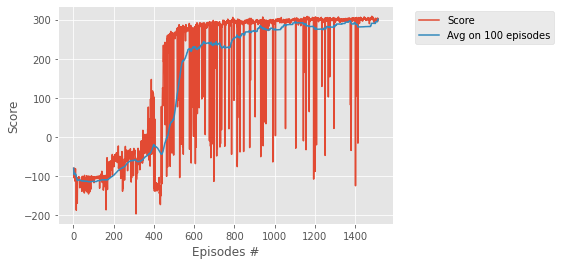

In [11]:
%matplotlib inline

print('length of scores: ', len(scores), ', len of average scores: ', len(Avg_Scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores, label="Score")
plt.plot(np.arange(1, len(Avg_Scores) + 1), Avg_Scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [12]:
env.close

<bound method Wrapper.close of <TimeLimit<BipedalWalker<BipedalWalker-v3>>>>